# Interactive Recipe & Kitchen Management Assistant


## Project Overview

The Interactive Recipe & Kitchen Management Assistant helps users:
1. Discover recipes based on available ingredients
2. Customize recipes according to dietary needs
3. Receive step-by-step cooking guidance

This assistant will use multiple Gen AI capabilities including:
- Audio understanding (for voice input)
- Few-shot prompting (for recipe customization)
- Function calling (for specific recipe operations)
- RAG (Retrieval Augmented Generation for recipe knowledge)
- Grounding (using web search for supplemental information)

## Step 1: Data Source & Setup

This notebook implements the first step of our Interactive Recipe & Kitchen Management Assistant capstone project for the Google Gen AI Intensive Course. We'll acquire, explore, and prepare the recipe dataset that will serve as the foundation for our recipe retrieval and customization system.


## Setup Environment

Let's start by installing and importing the necessary libraries for data processing.

In [1]:
# Clean up and install compatible versions
#!pip uninstall -y tensorflow protobuf google-api-core google-cloud-automl google-generativeai google-cloud-translate chromadb
!pip uninstall -qqy kfp > /dev/null 2>&1

# Install chromadb with compatible versions
!pip install -qU --no-warn-conflicts "google-genai==1.7.0" chromadb==0.6.3 
# #!pip install -U google-api-core==2.16.0

!pip install -q --no-warn-conflicts google-cloud-speech

# Install base packages with minimal dependencies
!pip install -q --no-warn-conflicts pandas matplotlib seaborn 
!pip install -q --no-warn-conflicts kagglehub[pandas-datasets]
!pip install -q --no-warn-conflicts soundfile pydub ipywidgets openai

# Install compatible versions
#!pip install -q google-generativeai  # Latest version instead of 1.7.0




## Import Libraries

Now let's import the libraries we'll need for this step.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import re
import os
from collections import Counter
from pathlib import Path
import datetime
import random
import warnings
from openai import OpenAI
import io
import tempfile
import requests

import ipywidgets as widgets
from IPython.display import Audio, Image, clear_output, display, HTML, clear_output, Markdown
from typing import Dict, List, Optional, Tuple, Any


import sqlite3
import chromadb
from chromadb.utils import embedding_functions
from chromadb.config import Settings



# Set warnings filter
warnings.filterwarnings('ignore')

# Audio processing libraries with error handling
try:
    import soundfile as sf
    import sounddevice as sd
    from IPython.display import Audio, display
    AUDIO_LIBRARIES_AVAILABLE = True
    print("Audio libraries imported successfully!")
except (ImportError, OSError) as e:
    print(f"Warning: Audio libraries could not be imported: {e}")

# Google Cloud Speech-to-Text (with error handling)
try:
    from google.cloud import speech
    GOOGLE_SPEECH_AVAILABLE = True
    print("Google Cloud Speech-to-Text is imported successfully!")
except ImportError:
    GOOGLE_SPEECH_AVAILABLE = False
    print("Google Cloud Speech-to-Text not available. Will use simulation for speech recognition.")

# Google Gemini API for natural language understanding
from google import genai
from google.genai import types
from google.api_core import retry

# Set up a retry helper. This allows you to "Run all" without worrying about per-minute quota.
is_retriable = lambda e: (isinstance(e, genai.errors.APIError) and e.code in {429, 503})
genai.models.Models.generate_content = retry.Retry(
    predicate=is_retriable)(genai.models.Models.generate_content)

# Configure visualizations
plt.style.use('ggplot')
sns.set(style="whitegrid")

# Display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_colwidth', 100)

print("Environment setup complete!")
genai.__version__

Google Cloud Speech-to-Text is imported successfully!
Environment setup complete!


'1.7.0'

In [2]:
import sys
import os

# Check Python paths
print("Python path:")
for path in sys.path:
    print(path)

# Try to find chromadb
try:
    import chromadb
    print(f"\nchromadb imported as: {type(chromadb)}")
    print(f"chromadb location: {chromadb.__file__}")
except Exception as e:
    print(f"\nError importing chromadb: {e}")

Python path:
/usr/lib/python312.zip
/usr/lib/python3.12
/usr/lib/python3.12/lib-dynload

/home/snowholt/venv/analytic/lib/python3.12/site-packages

chromadb imported as: <class 'module'>
chromadb location: /home/snowholt/venv/analytic/lib/python3.12/site-packages/chromadb/__init__.py


### Set up your API key

To run the following cell, your API key must be stored it in a [Kaggle secret](https://www.kaggle.com/discussions/product-feedback/114053) named `GOOGLE_API_KEY`, `GOOGLE_APPLICATION_CREDENTIALS`, `OPENAI_API_KEY`.

If you don't already have an API key, you can grab one from [AI Studio](https://aistudio.google.com/app/apikey). You can find [detailed instructions in the docs](https://ai.google.dev/gemini-api/docs/api-key).

To make the key available through Kaggle secrets, choose `Secrets` from the `Add-ons` menu and follow the instructions to add your key or enable it for this notebook.

Furthermore, for the Google Cloud Client Libraries (like the google-cloud-speech Python library you're using), you generally cannot authenticate using only an API Key. 🚫🔑, So you need to provide and import Service Account Credentials (JSON Key File).

In [3]:
# from kaggle_secrets import UserSecretsClient

# GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")
# OPENAI_API_KEY = UserSecretsClient().get_secret("OPENAI_API_KEY")
# SecretValueJson = UserSecretsClient().get_secret("GOOGLE_APPLICATION_CREDENTIALS") # Use the label you gave the secret


In [4]:
# Import the os module to access environment variables

# Access environment variables
def get_api_key(key_name):
    """
    Retrieve an API key from environment variables.
    
    Args:
        key_name (str): The name of the environment variable containing the API key
        
    Returns:
        str: The API key or None if it doesn't exist
    """
    api_key = os.environ.get(key_name)
    
    if api_key is None:
        print(f"Warning: {key_name} environment variable not found.")
    
    return api_key

# Example usage
GOOGLE_API_KEY = get_api_key("GOOGLE_API_KEY")
OPENAI_API_KEY = get_api_key("OPENAI_API_KEY")
SecretValueJson=get_api_key("GOOGLE_APPLICATION_CREDENTIALS")
# Check if keys exist
print(f"Google API Key exists: {GOOGLE_API_KEY is not None}")
print(f"OpenAI API Key exists: {OPENAI_API_KEY is not None}")
print(f"SecretValueJson API Key exists: {SecretValueJson is not None}")

Google API Key exists: True
OpenAI API Key exists: True
SecretValueJson API Key exists: True



## Data Loading

### Importing the Dataset in Kaggle

Since you're using Kaggle, you can easily import the Food.com Recipes dataset directly:

1. Search for "Food.com Recipes and User Interactions" in the Kaggle datasets section
2. Or use this direct link: https://www.kaggle.com/datasets/shuyangli94/food-com-recipes-and-user-interactions

In Kaggle, you can either:
- Add the dataset to your notebook directly from the "Add data" button in the right sidebar
- Use the Kaggle datasets API as shown below


We'll use the Food.com Recipes and Interactions dataset. This contains recipe information including ingredients, steps, and user interactions.

If you've downloaded the dataset using the Kaggle API, uncomment and use the data loading code below. Otherwise, we'll use a direct URL to access the data.

loading both the vectorized and raw data and nutritional breakdown dataset that will be used in subsequent steps, particularly for the few-shot prompting recipe customization implementation.

In [5]:
# Option 1: Direct Kaggle dataset import
# This is the easiest way to import datasets in Kaggle notebooks

try:
    # If the dataset is added via the "Add data" button, it will be available at /kaggle/input/
    recipes_df = pd.read_csv('/home/snowholt/coding/python/google_capstone/datasets/RAW_recipes.csv')
    interactions_df = pd.read_csv('/home/snowholt/coding/python/google_capstone/datasets/RAW_interactions.csv')
    nutrition_df = pd.read_csv('/home/snowholt/coding/python/google_capstone/datasets/cleaned_nutrition_dataset.csv')
    print(f"Successfully loaded {len(recipes_df)} recipes")
    print(f"Successfully loaded {len(interactions_df)} interactions")
    print(f"Successfully loaded nutritional dataset with {len(nutrition_df)} records")

    
    
    
except FileNotFoundError:
    print("Dataset files not found. Please make sure you've added the dataset to your Kaggle notebook.")
    print("You can add it by clicking the 'Add data' button in the right sidebar.")
    print("Alternatively, you can use direct URLs if available.")

# Let's parse the JSON strings in the columns that contain lists
if 'recipes_df' in locals():
    # Check the actual structure of the dataframe
    
    # For Food.com dataset, ingredients, steps, and tags are stored as strings that represent lists
    # We need to convert them from string representation to actual Python lists
    try:
        if 'ingredients' in recipes_df.columns:
            recipes_df['ingredients'] = recipes_df['ingredients'].apply(eval)
            print("Successfully parsed ingredients column")
        
        if 'steps' in recipes_df.columns:
            recipes_df['steps'] = recipes_df['steps'].apply(eval)
            print("Successfully parsed steps column")
        
        if 'tags' in recipes_df.columns:
            recipes_df['tags'] = recipes_df['tags'].apply(eval)
            print("Successfully parsed tags column")
            
            # Add cuisine type based on tags
            recipes_df['cuisine_type'] = recipes_df['tags'].apply(
                lambda x: next((tag for tag in x if tag in ['italian', 'persian', 'mexican', 'chinese', 'indian', 'french', 'thai']), 'other')
            )
        
      
        # Count number of ingredients
        recipes_df['n_ingredients'] = recipes_df['ingredients'].apply(len)
            
        print("\nDataset successfully processed")
        
    except Exception as e:
        print(f"Error processing dataset: {e}")
        print("Column sample values:")
        for col in recipes_df.columns:
            print(f"{col}: {recipes_df[col].iloc[0]}")



Successfully loaded 231637 recipes
Successfully loaded 1132367 interactions
Successfully loaded nutritional dataset with 3454 records
Successfully parsed ingredients column
Successfully parsed steps column
Successfully parsed tags column

Dataset successfully processed


## Data Exploration

Let's explore the dataset to understand its structure and content. This will help us plan our cleaning and preprocessing steps.

In [6]:

# Function to analyze dataframe properties
def analyze_dataframe(df, df_name):
    print(f"\n{'-' * 30}")
    print(f"Analysis for {df_name}:")
    print(f"{'-' * 30}")
    
    # Check data types
    print("\nData types:")
    for col in df.columns:
        print(f"{col}: {df[col].dtype}")
    
    # Check missing values
    print("\nMissing values per column:")
    missing_values = df.isnull().sum()
    for col, missing in zip(missing_values.index, missing_values.values):
        if missing > 0:
            print(f"{col}: {missing} missing values ({missing/len(df):.2%})")
    
    # Summary statistics for numeric columns
    print("\nNumeric columns summary:")
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    if numeric_cols:
        # Show basic stats for numeric columns only
        print(df[numeric_cols].describe().T[['count', 'mean', 'min', 'max']])
    else:
        print("No numeric columns found")

# Analyze all dataframes
print("\n=== DATA ANALYSIS FOR ALL DATAFRAMES ===")
analyze_dataframe(recipes_df, "Recipes")
analyze_dataframe(interactions_df, "Interactions")
analyze_dataframe(nutrition_df, "Nutrition")






=== DATA ANALYSIS FOR ALL DATAFRAMES ===

------------------------------
Analysis for Recipes:
------------------------------

Data types:
name: object
id: int64
minutes: int64
contributor_id: int64
submitted: object
tags: object
nutrition: object
n_steps: int64
steps: object
description: object
ingredients: object
n_ingredients: int64
cuisine_type: object

Missing values per column:
name: 1 missing values (0.00%)
description: 4979 missing values (2.15%)

Numeric columns summary:
                   count          mean   min           max
id              231637.0  2.220147e+05  38.0  5.377160e+05
minutes         231637.0  9.398546e+03   0.0  2.147484e+09
contributor_id  231637.0  5.534885e+06  27.0  2.002290e+09
n_steps         231637.0  9.765499e+00   0.0  1.450000e+02
n_ingredients   231637.0  9.051153e+00   1.0  4.300000e+01

------------------------------
Analysis for Interactions:
------------------------------

Data types:
user_id: int64
recipe_id: int64
date: object
rating: int6

In [7]:
# Sample a few rows instead of full stats
print("\nSample rows:")
print(recipes_df.sample(3))


Sample rows:
                                     name      id  minutes  contributor_id  \
99515   grilled pork and mushroom skewers  455147       40           28087   
204887               swamp and gator food  309771       20          713116   
58001            corn and grits casserole  170907       45          264745   

         submitted  \
99515   2011-05-05   
204887  2008-06-17   
58001   2006-05-31   

                                                                                                       tags  \
99515   [60-minutes-or-less, time-to-make, course, main-ingredient, cuisine, preparation, main-dish, por...   
204887  [30-minutes-or-less, time-to-make, course, preparation, for-large-groups, desserts, cookies-and-...   
58001   [60-minutes-or-less, time-to-make, course, main-ingredient, cuisine, preparation, occasion, nort...   

                                          nutrition  n_steps  \
99515     [408.6, 31.0, 22.0, 4.0, 87.0, 21.0, 3.0]        5   
204887     

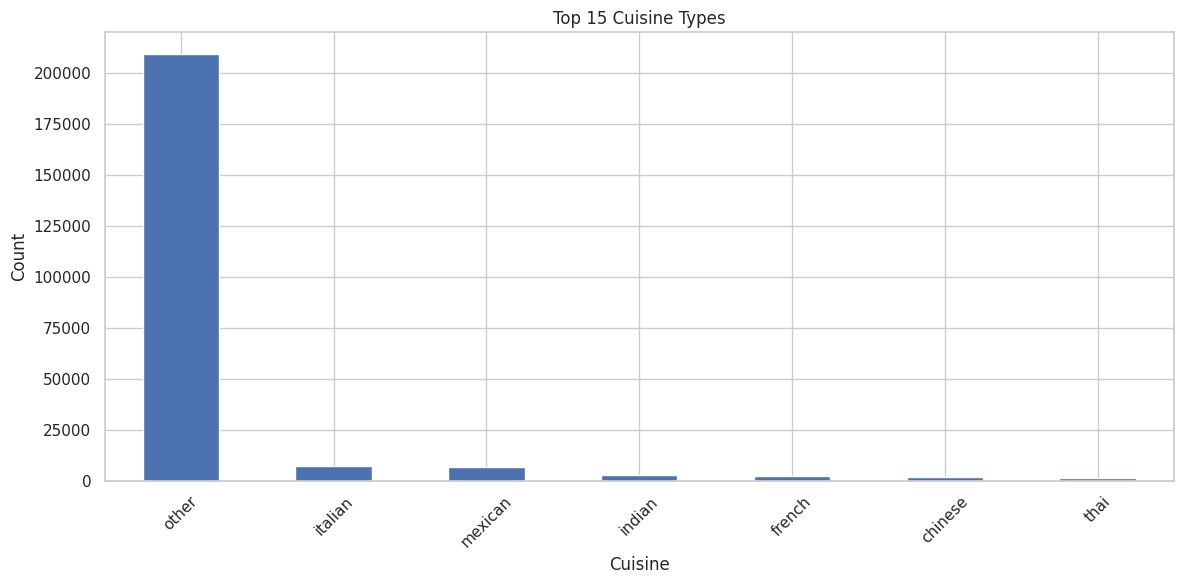

In [8]:
# # Distribution of cuisine types
plt.figure(figsize=(12, 6))
if 'cuisine_type' in recipes_df.columns:
    # Limit to top 15 cuisines to avoid cluttered plot
    recipes_df['cuisine_type'].value_counts().nlargest(15).plot(kind='bar')
    plt.title('Top 15 Cuisine Types')
    plt.xlabel('Cuisine')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()



In [9]:
# # Distribution of cooking time - use smaller bins
# if 'cooking_time' in recipes_df.columns:
#     plt.figure(figsize=(10, 6))
#     # Use log scale for better visualization if the range is large
#     if recipes_df['cooking_time'].max() > 5 * recipes_df['cooking_time'].median():
#         sns.histplot(recipes_df['cooking_time'].clip(upper=recipes_df['cooking_time'].quantile(0.95)), bins=20)
#         plt.title('Distribution of Cooking Time (minutes) - Clipped at 95th percentile')
#     else:
#         sns.histplot(recipes_df['cooking_time'], bins=20)
#         plt.title('Distribution of Cooking Time (minutes)')
#     plt.xlabel('Cooking Time (minutes)')
#     plt.ylabel('Count')
#     plt.tight_layout()
#     plt.show()

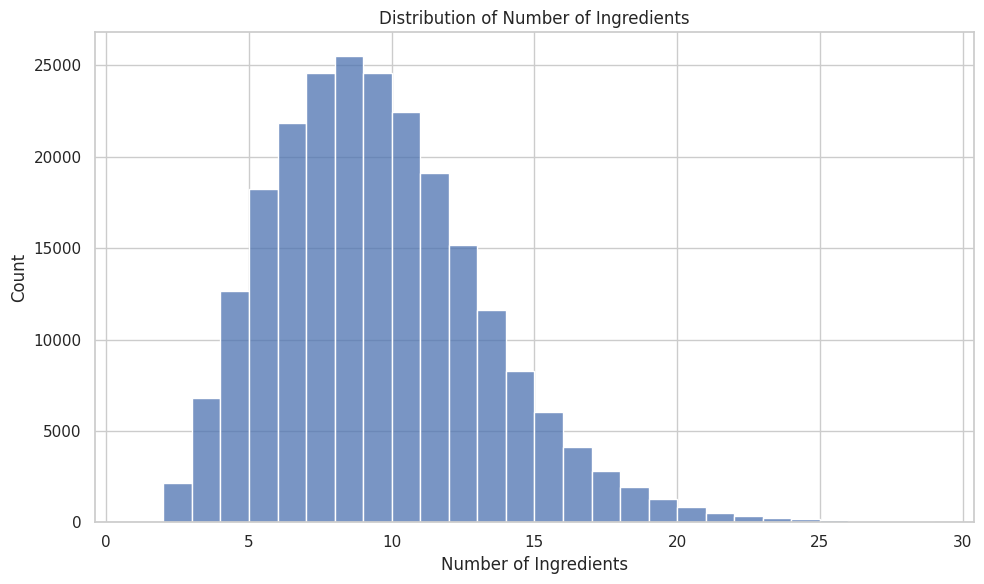

In [10]:
# Number of ingredients distribution
if 'n_ingredients' in recipes_df.columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(recipes_df['n_ingredients'], bins=range(1, min(30, recipes_df['n_ingredients'].max()+1)))
    plt.title('Distribution of Number of Ingredients')
    plt.xlabel('Number of Ingredients')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

## Data Cleaning and Preprocessing

Now we'll clean the data by:
1. Removing duplicate recipes
2. Normalizing ingredient names
3. Standardizing measurements
4. Handling missing values
5. Creating dietary tags

In [11]:

# Function to check and remove duplicates in dataframes
def check_remove_duplicates(df, df_name, subset_cols=None):
    """
    Check and remove duplicates from a dataframe.
    
    Args:
        df: The dataframe to process
        df_name: Name of the dataframe for printing
        subset_cols: List of columns to consider for duplicates. If None, all columns are used.
    
    Returns:
        Dataframe with duplicates removed
    """
    print(f"\n{'-' * 30}")
    print(f"Duplicate analysis for {df_name}:")
    print(f"{'-' * 30}")
    
    # If subset not specified, identify potential key columns
    if subset_cols is None:
        # Try to find ID-like columns first
        id_cols = [col for col in df.columns if 'id' in col.lower()]
        name_cols = [col for col in df.columns if 'name' in col.lower()]
        
        if id_cols:
            subset_cols = id_cols
            print(f"Using ID columns for duplicate check: {subset_cols}")
        elif name_cols:
            subset_cols = name_cols
            print(f"Using name columns for duplicate check: {subset_cols}")
        else:
            # Use all columns if no suitable identifiers found
            subset_cols = df.columns.tolist()
            print("Using all columns for duplicate check")
    
    # Check for duplicates
    dup_count = df.duplicated(subset=subset_cols).sum()
    print(f"Number of duplicates in {df_name}: {dup_count} ({dup_count/len(df):.2%} of data)")
    
    if dup_count > 0:
        # Remove duplicates
        df_cleaned = df.drop_duplicates(subset=subset_cols).reset_index(drop=True)
        print(f"Number of records after removing duplicates: {len(df_cleaned)}")
        return df_cleaned
    else:
        print("No duplicates found")
        return df


In [12]:
# Check and remove duplicates from all dataframes
print("\n=== DUPLICATE ANALYSIS FOR ALL DATAFRAMES ===")
recipes_df = check_remove_duplicates(recipes_df, "Recipes", subset_cols=['name'])
interactions_df = check_remove_duplicates(interactions_df, "Interactions")
nutrition_df = check_remove_duplicates(nutrition_df, "Nutrition")



=== DUPLICATE ANALYSIS FOR ALL DATAFRAMES ===

------------------------------
Duplicate analysis for Recipes:
------------------------------
Number of duplicates in Recipes: 1451 (0.63% of data)
Number of records after removing duplicates: 230186

------------------------------
Duplicate analysis for Interactions:
------------------------------
Using ID columns for duplicate check: ['user_id', 'recipe_id']
Number of duplicates in Interactions: 0 (0.00% of data)
No duplicates found

------------------------------
Duplicate analysis for Nutrition:
------------------------------
Using all columns for duplicate check
Number of duplicates in Nutrition: 0 (0.00% of data)
No duplicates found


In [13]:

# Function to normalize ingredient names
def normalize_ingredients(ingredient_list):
    """
    Normalize ingredient names by removing quantities and standardizing format
    """
    normalized = []
    # If ingredient_list is already a list of strings
    if isinstance(ingredient_list, list):
        for ingredient in ingredient_list:
            # Skip empty ingredients
            if not ingredient or not isinstance(ingredient, str):
                continue
            
            # Remove quantities (simplified for demonstration)
            cleaned = re.sub(r'^\d+\s+\d+/\d+\s+', '', ingredient)
            cleaned = re.sub(r'^\d+/\d+\s+', '', cleaned)
            cleaned = re.sub(r'^\d+\s+', '', cleaned)
            
            # Convert to lowercase and strip whitespace
            cleaned = cleaned.lower().strip()
            
            normalized.append(cleaned)
    else:
        # Handle the case where ingredient_list might be a string or another format
        print("Warning: Expected ingredient_list to be a list, but got:", type(ingredient_list))
        if isinstance(ingredient_list, str):
            # Try to interpret as a string representation of a list
            try:
                actual_list = eval(ingredient_list) if ingredient_list.startswith('[') else [ingredient_list]
                return normalize_ingredients(actual_list)
            except:
                normalized = [ingredient_list.lower().strip()]
    
    return normalized

# Apply normalization to ingredients - with error handling
recipes_df['normalized_ingredients'] = recipes_df['ingredients'].apply(
    lambda x: normalize_ingredients(x) if isinstance(x, list) or isinstance(x, str) else []
)

# Show a sample recipe with normalized ingredients
if len(recipes_df) > 0:
    sample_idx = 0
    print(f"Original ingredients: {recipes_df.iloc[sample_idx]['ingredients']}")
    print(f"Normalized ingredients: {recipes_df.iloc[sample_idx]['normalized_ingredients']}")
else:
    print("No recipes found in the dataframe.")

Original ingredients: ['winter squash', 'mexican seasoning', 'mixed spice', 'honey', 'butter', 'olive oil', 'salt']
Normalized ingredients: ['winter squash', 'mexican seasoning', 'mixed spice', 'honey', 'butter', 'olive oil', 'salt']


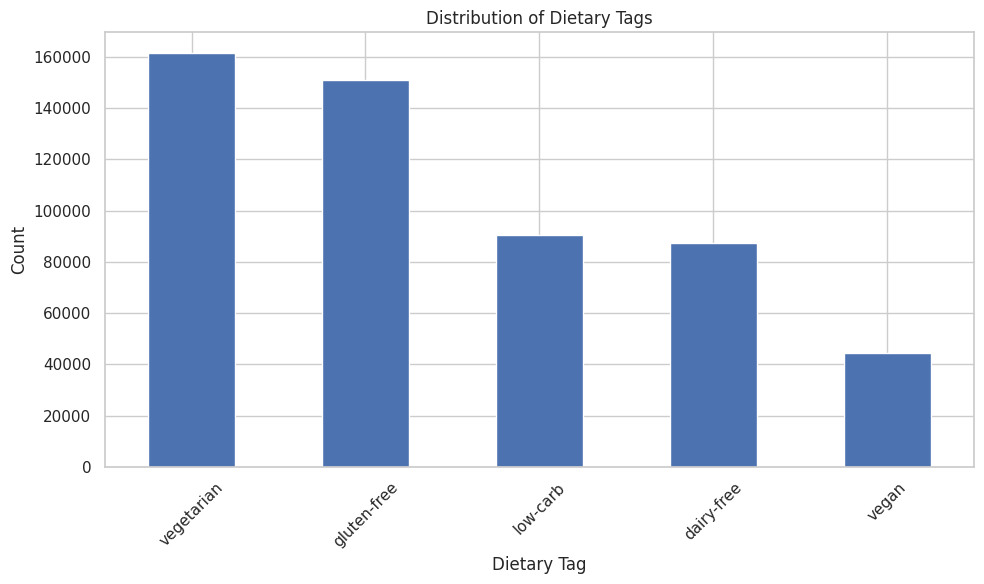


Sample recipes with dietary tags:

Recipe: chicken legs with ricotta and bacon stuffing
Ingredients: chicken legs with thigh, butter, bacon, vegetable oil, onion, garlic, ricotta cheese, egg, parmesan cheese, fresh breadcrumb, fresh parsley, fresh chives, fresh tarragon, nutmeg
Dietary Tags: None

Recipe: passover vegetable cups
Ingredients: onion, frozen chopped broccoli, carrots, matzo meal, eggs, salt, pepper, mushroom soup mix
Dietary Tags: vegetarian, gluten-free, low-carb, dairy-free

Recipe: peta s awfully good waffles
Ingredients: white flour, whole wheat flour, baking powder, cinnamon, salt, soymilk, applesauce
Dietary Tags: vegetarian

Recipe: slow cooked greek style chicken recipe
Ingredients: chicken thighs, olive oil, carrots, broccoli, garlic cloves, chickpeas, shallots, potatoes, oregano, lemons, juice of, salt, pepper
Dietary Tags: gluten-free, dairy-free

Recipe: bagel roll   sushi
Ingredients: green onions, light cream cheese, wasabi, nori, cooked sushi rice, smoked 

In [14]:
# Function to identify dietary tags based on ingredients
def identify_dietary_tags(ingredients):
    """
    Identify dietary preferences based on ingredients
    """
    # Handle empty ingredients list
    if not ingredients or not isinstance(ingredients, (list, str)):
        return []
        
    # Convert list of ingredients to a single string for easier checking
    ingredients_str = ' '.join(ingredients).lower()
    
    tags = []
    
    # Vegetarian check (simplified)
    meat_ingredients = ['chicken', 'beef', 'pork', 'lamb', 'turkey', 'veal', 'bacon']
    if not any(meat in ingredients_str for meat in meat_ingredients):
        tags.append('vegetarian')
        
        # Vegan check (simplified)
        animal_products = ['cheese', 'milk', 'cream', 'yogurt', 'butter', 'egg', 'honey']
        if not any(product in ingredients_str for product in animal_products):
            tags.append('vegan')
    
    # Gluten-free check (simplified)
    gluten_ingredients = ['flour', 'wheat', 'barley', 'rye', 'pasta', 'bread']
    if not any(gluten in ingredients_str for gluten in gluten_ingredients):
        tags.append('gluten-free')
    
    # Low-carb check (simplified)
    high_carb_ingredients = ['sugar', 'pasta', 'rice', 'potato', 'bread', 'flour']
    if not any(carb in ingredients_str for carb in high_carb_ingredients):
        tags.append('low-carb')
    
    # Dairy-free check
    dairy_ingredients = ['milk', 'cheese', 'cream', 'yogurt', 'butter']
    if not any(dairy in ingredients_str for dairy in dairy_ingredients):
        tags.append('dairy-free')
    
    return tags

# Apply dietary tagging
recipes_df['dietary_tags'] = recipes_df['normalized_ingredients'].apply(identify_dietary_tags)

# Show the distribution of dietary tags
diet_counts = {}
for tags in recipes_df['dietary_tags']:
    for tag in tags:
        diet_counts[tag] = diet_counts.get(tag, 0) + 1

plt.figure(figsize=(10, 6))
diet_df = pd.Series(diet_counts).sort_values(ascending=False)
diet_df.plot(kind='bar')
plt.title('Distribution of Dietary Tags')
plt.xlabel('Dietary Tag')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Show sample recipes with their dietary tags
print("\nSample recipes with dietary tags:")
sample_recipes = recipes_df[['name', 'normalized_ingredients', 'dietary_tags']].sample(5)
for _, recipe in sample_recipes.iterrows():
    print(f"\nRecipe: {recipe['name']}")
    print(f"Ingredients: {', '.join(recipe['normalized_ingredients'])}")
    print(f"Dietary Tags: {', '.join(recipe['dietary_tags']) if recipe['dietary_tags'] else 'None'}")

In [16]:

# Basic dataset information
print("Raw Datasets information:")
print(f"Number of recipes: {len(recipes_df)}")
print("\nrecipes_df columns:")
print(recipes_df.columns.tolist())
print(15 * "-")
print(f"Number of interactions: {len(interactions_df)}")
print("\ninteractions_df columns:")
print(interactions_df.columns.tolist())
print(15 * "-")
print(f"Number of nutritions: {len(nutrition_df)}")
print("\nnutrition_df columns:")
print(nutrition_df.columns.tolist())
print(15 * "-")


Raw Datasets information:
Number of recipes: 230186

recipes_df columns:
['name', 'id', 'minutes', 'contributor_id', 'submitted', 'tags', 'nutrition', 'n_steps', 'steps', 'description', 'ingredients', 'n_ingredients', 'cuisine_type', 'normalized_ingredients', 'dietary_tags']
---------------
Number of interactions: 1132367

interactions_df columns:
['user_id', 'recipe_id', 'date', 'rating', 'review']
---------------
Number of nutritions: 3454

nutrition_df columns:
['Vitamin C', 'Vitamin B11', 'Sodium', 'Calcium', 'Carbohydrates', 'food', 'Iron', 'Caloric Value', 'Sugars', 'Dietary Fiber', 'Fat', 'Protein', 'food_normalized']
---------------


## Final Data Structure and Storage

### Save Datasets in JSON Format for RAG Implementation

Let's save each dataset in JSON format to facilitate their use in our Retrieval Augmented Generation (RAG) system. JSON format is highly compatible with various RAG implementations and will make it easier to load the data in subsequent steps.

In [17]:
import chromadb
print(chromadb.__version__)


0.6.3


In [18]:


# Define paths for ChromaDB and SQL database
VECTOR_DB_PATH = "final/vector_db"
DB_PATH = "final/kitchen_db.sqlite"

#####################
# SQL Database Setup
#####################
def safe_convert(x):
    """
    Safely converts a value to a string:
      - If x is a list or numpy array, join its elements into a space-separated string.
      - If x is not a list/array and is not null, convert to string.
      - Otherwise, return an empty string.
    """
    if isinstance(x, (list, np.ndarray)):
        return " ".join([str(item) for item in x])
    return str(x) if pd.notna(x) else ""


def preprocess_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    """
    Preprocess DataFrame columns to be SQLite-compatible.
    """
    for column in df.columns:
        if df[column].dtype == 'object':
            df[column] = df[column].apply(safe_convert)
    return df

def setup_sql_database(
    recipes_df: pd.DataFrame, 
    interactions_df: pd.DataFrame, 
    nutrition_df: Optional[pd.DataFrame] = None,
    db_path: str = DB_PATH
) -> sqlite3.Connection:
    """
    Set up SQLite database with raw dataframes.
    """
    recipes_df = preprocess_dataframe(recipes_df)
    interactions_df = preprocess_dataframe(interactions_df)
    if nutrition_df is not None:
        nutrition_df = preprocess_dataframe(nutrition_df)

    os.makedirs(os.path.dirname(db_path), exist_ok=True)
    print(f"Creating SQLite database at {db_path}")
    conn = sqlite3.connect(db_path)
    
    print(f"Storing {len(recipes_df)} recipes in the database")
    recipes_df.to_sql('recipes', conn, if_exists='replace', index=False)
    print(f"Storing {len(interactions_df)} interactions in the database")
    interactions_df.to_sql('interactions', conn, if_exists='replace', index=False)
    
    if nutrition_df is not None:
        print(f"Storing {len(nutrition_df)} nutrition entries in the database")
        nutrition_df.to_sql('nutrition', conn, if_exists='replace', index=False)
    
    print("SQL database setup complete")
    return conn

#############################
# Vector Database Setup (ChromaDB)
#############################
def setup_vector_database(
    vectorized_recipes_df: pd.DataFrame,
    vectorized_interactions_df: Optional[pd.DataFrame] = None,
    vector_db_path: str = VECTOR_DB_PATH
) -> Tuple[Any, Any, Optional[Any]]:
    """
    Set up ChromaDB using the precomputed dataframes for recipes and interactions.
    
    Arguments:
        vectorized_recipes_df: DataFrame with your recipe data.
        vectorized_interactions_df: DataFrame with your interaction data.
        vector_db_path: Directory where ChromaDB will store its data.
        
    Returns:
        A tuple containing the ChromaDB client, the recipe collection, and 
        the interactions collection (if interactions_df is provided).
    """
    os.makedirs(vector_db_path, exist_ok=True)
    print(f"Creating ChromaDB at {vector_db_path}")
    client = chromadb.PersistentClient(path=vector_db_path)
    
    #########################
    # Load recipes into ChromaDB
    #########################
    print(f"Setting up recipe collection with {len(vectorized_recipes_df)} recipes")
    recipe_collection = client.get_or_create_collection(name="recipes")
    
    recipe_documents = []
    recipe_metadatas = []
    recipe_ids = []
    
    # Define which recipe columns to include as metadata
    metadata_fields = ['name', 'minutes', 'contributor_id', 'submitted',
                       'tags', 'nutrition', 'n_steps', 'cuisine_type',
                       'n_ingredients', 'dietary_tags']
    
    for i, row in vectorized_recipes_df.iterrows():
        # Determine a unique recipe ID. Use 'id' column if available.
        recipe_id = row.get('id')
        if recipe_id is None or (isinstance(recipe_id, float) and pd.isna(recipe_id)) or recipe_id == "":
            recipe_id = str(i)
        else:
            recipe_id = str(recipe_id)
        recipe_ids.append(recipe_id)
        
        # Build a document string by concatenating key text fields.
        # You may adjust the fields below to better capture recipe information.
        doc_text = " ".join([
            safe_convert(row.get('name', '')),
            safe_convert(row.get('ingredients', '')),
            safe_convert(row.get('steps', '')),
            safe_convert(row.get('description', ''))
        ])
        recipe_documents.append(doc_text)
        
        # Build richer metadata from the chosen fields.
        metadata = {key: safe_convert(row.get(key, "")) for key in metadata_fields}
        metadata['recipe_id'] = recipe_id
        recipe_metadatas.append(metadata)
    
    batch_size = 1000
    for j in range(0, len(recipe_documents), batch_size):
        end_idx = min(j + batch_size, len(recipe_documents))
        recipe_collection.add(
            documents=recipe_documents[j:end_idx],
            metadatas=recipe_metadatas[j:end_idx],
            ids=recipe_ids[j:end_idx]
        )
    
    #########################
    # Load interactions into ChromaDB (if provided)
    #########################
    interactions_collection = None
    if vectorized_interactions_df is not None and not vectorized_interactions_df.empty:
        print(f"Setting up interactions collection with {len(vectorized_interactions_df)} interactions")
        interactions_collection = client.get_or_create_collection(name="interactions")
        
        interaction_documents = []
        interaction_metadatas = []
        interaction_ids = []
        
        for i, row in vectorized_interactions_df.iterrows():
            # Create a unique interaction ID from user_id, recipe_id, and index.
            user_id = safe_convert(row.get('user_id', ''))
            recipe_id = safe_convert(row.get('recipe_id', ''))
            interaction_id = f"{user_id}_{recipe_id}_{i}"
            interaction_ids.append(interaction_id)
            
            # Use the review text as the primary document.
            review_text = safe_convert(row.get('review', ''))
            if not review_text:
                review_text = "No review provided."
            interaction_documents.append(review_text)
            
            # Build metadata for this interaction.
            int_metadata = {
                'interaction_id': interaction_id,
                'user_id': user_id,
                'recipe_id': recipe_id,
                'date': safe_convert(row.get('date', '')),
                'rating': safe_convert(row.get('rating', ''))
            }
            interaction_metadatas.append(int_metadata)
        
        for j in range(0, len(interaction_documents), batch_size):
            end_idx = min(j + batch_size, len(interaction_documents))
            interactions_collection.add(
                documents=interaction_documents[j:end_idx],
                metadatas=interaction_metadatas[j:end_idx],
                ids=interaction_ids[j:end_idx]
            )
    
    print("Vector database setup complete")
    return client, recipe_collection, interactions_collection




In [19]:
##############################
# Main Execution
##############################
if __name__ == "__main__":
    # Assume recipes_df and interactions_df have been loaded previously.
    # For example:
    # recipes_df = pd.read_pickle("your_recipes.pkl")
    # interactions_df = pd.read_pickle("your_interactions.pkl")

    # Set up the SQL database
    # sqlite_conn = setup_sql_database(
    #     recipes_df=recipes_df,
    #     interactions_df=interactions_df,
    #     nutrition_df=nutrition_df,  # Modify if you have nutrition data.
    #     db_path=DB_PATH
    # )
    
    # Set up ChromaDB with recipes and interactions
    # chroma_client, recipe_collection, interactions_collection = setup_vector_database(
    #     vectorized_recipes_df=recipes_df,
    #     vectorized_interactions_df=interactions_df,
    #     vector_db_path=VECTOR_DB_PATH
    # )
    
    print("ChromaDB is ready for similarity search!")

ChromaDB is ready for similarity search!


In [20]:

# Path to SQL database
DB_PATH = "final/kitchen_db.sqlite"
# Path to Vectorized database
VECTOR_DB_PATH = "final/vector_db"


def view_schema_info(collection_name: str, db_path: str = VECTOR_DB_PATH):
    """
    View schema information for a collection (metadata fields and their data types).
    
    Args:
        collection_name: Name of the collection to analyze
        db_path: Path to the ChromaDB database
    """
    client = chromadb.PersistentClient(path=db_path)
    
    try:
        collection = client.get_collection(name=collection_name)
    except ValueError as e:
        print(f"Collection '{collection_name}' not found. Error: {str(e)}")
        return None
    
    # Get a sample of records to analyze schema
    try:
        results = collection.get(
            limit=100,
            include=['metadatas']
        )
        
        if not results['metadatas']:
            print(f"Collection '{collection_name}' is empty or has no metadata.")
            return None
        
        # Analyze metadata fields
        print(f"\n=== Schema for '{collection_name}' collection ===\n")
        print("Metadata fields:")
        
        # Collect all possible keys and their types
        all_keys = set()
        key_types = {}
        key_examples = {}
        
        for metadata in results['metadatas']:
            for key, value in metadata.items():
                all_keys.add(key)
                
                # Track the data type
                value_type = type(value).__name__
                if key not in key_types:
                    key_types[key] = set()
                key_types[key].add(value_type)
                
                # Store an example value
                if key not in key_examples and value:
                    example = str(value)
                    if len(example) > 50:
                        example = example[:50] + "..."
                    key_examples[key] = example
        
        # Display the schema information
        for key in sorted(all_keys):
            types_str = ", ".join(key_types[key])
            example = key_examples.get(key, "N/A")
            print(f"  - {key}: {types_str}")
            print(f"    Example: {example}")
        
        return key_types
    
    except Exception as e:
        print(f"Error getting schema info: {str(e)}")
        return None


def collection_info(db_path: str = VECTOR_DB_PATH):
    """
    A simple function to display basic information about all collections.
    More robust against API changes than the other functions.
    
    Args:
        db_path: Path to the ChromaDB database
    """
    client = chromadb.PersistentClient(path=db_path)
    
    try:
        collection_names = client.list_collections()
        print(f"Found {len(collection_names)} collections in {db_path}:")
        
        for name in collection_names:
            print(f"\nCollection: {name}")
            
            try:
                collection = client.get_collection(name=str(name))
                
                # Try to get count
                try:
                    count = collection.count(where={})
                    print(f"  Records: {count}")
                except:
                    print("  Count: Could not retrieve")
                
                # Try to get the first few items
                try:
                    first_items = collection.get(limit=3, include=["metadatas"])
                    print(f"  Sample IDs: {first_items['ids']}")
                    
                    # Show first item metadata as example
                    if first_items['metadatas'] and len(first_items['metadatas']) > 0:
                        print("  Sample metadata keys:", list(first_items['metadatas'][0].keys()))
                except:
                    print("  Sample: Could not retrieve")
                    
            except Exception as e:
                print(f"  Error accessing collection: {str(e)}")
        
    except Exception as e:
        print(f"Error listing collections: {str(e)}")


In [21]:
client = chromadb.PersistentClient(path=VECTOR_DB_PATH)
print(client.list_collections())

['interactions', 'recipes']


In [22]:
collection_info(VECTOR_DB_PATH)

Found 2 collections in final/vector_db:

Collection: interactions
  Count: Could not retrieve
  Sample IDs: ['38094_40893_0', '1293707_40893_1', '8937_44394_2']
  Sample metadata keys: ['date', 'interaction_id', 'rating', 'recipe_id', 'user_id']

Collection: recipes
  Count: Could not retrieve
  Sample IDs: ['137739', '31490', '112140']
  Sample metadata keys: ['contributor_id', 'cuisine_type', 'dietary_tags', 'minutes', 'n_ingredients', 'n_steps', 'name', 'nutrition', 'recipe_id', 'submitted', 'tags']


In [23]:
view_schema_info("recipes", VECTOR_DB_PATH)


=== Schema for 'recipes' collection ===

Metadata fields:
  - contributor_id: str
    Example: 47892
  - cuisine_type: str
    Example: mexican
  - dietary_tags: str
    Example: vegetarian gluten-free low-carb
  - minutes: str
    Example: 55
  - n_ingredients: str
    Example: 7
  - n_steps: str
    Example: 11
  - name: str
    Example: arriba   baked winter squash mexican style
  - nutrition: str
    Example: [51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]
  - recipe_id: str
    Example: 137739
  - submitted: str
    Example: 2005-09-16
  - tags: str
    Example: 60-minutes-or-less time-to-make course main-ingred...


{'contributor_id': {'str'},
 'cuisine_type': {'str'},
 'dietary_tags': {'str'},
 'minutes': {'str'},
 'n_ingredients': {'str'},
 'n_steps': {'str'},
 'name': {'str'},
 'nutrition': {'str'},
 'recipe_id': {'str'},
 'submitted': {'str'},
 'tags': {'str'}}

In [24]:
view_schema_info("interactions", VECTOR_DB_PATH)


=== Schema for 'interactions' collection ===

Metadata fields:
  - date: str
    Example: 2003-02-17
  - interaction_id: str
    Example: 38094_40893_0
  - rating: str
    Example: 4
  - recipe_id: str
    Example: 40893
  - user_id: str
    Example: 38094


{'date': {'str'},
 'interaction_id': {'str'},
 'rating': {'str'},
 'recipe_id': {'str'},
 'user_id': {'str'}}

In [25]:

def gemini_recipe_similarity_search(query_text: str, n_results: int, cuisine: Optional[str] = None, dietary_tag: Optional[str] = None, max_minutes: Optional[int] = None) -> str:
    """
    Searches for similar recipes based on a query, with optional filters and returns full metadata.

    Args:
        query_text: The text to search for in recipes.
        n_results: The number of top similar recipes to return.
        cuisine: (Optional) Filter by cuisine type (e.g., 'mexican', 'italian').
        dietary_tag: (Optional) Filter by dietary tag (e.g., 'vegetarian', 'gluten-free').
        max_minutes: (Optional) Filter recipes with a cooking time less than or equal to this value.

    Returns:
        A formatted string containing the full metadata of the top similar recipes with similarity scores.
    """
    try:
        client = chromadb.PersistentClient(path=VECTOR_DB_PATH)
        recipe_collection = client.get_collection(name="recipes")

        where_clause = {}
        if cuisine is not None:
            where_clause["cuisine_type"] = cuisine
        if dietary_tag is not None:
            where_clause["dietary_tags"] = {"$contains": dietary_tag}
        if max_minutes is not None:
            where_clause["minutes"] = {"$lte": str(max_minutes)} # Store as string in metadata

        results = recipe_collection.query(
            query_texts=[query_text],
            n_results=n_results,
            include=["documents", "metadatas", "distances"]
        )

        if not results['ids'][0]:
            return f"No similar recipes found for the query: '{query_text}' with the specified criteria."

        output = f"Found {len(results['ids'][0])} similar recipes for query: '{query_text}'.\n"
        output += "-" * 80 + "\n"
        for i, (doc_id, doc, metadata, distance) in enumerate(zip(
            results['ids'][0],
            results['documents'][0],
            results['metadatas'][0],
            results['distances'][0]
        )):
            similarity_score = (1 - distance) * 100
            output += f"\n{i+1}. Recipe Name: {metadata.get('name', 'Unnamed')}\n"
            output += f"   Similarity: {similarity_score:.2f}%\n"
            output += f"   Recipe ID: {doc_id}\n"
            for key, value in metadata.items():
                output += f"   {key.replace('_', ' ').title()}: {value}\n"
            output += f"   Ingredients: {doc}\n"  # Include the full document (ingredients/steps)
            output += "-" * 80 + "\n"

        return output

    except Exception as e:
        return f"Error during recipe similarity search: {e}"

# Updated `gemini_interaction_similarity_search` Function:

def gemini_interaction_similarity_search(query_text: str, n_results: int) -> str:
    """
    Searches for similar user interactions (reviews) based on a query and returns full metadata.

    Args:
        query_text: The text to search for in user reviews.
        n_results: The number of top similar interactions to return.

    Returns:
        A formatted string containing the full metadata of the top similar interactions with similarity scores.
    """
    try:
        client = chromadb.PersistentClient(path=VECTOR_DB_PATH)
        interactions_collection = client.get_collection(name="interactions")
        results = interactions_collection.query(
            query_texts=[query_text],
            n_results=n_results,
            include=["documents", "metadatas", "distances"]
        )

        if not results['ids'][0]:
            return f"No similar reviews found for the query: '{query_text}'."

        output = f"Found {len(results['ids'][0])} similar reviews for query: '{query_text}'.\n"
        output += "-" * 80 + "\n"
        for i, (doc_id, doc, metadata, distance) in enumerate(zip(
            results['ids'][0],
            results['documents'][0],
            results['metadatas'][0],
            results['distances'][0]
        )):
            similarity_score = (1 - distance) * 100
            output += f"\n{i+1}. Review ID: {doc_id}\n"
            output += f"   Similarity: {similarity_score:.2f}%\n"
            for key, value in metadata.items():
                output += f"   {key.replace('_', ' ').title()}: {value}\n"
            output += f"   Review Text: {doc}\n"  # Include the full document (review text)
            output += "-" * 80 + "\n"

        return output

    except ValueError:
        return "Interactions collection not found. Make sure you have interaction data loaded."
    except Exception as e:
        return f"Error during interaction similarity search: {e}"

In [26]:
query_text = "check for making an italian pizza "
result = gemini_recipe_similarity_search(query_text, n_results = 1)
print(result)

Found 1 similar recipes for query: 'check for making an italian pizza '.
--------------------------------------------------------------------------------

1. Recipe Name: gluten free and low fat vegetarian pizza
   Similarity: 39.87%
   Recipe ID: 455493
   Contributor Id: 286566
   Cuisine Type: other
   Dietary Tags: vegetarian vegan dairy-free
   Minutes: 30
   N Ingredients: 11
   N Steps: 9
   Name: gluten free and low fat vegetarian pizza
   Nutrition: [234.7, 21.0, 30.0, 28.0, 25.0, 33.0, 5.0]
   Recipe Id: 455493
   Submitted: 2011-05-09
   Tags: 30-minutes-or-less time-to-make course main-ingredient preparation main-dish vegetables pizza dietary gluten-free mushrooms free-of-something peppers artichoke
   Ingredients: gluten free and low fat vegetarian pizza bread mix cold water garlic cloves fresh rosemary pasta sauce red capsicum artichoke heart button mushrooms kalamata olive bocconcini rocket preheat oven to 240c lightly grease two 18cm pizza trays place bread mix in a bow

In [27]:
query_text = "best italian pizza"
result = gemini_interaction_similarity_search(query_text, n_results = 1)
print(result)

Found 1 similar reviews for query: 'best italian pizza'.
--------------------------------------------------------------------------------

1. Review ID: 362880_165360_692272
   Similarity: 46.85%
   Date: 2006-12-15
   Interaction Id: 362880_165360_692272
   Rating: 5
   Recipe Id: 165360
   User Id: 362880
   Review Text: I made this for my Mom's birthday today--I wanted the pizza to be as Italian as possible (my Dad and I spent three weeks in Italy this Jan.) so I did a search here for thin-crust pizza and this was at the top of the list--BRAVO!

I made my own tomato sauce and topped it w/ a sprinkling of mozzarella cheese (unlike here in Canada and the States, the Italians only put enough cheese to lightly cover it--unless it's 4-cheese) and fresh basil--deeeeeelish!
--------------------------------------------------------------------------------



In [44]:
import sqlite3
import os
import requests
import json
import time # <--- Add this import
import random # <--- Add this import for jitter
from typing import List, Tuple, Optional, Dict

# Assume DB_PATH is defined elsewhere
# DB_PATH = "your_database_path.db"

# --- Database Functions (Mostly unchanged, added try/finally and context managers) ---

def list_tables() -> List[str]:
    """List all tables in the SQLite database using context managers."""
    tables = []
    try:
        with sqlite3.connect(DB_PATH) as conn:
            cursor = conn.cursor()
            cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
            tables = [table[0] for table in cursor.fetchall()]
    except sqlite3.Error as e:
        print(f"Error listing tables: {e}")
        # Depending on desired behavior, you might return [] or raise e
    return tables

def describe_table(table_name: str) -> List[Tuple[str, str]]:
    """Describe the schema of a specified table using context managers."""
    schema = []
    try:
        # Basic validation/sanitization - prevent SQL injection in table names
        if not table_name.isalnum() and '_' not in table_name:
             print(f"Warning: Invalid table name format '{table_name}'. Skipping.")
             return []
        with sqlite3.connect(DB_PATH) as conn:
            cursor = conn.cursor()
            # Use parameterized query even for PRAGMA if possible, or ensure table_name is safe
            # For PRAGMA table_info, direct insertion is common but requires validation ^
            cursor.execute(f"PRAGMA table_info({table_name});")
            schema_raw = cursor.fetchall()
            # Extract relevant columns (name, type) - indices 1 and 2
            schema = [(col[1], col[2]) for col in schema_raw]
    except sqlite3.Error as e:
        print(f"Error describing table '{table_name}': {e}")
    return schema


def execute_query(sql: str) -> List[Tuple]:
    """Execute a potentially read-only SQL query and return the results using context managers."""
    results = []
    # Basic check to prevent obviously harmful commands - enhance as needed
    if not sql.strip().upper().startswith("SELECT") and not sql.strip().upper().startswith("PRAGMA"):
         print("Warning: Only SELECT and PRAGMA queries are recommended via execute_query.")
         # return [("Error:", "Potentially unsafe query blocked.")] # Or allow if you trust the source
    try:
        with sqlite3.connect(DB_PATH) as conn:
            cursor = conn.cursor()
            cursor.execute(sql)
            results = cursor.fetchall()
    except sqlite3.Error as e:
        print(f"Error executing SQL query: {e}")
        # Return error message structured like results for consistency
        return [("Error executing SQL query:", str(e))]
    return results

# --- Modified Open Food Facts Function with Retries ---

def fetch_nutrition_from_openfoodfacts(ingredient_name: str) -> Dict:
    """
    Fetch nutrition data for an ingredient from Open Food Facts API.
    Includes retry logic for rate limiting (429) and transient errors.
    """
    api_key = os.getenv('OPENFOODFACTS_API_KEY')
    # You might still want a warning if the key isn't set, but OFF search often works without it.

    search_url = "https://world.openfoodfacts.org/cgi/search.pl"
    params = {
        "search_terms": ingredient_name,
        "search_simple": 1,
        "action": "process",
        "json": 1,
        "page_size": 1 # We only need the top result
    }
    headers = {'User-Agent': 'CapstoneProject/1.0 (Language Model Integration)'} # Good practice

    max_retries = 3 # Internal retry limit
    base_timeout = 15 # Internal timeout
    retry_delay = 1 # Initial delay in seconds for retries

    for attempt in range(max_retries):
        try:
            response = requests.get(search_url, params=params, headers=headers, timeout=base_timeout)
            response.raise_for_status() # Raise HTTPError for bad responses (4xx or 5xx)

            data = response.json()

            if data.get('products') and len(data['products']) > 0:
                product = data['products'][0]
                nutriments = product.get('nutriments', {})

                nutrition_info = {
                    "food_normalized": ingredient_name,
                    "source": "Open Food Facts",
                    "product_name": product.get('product_name', 'N/A'),
                    "calories_100g": nutriments.get('energy-kcal_100g'),
                    "fat_100g": nutriments.get('fat_100g'),
                    "saturated_fat_100g": nutriments.get('saturated-fat_100g'),
                    "carbohydrates_100g": nutriments.get('carbohydrates_100g'),
                    "sugars_100g": nutriments.get('sugars_100g'),
                    "fiber_100g": nutriments.get('fiber_100g'),
                    "proteins_100g": nutriments.get('proteins_100g'),
                    "sodium_100g": nutriments.get('sodium_100g'),
                }
                return {k: v for k, v in nutrition_info.items() if v is not None}
            else:
                # No product found, not an error, just unavailable
                return {"status": "unavailable", "reason": f"No product found for '{ingredient_name}' on Open Food Facts"}

        except requests.exceptions.HTTPError as e:
            # Specific handling for Rate Limiting (429)
            if e.response.status_code == 429:
                if attempt < max_retries - 1:
                    # Exponential backoff with jitter
                    wait_time = (retry_delay * (2 ** attempt)) + random.uniform(0, 1)
                    print(f"Rate limit hit for '{ingredient_name}'. Retrying in {wait_time:.2f} seconds... (Attempt {attempt + 1}/{max_retries})")
                    time.sleep(wait_time)
                    continue # Retry the loop
                else:
                    print(f"Rate limit hit for '{ingredient_name}'. Max retries exceeded.")
                    return {"status": "unavailable", "reason": f"API rate limit exceeded after {max_retries} attempts: {e}"}
            # Handle other HTTP errors (e.g., 5xx server errors) potentially with retries too
            elif e.response.status_code >= 500 and attempt < max_retries - 1:
                 wait_time = (retry_delay * (2 ** attempt)) + random.uniform(0, 1)
                 print(f"Server error ({e.response.status_code}) for '{ingredient_name}'. Retrying in {wait_time:.2f} seconds... (Attempt {attempt + 1}/{max_retries})")
                 time.sleep(wait_time)
                 continue # Retry the loop
            else:
                # For other client errors (4xx) or server errors after retries, report failure
                print(f"HTTP Error fetching nutrition for '{ingredient_name}': {e}")
                return {"status": "unavailable", "reason": f"API request failed with HTTP error: {e}"}

        except requests.exceptions.RequestException as e:
            # Handle other connection/timeout errors
            if attempt < max_retries - 1:
                wait_time = (retry_delay * (2 ** attempt)) + random.uniform(0, 1)
                print(f"Request error for '{ingredient_name}': {e}. Retrying in {wait_time:.2f} seconds... (Attempt {attempt + 1}/{max_retries})")
                time.sleep(wait_time)
                continue # Retry the loop
            else:
                print(f"Error fetching nutrition for '{ingredient_name}' after {max_retries} attempts: {e}")
                return {"status": "unavailable", "reason": f"API request failed after retries: {e}"}

        except json.JSONDecodeError:
            # If response is not valid JSON
            print(f"Error decoding JSON response for '{ingredient_name}'")
            # No retry for decoding error usually, indicates bad response content
            return {"status": "unavailable", "reason": "Invalid JSON response from API"}

    # Should not be reached if loop completes, but as a fallback:
    return {"status": "unavailable", "reason": "Max retries exceeded without success"}


# --- Modified Recipe Function with Small Delay ---

def get_recipe_by_id(recipe_id: str) -> Optional[dict]:
    """Get a recipe by its ID, including live nutrition data (with delays & retries)."""
    recipe = None
    try:
        with sqlite3.connect(DB_PATH) as conn:
            conn.row_factory = sqlite3.Row # Return rows that act like dictionaries
            cursor = conn.cursor()

            cursor.execute("SELECT * FROM recipes WHERE id = ?", (recipe_id,))
            recipe_data = cursor.fetchone()

            if not recipe_data:
                return None

            # Convert Row object to a mutable dictionary
            recipe = dict(recipe_data)

            # --- Field Parsing Logic (Keep your existing logic, maybe add more logging) ---
            for field in ["steps", "ingredients", "nutrition", "tags", "dietary_tags", "normalized_ingredients"]:
                value = recipe.get(field)
                if isinstance(value, str):
                    try:
                        recipe[field] = json.loads(value)
                        # print(f"Successfully parsed JSON for field '{field}' in recipe ID {recipe_id}.") # Optional: Success log
                    except json.JSONDecodeError:
                        if field in ["ingredients", "tags", "dietary_tags", "normalized_ingredients"]:
                            # Fallback: Split potentially space or comma-separated strings
                            # Consider more robust splitting if needed (e.g., handle commas)
                            potential_list = [item.strip() for item in value.replace(',', ' ').split() if item.strip()]
                            if potential_list:
                                recipe[field] = potential_list
                                print(f"Info: Field '{field}' in recipe ID {recipe_id} treated as separated string -> {recipe[field]}")
                            else:
                                print(f"Warning: Field '{field}' in recipe ID {recipe_id} was string but empty after split.")
                                recipe[field] = [] # Ensure it's an empty list
                        elif field == "steps":
                            print(f"Warning: Could not parse JSON for field 'steps' in recipe ID {recipe_id}. Kept as string.")
                            # Keep as string is fine here
                        else: # E.g., nutrition field if not JSON
                            print(f"Warning: Could not parse JSON for field '{field}' in recipe ID {recipe_id}. Value: {value[:100]}...")
                            # Decide how to handle - keep string, set to None, etc.
                            pass
                # Ensure expected list fields are indeed lists if they exist but aren't strings
                elif field in ["ingredients", "tags", "dietary_tags", "normalized_ingredients"] and value is not None and not isinstance(value, list):
                     print(f"Warning: Field '{field}' in recipe ID {recipe_id} was type {type(value)}, expected list or string. Attempting conversion.")
                     try:
                         recipe[field] = list(value) # Basic conversion attempt
                     except TypeError:
                         print(f"Error: Could not convert field '{field}' to list for recipe ID {recipe_id}. Setting to empty list.")
                         recipe[field] = []


            # --- Fetch nutrition for normalized ingredients ---
            ingredient_nutrition_list = []
            normalized_ingredients = recipe.get("normalized_ingredients")

            if isinstance(normalized_ingredients, list):
                for i, ingredient in enumerate(normalized_ingredients):
                    if isinstance(ingredient, str) and ingredient.strip():
                        print(f"Fetching nutrition for: '{ingredient}' (Item {i+1}/{len(normalized_ingredients)})") # Log progress
                        nutrition_data = fetch_nutrition_from_openfoodfacts(ingredient)
                        ingredient_nutrition_list.append(nutrition_data)
                        # *** ADD A SMALL DELAY HERE ***
                        time.sleep(random.uniform(0.5, 1.5)) # Wait 0.5 to 1.5 seconds before the next call
                    elif not isinstance(ingredient, str):
                         print(f"Warning: Skipping non-string item in normalized_ingredients: {ingredient}")
                         ingredient_nutrition_list.append({"status": "skipped", "reason": f"Invalid ingredient format: {type(ingredient)}"})
                    # else: skip empty strings silently
            elif normalized_ingredients is not None:
                print(f"Error: 'normalized_ingredients' field in recipe ID {recipe_id} is not a list after processing. Type: {type(normalized_ingredients)}")
                ingredient_nutrition_list.append({"status": "error", "reason": "normalized_ingredients field could not be processed into a list"})

            recipe['ingredient_nutrition'] = ingredient_nutrition_list

    except sqlite3.Error as e:
        print(f"Database error getting recipe ID {recipe_id}: {e}")
        return None # Or raise the error if preferred
    except Exception as e: # Catch other potential errors
        print(f"An unexpected error occurred in get_recipe_by_id for {recipe_id}: {e}")
        # Return the partially processed recipe if available, or None
        return recipe if recipe else None

    return recipe


# --- Ratings Function (Using context manager) ---
def get_ratings_and_reviews_by_recipe_id(recipe_id: str, limit: int) -> Optional[dict]:
    """Get ratings and recent reviews for a recipe ID using context managers."""
    overall_rating = None
    reviews_list = []
    try:
        with sqlite3.connect(DB_PATH) as conn:
            cursor = conn.cursor()
            # Get overall rating
            cursor.execute("SELECT AVG(rating) FROM interactions WHERE recipe_id = ?", (recipe_id,))
            overall_rating_result = cursor.fetchone()
            # Ensure we handle None if no ratings exist before accessing index 0
            if overall_rating_result and overall_rating_result[0] is not None:
                 overall_rating = round(overall_rating_result[0], 2) # Round for cleaner display


            # Get most recent reviews
            cursor.execute(
                "SELECT date, rating, review FROM interactions WHERE recipe_id = ? AND review IS NOT NULL AND review != '' ORDER BY date DESC LIMIT ?",
                (recipe_id, limit),
            )
            recent_reviews = cursor.fetchall()
            columns = ["date", "rating", "review"]
            reviews_list = [dict(zip(columns, review)) for review in recent_reviews]

    except sqlite3.Error as e:
        print(f"Database error getting ratings/reviews for recipe ID {recipe_id}: {e}")
        # Return partial data or indicate error
        return {"overall_rating": overall_rating, "recent_reviews": [], "error": str(e)}

    return {"overall_rating": overall_rating, "recent_reviews": reviews_list}

In [51]:
# --- Tool Definitions and Instructions ---

# IMPORTANT: The tool definition MUST match the actual Python function signature.
# Since we added retry/timeout logic *inside* fetch_nutrition_from_openfoodfacts,
# the LLM doesn't need to pass `max_retries` or `timeout`.
db_tools = [
    list_tables,
    describe_table,
    execute_query,
    get_ratings_and_reviews_by_recipe_id,
    get_recipe_by_id,
    fetch_nutrition_from_openfoodfacts # Matches the Python function signature now
]

# Revised Instruction Prompt
instruction = """You are a helpful chatbot that can interact with an SQL database for a Kitchen Assistant.
You can retrieve information about recipes and user interactions (ratings and reviews).
Use the available tools to understand the database schema and execute SQL queries to answer user questions.

**Important Notes:**
- Ingredient nutrition information is fetched live from the Open Food Facts API when you request *full recipe details* using `get_recipe_by_id`. This function handles API calls internally, including delays and retries.
- If a user *only* asks for nutrition of a specific ingredient (and not the whole recipe), use the `Workspace_nutrition_from_openfoodfacts` tool.

Here are the available tools:

- list_tables(): Lists all tables in the database.
- describe_table(table_name: str): Describes the schema (columns and their types) of a specified table. Ensure the table name is valid.
- execute_query(sql: str): Executes a **read-only** SQL query (preferably SELECT or PRAGMA) and returns the results. Use this for complex data retrieval after understanding the schema.
- get_recipe_by_id(recipe_id: str): Retrieves all details for a specific recipe given its ID. **This automatically includes fetching live nutrition data** for each normalized ingredient from Open Food Facts.
- get_ratings_and_reviews_by_recipe_id(recipe_id: str, limit: int): Retrieves the overall rating and the 'limit' most recent, non-empty reviews for a given recipe ID. You MUST provide a value for 'limit'. If the user doesn't specify, use a default of 3.
- fetch_nutrition_from_openfoodfacts(ingredient_name: str): Fetches nutrition data for a *single* ingredient directly from the Open Food Facts API. **Use this tool *only* if the user asks for nutrition of a specific ingredient *outside* the context of a full recipe lookup.** The function handles retries and timeouts internally.

When a user asks a question:

1.  Understand the user's intent and identify which tool(s) can best answer the question based on the descriptions above.
2.  **For full recipe details (including nutrition):** Use `get_recipe_by_id`. Do NOT call `Workspace_nutrition_from_openfoodfacts` separately in this case.
3.  **For ratings/reviews:** Use `get_ratings_and_reviews_by_recipe_id`. Always provide the `limit` parameter (default to 3 if unspecified).
4.  **For standalone ingredient nutrition:** Use `Workspace_nutrition_from_openfoodfacts`.
5.  **For complex queries:** Use `list_tables`, `describe_table` first, then construct a safe `SELECT` query for `execute_query`.
6.  Present the information clearly to the user, ideally in Markdown. If nutrition data is 'unavailable' or 'skipped', mention the reason provided.

Example Usage:
- User: "Tell me about recipe 71373, including its nutrition and recent reviews."
  - LLM Calls:
    1. `get_recipe_by_id(recipe_id='71373')`
    2. `get_ratings_and_reviews_by_recipe_id(recipe_id='71373', limit=3)`
- User: "What are the calories in butter?"
  - LLM Calls: `Workspace_nutrition_from_openfoodfacts(ingredient_name='butter')`
- User: "Show me tables"
  - LLM Calls: `list_tables()`
"""



# GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY") # Make sure this is set
client = genai.Client(api_key=GOOGLE_API_KEY)

# Start a chat with automatic function calling enabled.
chat = client.chats.create(
    model="gemini-2.0-flash",
    config=types.GenerateContentConfig(
        system_instruction=instruction,
        tools=db_tools,
    ),
)
    # tool_config={"function_calling_config": "AUTO"} # Enable auto function calling if using v1beta API or specific library versions that support it this way


# Start chat (using the structure for the library version you have)
# Example using a simple generate_content call structure
# chat = client.start_chat(enable_automatic_function_calling=True) # Or similar depending on exact library version

# --- Simplified User Prompt to LLM ---

# Instead of telling it HOW to call the functions step-by-step,
# just ask for the information. The revised instructions guide the LLM.
user_query = """
Can you give me the full details for recipe ID 71373?
I'd like to see its description, ingredients, steps, the nutritional info for the ingredients,
its overall rating, and the 3 most recent reviews.
"""

response = chat.send_message(user_query) # Or client.generate_content(user_query)
display(Markdown(response.text))

Info: Field 'ingredients' in recipe ID 71373 treated as separated string -> ['water', 'egg', 'vegetable', 'oil', 'bread', 'flour', 'sugar', 'salt', 'instant', 'yeast', 'butter', 'shortening']
Info: Field 'tags' in recipe ID 71373 treated as separated string -> ['60-minutes-or-less', 'time-to-make', 'course', 'preparation', 'for-large-groups', 'healthy', 'breads', 'bread-machine', 'dietary', 'low-saturated-fat', 'yeast', 'low-in-something', 'equipment', 'small-appliance', 'number-of-servings']
Info: Field 'dietary_tags' in recipe ID 71373 treated as separated string -> ['vegetarian']
Info: Field 'normalized_ingredients' in recipe ID 71373 treated as separated string -> ['water', 'egg', 'vegetable', 'oil', 'bread', 'flour', 'sugar', 'salt', 'instant', 'yeast', 'butter', 'shortening']
Fetching nutrition for: 'water' (Item 1/12)
Fetching nutrition for: 'egg' (Item 2/12)
Fetching nutrition for: 'vegetable' (Item 3/12)
Fetching nutrition for: 'oil' (Item 4/12)
Fetching nutrition for: 'bread'

Here are the full details for recipe ID 71373:

**Recipe Name:** country white bread or dinner rolls bread machine

**Description:** we think this is the best white bread recipe ever! it is a tender bread with a slightly sweet taste. my dinner rolls using this dough are so good, everyone always loves them. it doesn't take to long to make them when the bread maker does most of the work. the cook time is listed for the rolls only because everyone's bread makers cooks at different rates. mine is older and a regular loaf will take 4 hours and 10 minutes. i have found that 15 balls of dough fit perfectly in the 9x13 pan with sides touching after raising the 2nd time but they can be made whatever size you want. i hope you enjoy this great bread as much as we do.

**Contributor ID:** 60260

**Cuisine Type:** other

**Dietary Tags:** vegetarian

**Ingredients:** water, egg, vegetable, oil, bread, flour, sugar, salt, instant, yeast, butter, shortening

**Normalized Ingredients:** water, egg, vegetable, oil, bread, flour, sugar, salt, instant, yeast, butter, shortening

**Number of Ingredients:** 9

**Number of Steps:** 14

**Total Minutes:** 45

**Steps:**
in bread machine pan , place all ingredients from flour through yeast in order as recommended by the manufacturer
select the basic bread setting
check dough after 5 minutes of mixing , if needed add 1-2t of water or flour
bake as normal
for dinner rolls mix in bread machine but use only the dough option
lightly grease a 9 x 13 baking pan
when dough is finished shape into 15 uniformly sized balls i always grease my hands with shortening to smooth the dough out and it helps keep the dough from drying out
cover and let the rolls rise in a warm , draft free place until risen to the desired size i let them about double in size
bake in a 350 oven about 12-15 minutes until golden brown
after removing from the oven , brush the tops of the rolls with melted butter
take out of pan and let completely cool before storing

**Submitted Date:** 2003-09-14

**Tags:** 60-minutes-or-less, time-to-make, course, preparation, for-large-groups, healthy, breads, bread-machine, dietary, low-saturated-fat, yeast, low-in-something, equipment, small-appliance, number-of-servings

**Nutrition:**
[130.1, 3, 13, 9, 6, 1, 8]

**Ingredient Nutrition:**

*   **water:** product_name='Sidi Ali', calories_100g=0, carbohydrates_100g=0, fat_100g=0, fiber_100g=0, proteins_100g=0, saturated_fat_100g=0, sodium_100g=0, sugars_100g=0, source='Open Food Facts'
*   **egg:** product_name='Mayonnaise', calories_100g=725, carbohydrates_100g=1.4, fat_100g=79, fiber_100g=0, proteins_100g=1.1, saturated_fat_100g=6.3, sodium_100g=0.6, sugars_100g=1.3, source='Open Food Facts'
*   **vegetable:** product_name='N/A', calories_100g=675, carbohydrates_100g=0.2, fat_100g=75, fiber_100g=0, proteins_100g=0.1, saturated_fat_100g=34, sodium_100g=0.2, sugars_100g=0, source='Open Food Facts'
*   **oil:** product_name='Sésame', calories_100g=467, carbohydrates_100g=64, fat_100g=18, fiber_100g=4.6, proteins_100g=10, saturated_fat_100g=2, sodium_100g=0.152, sugars_100g=17, source='Open Food Facts'
*   **bread:** product_name='Sourdough White Ciabattin Bread', calories_100g=230, carbohydrates_100g=44.1, fat_100g=0.8, fiber_100g=2.9, proteins_100g=10.1, saturated_fat_100g=0.1, sodium_100g=0.368, sugars_100g=2.4, source='Open Food Facts'
*   **flour:** product_name='Tonik', calories_100g=116, carbohydrates_100g=16.5, fat_100g=5.1, fiber_100g=0.1, proteins_100g=1, saturated_fat_100g=2.5, sodium_100g=0.02, sugars_100g=9.2, source='Open Food Facts'
*   **sugar:** product_name='Tonik', calories_100g=116, carbohydrates_100g=16.5, fat_100g=5.1, fiber_100g=0.1, proteins_100g=1, saturated_fat_100g=2.5, sodium_100g=0.02, sugars_100g=9.2, source='Open Food Facts'
*   **salt:** product_name='Star Branded Iodized Salt', carbohydrates_100g=0, fat_100g=0, fiber_100g=0, proteins_100g=0, saturated_fat_100g=0, sodium_100g=39.6, sugars_100g=0, source='Open Food Facts'
*   **instant:** product_name='1848 Chocolat en poudre', calories_100g=515, carbohydrates_100g=63, fat_100g=26, fiber_100g=1, proteins_100g=7.1, saturated_fat_100g=7.74, sodium_100g=0.098, sugars_100g=61, source='Open Food Facts'
*   **yeast:** product_name='Marmite Yeast Extract', calories_100g=260, carbohydrates_100g=30, fat_100g=0.5, fiber_100g=0, proteins_100g=34, saturated_fat_100g=0.1, sodium_100g=4.32, sugars_100g=1.2, source='Open Food Facts'
*   **butter:** product_name='N/A', calories_100g=675, carbohydrates_100g=0.2, fat_100g=75, fiber_100g=0, proteins_100g=0.1, saturated_fat_100g=34, sodium_100g=0.2, sugars_100g=0, source='Open Food Facts'
*   **shortening:** product_name='Fine cinnamon donuts', calories_100g=368, carbohydrates_100g=49.12, fat_100g=17.54, fiber_100g=1.8, proteins_100g=5.26, saturated_fat_100g=5.26, sodium_100g=0.333, sugars_100g=17.54, source='Open Food Facts'

**Ratings and Reviews:**

*   **Overall Rating:** 4.6
*   **Recent Reviews:**
    *   **Date:** 2018-09-03, **Rating:** 5, **Review:** Light fluffy and so pretty to look at, and to top it off so easy to make. Everyone at our get together raved about them. I'm planning on following reviewer Viclynn's freezing directions, so that I'll always have some on hand
    *   **Date:** 2018-03-05, **Rating:** 5, **Review:** Best buns ever! Followed the recipe exactly, got awesome soft golden melt-in-your-mouth buns. My kid calls them clouds. Used them for sandwiches, with butter and jam, ate them plain or with just butter or margarine... They would probably make cute little sliders but they don't last that long. Brought two batches at work today, made everyone's Monday better. :) I'm planning to try mixing the ingredients in the Kitchenaid and then letting the dough rise before shaping the rolls and letting them rise a second time - it would be nice if I could make more than 15 at once.
    *   **Date:** 2017-12-24, **Rating:** 5, **Review:** I don't use instant yeast, only active dry, so it's hit and miss with bread machine recipes, if my conversions turn out. For this recipe, I used milk instead of water, warmed, and let 3 slightly rounded teaspoons active dry yeast and the sugar proof in the milk, then added all the rest of the ingredients, except I used all purpose unbleached white flour, and pure olive oil for the vegetable oil. The dough rose wonderfully and baked to beautiful and very tasty rolls. Instantly bookmarked and will make often. Thank you!


In [62]:
response.text

"Here are the full details for recipe ID 71373:\n\n**Recipe Name:** country white bread or dinner rolls bread machine\n\n**Description:** we think this is the best white bread recipe ever! it is a tender bread with a slightly sweet taste. my dinner rolls using this dough are so good, everyone always loves them. it doesn't take to long to make them when the bread maker does most of the work. the cook time is listed for the rolls only because everyone's bread makers cooks at different rates. mine is older and a regular loaf will take 4 hours and 10 minutes. i have found that 15 balls of dough fit perfectly in the 9x13 pan with sides touching after raising the 2nd time but they can be made whatever size you want. i hope you enjoy this great bread as much as we do.\n\n**Contributor ID:** 60260\n\n**Cuisine Type:** other\n\n**Dietary Tags:** vegetarian\n\n**Ingredients:** water, egg, vegetable, oil, bread, flour, sugar, salt, instant, yeast, butter, shortening\n\n**Normalized Ingredients:**

Processed 12 ingredients.
Average nutrition values: {'calories_100g': 414.7, 'fat_100g': 27.45818181818182, 'saturated_fat_100g': 8.590909090909092, 'carbohydrates_100g': 25.91090909090909, 'sugars_100g': 10.803636363636365, 'fiber_100g': 0.9545454545454546, 'proteins_100g': 6.341818181818183, 'sodium_100g': 4.173727272727273}
Nutrition counts (ingredients contributing to each value): {'calories_100g': 10, 'fat_100g': 11, 'saturated_fat_100g': 11, 'carbohydrates_100g': 11, 'sugars_100g': 11, 'fiber_100g': 11, 'proteins_100g': 11, 'sodium_100g': 11}


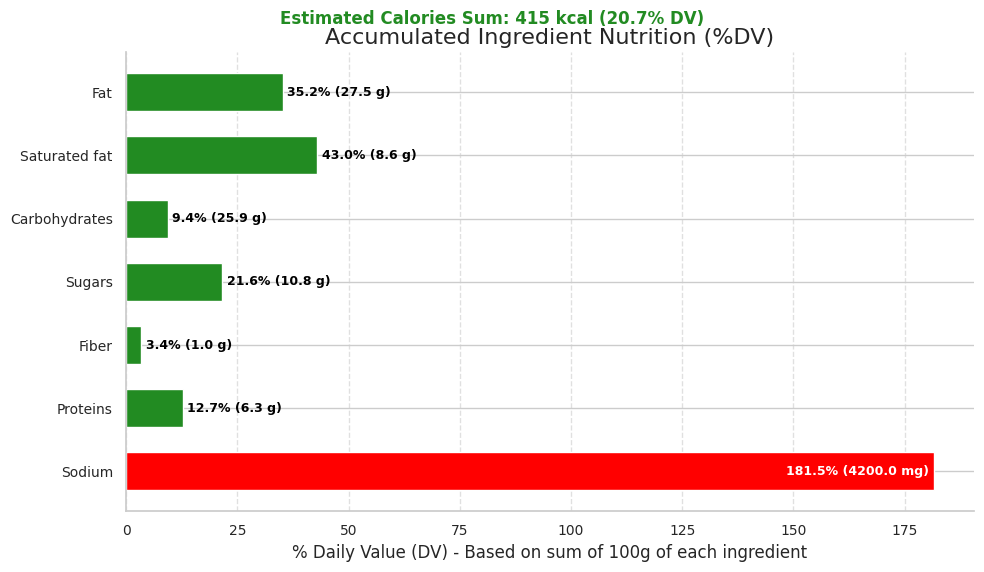

In [65]:
import re
import matplotlib.pyplot as plt
import numpy as np
from typing import Dict, List, Tuple

def extract_and_visualize_nutrition(response_text: str):
    """
    Extracts accumulated nutrition data from LLM response text and
    visualizes it as a color-coded horizontal bar chart (% Daily Value).

    Args:
        response_text: The string output from the LLM containing recipe details.
    """

    # --- 1. Extraction using Regex ---
    nutrition_section_match = re.search(
        r"\*\*Ingredient Nutrition:\*\*\s*\n(.*?)(?:\n\n|$)",
        response_text,
        re.DOTALL | re.IGNORECASE
    )

    if not nutrition_section_match:
        print("Could not find the 'Ingredient Nutrition:' section in the text.")
        return

    nutrition_text = nutrition_section_match.group(1).strip()

    # Regex to capture individual ingredient lines and their key-value pairs
    # Handles potential variations in spacing and key names slightly
    ingredient_pattern = re.compile(
        r"^\s*\*\s+\*\*(?P<ingredient>.*?):\*\*\s+(?P<data>.*?)$",
        re.MULTILINE
    )
    kv_pattern = re.compile(r"([\w_]+)\s*=\s*'?([^,']+)'?") # Capture key=value or key='value'

    accumulated_nutrition: Dict[str, float] = {
        "calories_100g": 0.0,
        "fat_100g": 0.0,
        "saturated_fat_100g": 0.0,
        "carbohydrates_100g": 0.0,
        "sugars_100g": 0.0,
        "fiber_100g": 0.0,
        "proteins_100g": 0.0,
        "sodium_100g": 0.0, # Keep in grams initially for consistency here
    }
    
    processed_ingredients = 0
    unavailable_ingredients = []
    # Track ingredient counts per nutrient for averaging
    nutrient_counts = {key: 0 for key in accumulated_nutrition.keys()}

    for match in ingredient_pattern.finditer(nutrition_text):
        ingredient_name = match.group("ingredient").strip()
        data_str = match.group("data").strip()

        # Check if this ingredient reported an error/unavailability
        if "status=" in data_str.lower() and "unavailable" in data_str.lower():
             unavailable_ingredients.append(ingredient_name)
             print(f"Skipping unavailable/error data for ingredient: {ingredient_name}")
             continue # Skip to next ingredient

        ingredient_data = dict(kv_pattern.findall(data_str))
        
        valid_data_found = False
        for key, value_str in ingredient_data.items():
            # Normalize key (remove _100g suffix if present for matching)
            norm_key = key.replace('_100g', '') + '_100g' 

            if norm_key in accumulated_nutrition:
                try:
                    # Convert value to float, handle potential errors
                    value = float(value_str)
                    # Only count non-zero values for water and other ingredients
                    if value > 0 or (ingredient_name.lower() != 'water' and norm_key != 'calories_100g'):
                        accumulated_nutrition[norm_key] += value
                        nutrient_counts[norm_key] += 1
                    valid_data_found = True
                except ValueError:
                    print(f"Warning: Could not convert value '{value_str}' for key '{key}' in ingredient '{ingredient_name}' to float. Skipping.")
            # else: # Uncomment if you want to see keys that weren't accumulated
            #     print(f"Info: Key '{key}' from '{ingredient_name}' not in accumulation list.")

        if valid_data_found:
             processed_ingredients += 1
             
    if processed_ingredients == 0:
         print("No valid nutrition data found to accumulate or plot.")
         if unavailable_ingredients:
              print(f"Unavailable ingredients: {', '.join(unavailable_ingredients)}")
         return

    # Calculate averages for each nutrient based on the number of ingredients that contributed values
    average_nutrition = {}
    for key, value in accumulated_nutrition.items():
        count = nutrient_counts[key]
        if count > 0:
            average_nutrition[key] = value / count
        else:
            average_nutrition[key] = 0.0
    
    print(f"Processed {processed_ingredients} ingredients.")
    if unavailable_ingredients:
         print(f"Note: Could not get data for: {', '.join(unavailable_ingredients)}")
    print("Average nutrition values:", average_nutrition)
    print("Nutrition counts (ingredients contributing to each value):", nutrient_counts)


    # --- 2. Normalization to % Daily Value (DV) ---
    # Reference Daily Values (adjust based on your target audience/standard, e.g., FDA)
    # Using FDA values as an example (approximated where needed)
    # Note: These DVs are for a *total daily diet*, using the average values
    #       per 100g of ingredient is more representative than using the sum.
    daily_values = {
        "calories_100g": 2000,  # kcal
        "fat_100g": 78,      # g
        "saturated_fat_100g": 20, # g
        "carbohydrates_100g": 275,# g
        "sugars_100g": 50,     # g (Reference for Added Sugars, using as proxy)
        "fiber_100g": 28,      # g
        "proteins_100g": 50,    # g
        "sodium_100g": 2.3,    # g (Note: DV is 2300mg = 2.3g)
    }

    percent_dv: Dict[str, float] = {}
    actual_values: Dict[str, float] = {} # Store the raw average values

    for key, avg_value in average_nutrition.items():
        dv = daily_values.get(key)
        if dv is not None and dv > 0:
            percent_dv[key] = round((avg_value / dv) * 100, 1)
            actual_values[key] = round(avg_value, 1)
        elif dv == 0 and avg_value == 0 : # Handle cases like 0 sodium DV if needed (though DV is non-zero)
             percent_dv[key] = 0.0 
             actual_values[key] = 0.0
        else:
            # Handle cases where DV isn't defined or is zero (shouldn't happen with above DVs)
            percent_dv[key] = 0.0 # Or handle as error/skip
            actual_values[key] = round(total_value, 1)
            print(f"Warning: No Daily Value defined or DV is zero for {key}. Cannot calculate %DV.")
            
    # Separate Calories as it has a different unit (kcal) and scale
    calories_percent_dv = percent_dv.pop("calories_100g", 0.0)
    calories_actual = actual_values.pop("calories_100g", 0.0)
    
    # Prepare data for plotting (nutrients other than calories)
    labels = list(percent_dv.keys())
    # Clean labels for display
    display_labels = [
        l.replace('_100g', '').replace('_', ' ').capitalize() 
        for l in labels
    ] 
    values = list(percent_dv.values())

    # --- 3. Color Coding ---
    colors = []
    # Define thresholds for %DV (adjust as needed)
    # Green: <= 50% DV
    # Orange: > 50% and <= 100% DV
    # Red: > 100% DV
    for v in values:
        if v <= 50:
            colors.append('forestgreen')
        elif v <= 100:
            colors.append('orange')
        else:
            colors.append('red')

    # --- 4. Plotting ---
    fig, ax = plt.subplots(figsize=(10, 6)) # Adjusted figure size

    # Create horizontal bars
    bars = ax.barh(display_labels, values, color=colors, height=0.6)

    # Add labels and title
    ax.set_xlabel('% Daily Value (DV) - Based on sum of 100g of each ingredient')
    ax.set_title('Accumulated Ingredient Nutrition (%DV)', fontsize=16)
    ax.tick_params(axis='y', labelsize=10)
    ax.tick_params(axis='x', labelsize=10)

    # Add value labels on the bars
    for i, bar in enumerate(bars):
        width = bar.get_width()
        # Get the actual gram/mg value for annotation
        nutrient_key = labels[i]
        actual_val = actual_values.get(nutrient_key, 0.0)
        unit = 'mg' if nutrient_key == 'sodium_100g' else 'g'
        if nutrient_key == 'sodium_100g':
            actual_val *= 1000 # Convert sodium back to mg for display clarity
            
        label_text = f'{width:.1f}% ({actual_val:.1f} {unit})'
        
        # Position label - inside if bar is long enough, otherwise outside
        x_pos = width + 1 if width < 90 else width - 1 # Adjust positioning threshold
        ha = 'left' if width < 90 else 'right'
        color = 'black' if width < 90 else 'white'

        ax.text(x_pos, bar.get_y() + bar.get_height()/2., label_text,
                ha=ha, va='center', color=color, fontsize=9, fontweight='bold')

    # Add Calorie Information separately
    cal_color = 'forestgreen' if calories_percent_dv <= 50 else ('orange' if calories_percent_dv <= 100 else 'red')
    calorie_text = f'Estimated Calories Sum: {calories_actual:.0f} kcal ({calories_percent_dv:.1f}% DV)'
    # Add text annotation for calories at the top or bottom
    fig.text(0.5, 0.95, calorie_text, ha='center', va='top', fontsize=12, color=cal_color, fontweight='bold')

    # Adjust layout and display
    plt.gca().invert_yaxis() # Display top-to-bottom typically looks better
    plt.tight_layout(rect=[0, 0, 1, 0.95]) # Adjust layout to prevent title overlap
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Instead of plt.show(), you might want to save the figure in a web app context
    # plt.savefig('nutrition_chart.png')
    plt.show()




# Run the function with the example text
extract_and_visualize_nutrition(response.text)

In [30]:
# And now re-run the same query with search grounding enabled.
config_with_search = types.GenerateContentConfig(
    tools=[types.Tool(google_search=types.GoogleSearch())],
)

def query_with_grounding():
    response = client.models.generate_content(
        model='gemini-2.0-flash',
        contents="What's a good substitute for eggs in Country White Bread or Dinner Rolls?",
        config=config_with_search,
    )
    return response.candidates[0]


rc = query_with_grounding()
Markdown(rc.content.parts[0].text)

When substituting eggs in country white bread or dinner rolls, it's important to consider the role the eggs play in the recipe. Eggs contribute to binding, moisture, richness, and a fine crumb. Here are several good substitutes, keeping those functions in mind:

**For Binding:**

*   **Flaxseed Meal (Flax Egg):** Mix 1 tablespoon of ground flaxseed with 3 tablespoons of water. Let it sit for about 5 minutes to form a gel. This works well as a binder.
*   **Chia Seeds (Chia Egg):** Similar to flaxseed, mix 1 tablespoon of chia seeds with 3 tablespoons of water and let it gel. White chia seeds won't add noticeable color.
*   **Aquafaba:** This is the liquid from a can of chickpeas. Use 3 tablespoons to replace one egg. It has emulsifying, binding, and thickening properties.
*   **Mashed Banana:** Use 1/4 cup of mashed ripe banana to replace one egg. Be aware that it will impart a banana flavor.
*   **Applesauce:** Use 1/4 cup of unsweetened applesauce per egg. It adds moisture and a hint of sweetness.
*   **Yogurt:** Use 1/4 cup of plain yogurt as a substitute, keeping in mind it might add a tangy flavor.

**For Leavening and Moisture:**

*   **Carbonated Water:** Use 1/4 cup of unflavored carbonated water to replace one egg. It can help create a moist and airy texture, but doesn't bind.
*   **Baking Powder, Water, and Oil:** Combine 2 teaspoons of baking powder, 2 tablespoons of water, and 1 teaspoon of vegetable oil to replace one egg.

**Other Options:**

*   **Pureed Sweet Potato:** Can replace the eggs and some of the liquid for a fine, soft crumb.
*   **Bean Cooking Liquid:** The liquid from cooked beans can also be used.
*   **Psyllium Husk Powder:** Especially useful in gluten-free baking to improve elasticity and texture.

**Important Considerations:**

*   **Adjusting Liquids:** When using substitutes, you may need to adjust the amount of other liquids in the recipe.
*   **Flavor Impact:** Some substitutes, like banana or applesauce, will affect the final flavor.
*   **Recipe Suitability:** The best substitute depends on the specific recipe and the number of eggs being replaced. Replacing one egg will be less noticeable than replacing multiple eggs.



In [39]:
fetch_nutrition_from_openfoodfacts("PEANUTS")

{'food_normalized': 'PEANUTS',
 'source': 'Open Food Facts',
 'product_name': "Menguy's Peanut 100%",
 'calories_100g': 610,
 'fat_100g': 48,
 'saturated_fat_100g': '5.8',
 'carbohydrates_100g': 13,
 'sugars_100g': '6.2',
 'fiber_100g': 7,
 'proteins_100g': 28,
 'sodium_100g': '0.02'}

In [61]:
# resp = chat.send_message("gluten free or vegeterian recipe but quick and easy")
# display(Markdown(resp.text))

## Step 2: Audio Input & Command Recognition with User Preferences

This notebook implements the second step of our Interactive Recipe & Kitchen Management Assistant capstone project for the Google Gen AI Intensive Course. We'll create a voice interface that allows users to interact with our recipe assistant through spoken commands, recognize different types of user requests, and maintain user preferences.



This step focuses on the **Audio understanding** Gen AI capability, which enables our assistant to:
- Process voice commands using Google Cloud Speech-to-Text
- Interpret user intent from natural language using Gemini Flash model
- Store and retrieve user preferences for personalized experiences

### Run your test prompt

In this step, you will test that your API key is set up correctly by making a request.

The Python SDK uses a [`Client` object](https://googleapis.github.io/python-genai/genai.html#genai.client.Client) to make requests to the API. The client lets you control which back-end to use (between the Gemini API and Vertex AI) and handles authentication (the API key).

The `gemini-2.0-flash` model has been selected here.

**Note**: If you see a `TransportError` on this step, you may need to **🔁 Factory reset** the notebook one time.

In [33]:
client = genai.Client(api_key=GOOGLE_API_KEY)

response = client.models.generate_content(
    model="gemini-2.0-flash",
    contents="Hi, This is a test message! How are you?")

print(response.text)

Hi there! I received your test message. I'm doing well, thank you for asking! How are you today? Is there anything I can help you with?



## Google Cloud Speech-to-Text API Setup

To use Google Cloud Speech-to-Text, we need to set up authentication and configure the client. In a production environment, this would involve creating a service account and downloading the credentials. For demonstration in a Kaggle/local environment, we'll simulate the API response.

> Note: In a real implementation, you would:
> 1. Create a Google Cloud project
> 2. Enable the Speech-to-Text API
> 3. Create a service account with appropriate permissions
> 4. Download the credentials JSON file
> 5. Set the `GOOGLE_APPLICATION_CREDENTIALS` environment variable to point to this file

## Speech-to-Text Conversion

Let's implement a real speech-to-text function using Google Cloud Speech-to-Text API. This will allow us to convert voice commands from audio files into text for processing. Unfortunately, the google STT needs a lot of parameters for configuration, for credential, and the auth section is headache! , I decided to move forward with lovely whisper-1 :D, sorry Google!

In [34]:
def transcribe_audio(service="openai", file_path=None, language="en", api_key=None, credentials_path=None, credentials_json=None):
    """
    Transcribe audio using either OpenAI or Google Cloud Speech-to-Text API.
    
    Args:
        service (str): The service to use for transcription ('openai' or 'google')
        file_path (str): Path to the audio file to transcribe
        language (str): Language code (e.g., 'en' for OpenAI, 'en-US' for Google)
        api_key (str): OpenAI API key (required for OpenAI service)
        credentials_path (str): Path to Google credentials JSON file (optional for Google service)
        credentials_json (str): JSON string of Google credentials (optional for Google service)
        
    Returns:
        str: Transcription text or error message
    """
    
    if not file_path:
        return "Error: No file path provided"
        
    if not os.path.exists(file_path):
        return f"Error: File not found at {file_path}"
    
    try:
        if service.lower() == "openai":
            if not api_key:
                return "Error: OpenAI API key required"
                
            client = OpenAI(api_key=api_key)
            
            with open(file_path, "rb") as audio_file:
                transcription = client.audio.transcriptions.create(
                    model="whisper-1", 
                    file=audio_file,
                    language=language
                )
            
            return transcription.text
            
        elif service.lower() == "google":
            temp_cred_file = None
            
            # Handle Google authentication
            if not credentials_path and not credentials_json:
                return "Error: Either credentials_path or credentials_json required for Google service"
            
            # If credentials_json is provided, write to a temporary file
            if credentials_json:
                try:
                    # Create a temporary file for credentials
                    temp_cred_file = tempfile.NamedTemporaryFile(delete=False, suffix='.json')
                    temp_cred_path = temp_cred_file.name
                    temp_cred_file.write(credentials_json.encode('utf-8'))
                    temp_cred_file.close()
                    
                    # Set environment variable to the temporary file
                    os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = temp_cred_path
                except Exception as e:
                    if temp_cred_file and os.path.exists(temp_cred_file.name):
                        os.unlink(temp_cred_file.name)
                    return f"Error creating temporary credentials file: {str(e)}"
            else:
                # Use provided credentials_path
                os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = credentials_path
            
            try:
                # Initialize the Speech client
                client = speech.SpeechClient()
                
                # Read the audio file
                with io.open(file_path, "rb") as audio_file:
                    content = audio_file.read()
                
                # Determine encoding based on file extension
                file_ext = os.path.splitext(file_path)[1].lower()
                if file_ext == ".ogg":
                    encoding = speech.RecognitionConfig.AudioEncoding.OGG_OPUS
                elif file_ext == ".wav":
                    encoding = speech.RecognitionConfig.AudioEncoding.LINEAR16
                else:
                    return f"Error: Unsupported file format: {file_ext}"
                
                # Configure the speech recognition
                audio = speech.RecognitionAudio(content=content)
                config = speech.RecognitionConfig(
                    encoding=encoding,
                    sample_rate_hertz=48000,  # May need adjustment based on actual audio file
                    language_code=language if language else "en-US",
                )
                
                # Perform the transcription
                response = client.recognize(config=config, audio=audio)
                
                # Extract the transcription
                if response.results:
                    return response.results[0].alternatives[0].transcript
                else:
                    return "No transcription results found"
                    
            finally:
                # Clean up temp file if it was created
                if temp_cred_file and os.path.exists(temp_cred_file.name):
                    os.unlink(temp_cred_file.name)
        
        else:
            return f"Error: Unknown service '{service}'. Use 'openai' or 'google'"
            
    except Exception as e:
        # Clean up temp file if exception occurs
        if service.lower() == "google" and temp_cred_file and os.path.exists(temp_cred_file.name):
            os.unlink(temp_cred_file.name)
        return f"Error during transcription: {str(e)}"

In [54]:
#OPENAI_API_KEY (openai) or  SecretValueJson (google)
transcribe_audio(service="openai", file_path="/home/snowholt/coding/python/google_capstone/voices/Nariman_1.ogg", language="en", api_key=OPENAI_API_KEY)

'Hi, how can I make a pizza, Italian pizza, in 30 minutes?'

## Implemented the Kitchen Management Assistant interface. The assistant provides a modern, interactive interface for users to either:


### Text Input
1. Click on the "Text Input" tab
2. Type your kitchen-related request in the text area
3. Click the "Submit" button
4. The system will process your text request

### Voice Selection
1. Click on the "Voice Selection" tab
2. Select a voice recording from the dropdown list
3. Click the "Transcribe Voice" button
4. The system will transcribe the audio and process the request



In [55]:
voices = {
  "version": "1.0",
  "voices": [
    {
      "file_path": "/kaggle/input/voice-tests/test.ogg",
      "language": "en",
      "description": "Voice instruction for baking a pizza",
      "speaker_id": "nariman",
      "is_processed": False
    },
    {
      "file_path": "voices/test.wav",
      "language": "en",
      "description": "Test voice recording for the system",
      "speaker_id": "user2",
      "is_processed": False
    },
  
    
  ]
}

## Building an agent with LangGraph (Final Step! yaaay!)

In [62]:
# Remove conflicting packages from the Kaggle base environment.
!pip uninstall -qqy kfp libpysal thinc spacy fastai ydata-profiling google-cloud-bigquery google-generativeai
# Install langgraph and the packages used in this lab.
!pip install -qU 'langgraph==0.3.21' 'langchain-google-genai==2.1.2' 'langgraph-prebuilt==0.1.7'

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [66]:
# Step 1: State Schema Definition

from typing import Annotated, List, Dict, Optional, Any, Sequence, Literal
from typing_extensions import TypedDict

from langchain_core.messages import BaseMessage, AIMessage, HumanMessage, ToolMessage
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph.message import add_messages




class KitchenState(TypedDict):
    """
    Represents the state of the conversation and actions within the
    Interactive Recipe & Kitchen Management Assistant agent.

    Attributes:
        messages: The history of messages in the conversation (human, AI, tool).
        user_input: The latest raw input from the user (text or transcribed audio).
        intent: The determined intent of the user's last message.
        search_params: Parameters extracted for recipe search actions.
        selected_recipe_id: The ID of the recipe currently being discussed or viewed.
        customization_request: Details of a requested recipe customization.
        nutrition_query: The ingredient or recipe name for a nutrition lookup.
        grounding_query: A specific question requiring web search grounding.
        search_results: A list of recipe summaries found by a search.
        current_recipe_details: Full details of the currently selected recipe.
        recipe_reviews: Ratings and reviews for the currently selected recipe.
        nutritional_info: Detailed nutritional breakdown (e.g., from Open Food Facts).
        grounding_results: Information retrieved from a web search.
        user_ingredients: A list of ingredients the user currently has available.
        dietary_preferences: The user's specified dietary restrictions or preferences.
        needs_clarification: Flag indicating if the agent requires more information.
        finished: Flag indicating if the conversation/task is complete.
        last_assistant_response: The last text response generated by the assistant for UI display.
        extract_and_visualize_nutrition:  Extracts accumulated nutrition data from LLM response text and visualizes it as a color-coded horizontal bar chart (% Daily Value).
    """
    # Conversation history (Human, AI, Tool messages)
    messages: Annotated[Sequence[BaseMessage], add_messages]

    # User's raw input (text or transcribed audio)
    user_input: Optional[str]

    # Parsed intent from user input
    intent: Optional[str] # e.g., 'search_recipe', 'get_details', 'customize', 'nutrition', 'general_chat', 'grounding_query', 'exit'

    # Parameters extracted for specific actions
    search_params: Optional[Dict[str, Any]] # {'query_text', 'cuisine', 'dietary_tag', 'max_minutes'}
    selected_recipe_id: Optional[str]
    customization_request: Optional[str]
    nutrition_query: Optional[str] # Ingredient or recipe name
    grounding_query: Optional[str] # Question for web search

    # Data retrieved by tools/nodes
    search_results: Optional[List[Dict[str, Any]]] # List of recipe summaries from search
    current_recipe_details: Optional[Dict[str, Any]] # Full details of selected recipe
    recipe_reviews: Optional[Dict[str, Any]] # Ratings and reviews
    nutritional_info: Optional[Dict[str, Any]] # Fetched nutrition data
    grounding_results: Optional[str] # Results from web search

    # User Context (Could be loaded/persisted separately in a full implementation)
    user_ingredients: List[str] # Ingredients the user has
    dietary_preferences: List[str] # e.g., ['vegetarian', 'gluten-free']

    # Control Flow
    needs_clarification: bool # Flag if agent needs more info from user
    finished: bool # Flag indicating end of conversation
    last_assistant_response: Optional[str] # Store the last text response for UI display

# Example of initializing the state (optional, for testing)
initial_state: KitchenState = {
    "messages": [],
    "user_input": None,
    "intent": None,
    "search_params": None,
    "selected_recipe_id": None,
    "customization_request": None,
    "nutrition_query": None,
    "grounding_query": None,
    "search_results": None,
    "current_recipe_details": None,
    "recipe_reviews": None,
    "nutritional_info": None,
    "grounding_results": None,
    "user_ingredients": [],
    "dietary_preferences": [],
    "needs_clarification": False,
    "finished": False,
    "last_assistant_response": None,
    "extract_and_visualize_nutrition": None,
}

In [72]:
# Step 2: System Instructions & Core Nodes

import os
from typing import Annotated, List, Dict, Optional, Any, Sequence, Literal
from typing_extensions import TypedDict

from langchain_core.messages import BaseMessage, AIMessage, HumanMessage, ToolMessage
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph.message import add_messages

# --- Assume KitchenState is defined as in Step 1 ---
class KitchenState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]
    user_input: Optional[str]
    intent: Optional[str]
    search_params: Optional[Dict[str, Any]]
    selected_recipe_id: Optional[str]
    customization_request: Optional[str]
    nutrition_query: Optional[str]
    grounding_query: Optional[str]
    search_results: Optional[List[Dict[str, Any]]]
    current_recipe_details: Optional[Dict[str, Any]]
    recipe_reviews: Optional[Dict[str, Any]]
    nutritional_info: Optional[Dict[str, Any]]
    grounding_results: Optional[str]
    user_ingredients: List[str]
    dietary_preferences: List[str]
    needs_clarification: bool
    finished: bool
    last_assistant_response: Optional[str]
# --- End State Definition ---

# --- API Key Setup (Ensure GOOGLE_API_KEY is set) ---
# Assuming GOOGLE_API_KEY is loaded from secrets or environment
# GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")
# os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY
# --- End API Key Setup ---


# --- System Instructions ---
KITCHEN_ASSISTANT_SYSINT = (
    "system",
    """You are a helpful, friendly, and knowledgeable Interactive Recipe & Kitchen Management Assistant.
Your capabilities include:
- **Recipe Discovery:** Find recipes based on ingredients, cuisine type, dietary needs (vegetarian, vegan, gluten-free, low-carb, dairy-free), cooking time, or general search terms. Use the `gemini_recipe_similarity_search` tool.
- **Recipe Details:** Provide full recipe details including name, description, ingredients, steps, cooking time, contributor, tags, cuisine, and dietary tags using the `get_recipe_by_id` tool.
- **Ratings & Reviews:** Fetch the overall rating and recent user reviews for a recipe using the `get_ratings_and_reviews_by_recipe_id` tool. **You MUST specify an integer for the 'limit' parameter (e.g., limit=3 if the user doesn't specify).**
- **Nutrition Information:** Look up nutritional information (per 100g) for specific ingredients using the `fetch_nutrition_from_openfoodfacts` tool. You can also calculate approximate nutritional info for a full recipe after getting its details.
- **Recipe Customization:** Modify recipes based on dietary needs or ingredient substitutions (this will involve more complex reasoning, potentially using few-shot examples later).
- **Grounding:** Answer general cooking questions or find ingredient substitutes using the `google_search` tool if the information isn't in the internal database.

Interaction Flow:
1.  Understand the user's request (intent and parameters).
2.  If it's a specific action requiring a tool, prepare the tool call.
3.  If it's general chat or you need clarification, respond directly.
4.  If information is missing for a tool call (e.g., recipe ID for details), ask the user for clarification.
5.  When presenting information (search results, recipe details, nutrition), format it clearly.
6.  Always be polite and helpful. If you cannot fulfill a request, explain why.
7.  Keep the conversation focused on recipes, cooking, ingredients, and nutrition. Politely decline off-topic requests.
8.  When using `get_ratings_and_reviews_by_recipe_id`, **always** include the `limit` argument (default to 3 if not specified by user).
9.  The `get_recipe_by_id` tool fetches structured data; the `fetch_nutrition_from_openfoodfacts` tool fetches live data for *individual* ingredients listed within the recipe details when that tool is called. You might need to call `fetch_nutrition_from_openfoodfacts` multiple times within the `NutritionAnalysisNode` later.

Available Tools (for intent recognition and potential calling):
- gemini_recipe_similarity_search(query_text: str, n_results: int, cuisine: Optional[str] = None, dietary_tag: Optional[str] = None, max_minutes: Optional[int] = None)
- gemini_interaction_similarity_search(query_text: str, n_results: int)
- get_recipe_by_id(recipe_id: str)
- get_ratings_and_reviews_by_recipe_id(recipe_id: str, limit: int)
- fetch_nutrition_from_openfoodfacts(ingredient_name: str)
- google_search(query: str)
- # Potentially tools for customization or state updates later
"""
)

# --- LLM Initialization ---
# Using gemini-2.0-flash as it's generally good with tool use and reasoning
# Bind the tools conceptually here for the parser LLM, even if execution is separate
# Note: Actual tool definitions (@tool decorator) are needed for LangGraph's ToolNode later
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash", convert_system_message_to_human=True)
db_tools = [list_tables, describe_table, execute_query, get_ratings_and_reviews_by_recipe_id, get_recipe_by_id, fetch_nutrition_from_openfoodfacts, gemini_interaction_similarity_search, gemini_recipe_similarity_search]
llm_for_parser = llm.bind_tools(db_tools) #  db_tools holds the tool definitions from capstone notebook

# --- Core Nodes ---

def input_parser_node(state: KitchenState) -> Dict[str, Any]:
    """
    Parses the user's latest input to determine intent and extract parameters.
    Handles simple chat responses if no specific action/tool is identified.
    """
    print("---PARSING USER INPUT---")
    messages = state['messages']
    last_user_message = messages[-1]

    # Prepare messages for the LLM (including system prompt)
    # We might only need the last few messages for context, depending on complexity
    context_messages = [KITCHEN_ASSISTANT_SYSINT] + list(messages)

    # Invoke the LLM to get intent, parameters, or a direct response
    # In a full implementation, you'd bind the actual tools here for function calling
    # For now, we simulate the LLM determining intent based on keywords (simplified)
    # A real implementation would use llm.invoke(context_messages) and parse the AIMessage for tool calls or content

    user_text = last_user_message.content.lower()
    intent = "general_chat"
    search_params = None
    selected_recipe_id = None
    customization_request = None
    nutrition_query = None
    grounding_query = None
    needs_clarification = False
    ai_response_content = None

    # --- Simplified Intent Recognition (Replace with LLM call in full implementation) ---
    if "search for" in user_text or "find recipe" in user_text or "recipes with" in user_text:
        intent = "search_recipe"
        # Parameter extraction would happen here via LLM or regex
        search_params = {"query_text": last_user_message.content, "n_results": 5} # Example
        print(f"Intent: {intent}, Params: {search_params}")
    elif "details for recipe" in user_text or "tell me about recipe" in user_text:
        intent = "get_details"
        # Extract recipe ID (simplified)
        match = re.search(r'\d+', user_text)
        if match:
            selected_recipe_id = match.group(0)
            print(f"Intent: {intent}, Recipe ID: {selected_recipe_id}")
        else:
            needs_clarification = True
            ai_response_content = "Which recipe ID would you like details for?"
            intent = "clarification_needed" # Or handle directly
    elif "nutrition for" in user_text or "calories in" in user_text:
         intent = "nutrition"
         # Extract query (simplified)
         parts = user_text.split(" for ")
         if len(parts) > 1:
             nutrition_query = parts[-1].strip()
             print(f"Intent: {intent}, Query: {nutrition_query}")
         else:
             needs_clarification = True
             ai_response_content = "What ingredient or recipe would you like nutrition information for?"
             intent = "clarification_needed"
    elif "reviews for recipe" in user_text:
        intent = "get_reviews" # We'll use the get_ratings_and_reviews tool
        match = re.search(r'\d+', user_text)
        if match:
            selected_recipe_id = match.group(0)
            print(f"Intent: {intent}, Recipe ID: {selected_recipe_id}")
        else:
            needs_clarification = True
            ai_response_content = "Which recipe ID would you like reviews for?"
            intent = "clarification_needed"
    elif "customize" in user_text or "substitute" in user_text or "make it vegan" in user_text:
        intent = "customize"
        customization_request = last_user_message.content
        # Need selected_recipe_id to be set from previous context or ask
        if not state.get("selected_recipe_id"):
             needs_clarification = True
             ai_response_content = "Which recipe would you like to customize?"
             intent = "clarification_needed"
        else:
            selected_recipe_id = state.get("selected_recipe_id") # Assume it's in state
            print(f"Intent: {intent}, Request: {customization_request} for Recipe ID: {selected_recipe_id}")
    elif "what is" in user_text or "how do i" in user_text or "substitute for" in user_text:
         # Could be a grounding query if not about a specific recipe in context
         intent = "grounding_query"
         grounding_query = last_user_message.content
         print(f"Intent: {intent}, Query: {grounding_query}")
    elif user_text in {"q", "quit", "exit", "goodbye"}:
        intent = "exit"
        print(f"Intent: {intent}")
    else:
        # Default to general chat - LLM generates response
        print(f"Intent: {intent}")
        # ai_response = llm.invoke(context_messages) # Simulate LLM chat response
        # ai_response_content = ai_response.content
        ai_response_content = f"Okay, you said: '{last_user_message.content}'. How else can I help with recipes today?" # Placeholder response

    # --- End Simplified Logic ---

    updates = {
        "intent": intent,
        "search_params": search_params,
        "selected_recipe_id": selected_recipe_id,
        "customization_request": customization_request,
        "nutrition_query": nutrition_query,
        "grounding_query": grounding_query,
        "needs_clarification": needs_clarification,
        # Clear previous results
        "search_results": None,
        "current_recipe_details": None,
        "recipe_reviews": None,
        "nutritional_info": None,
        "grounding_results": None,
        "last_assistant_response": None,
    }

    # If the LLM generated a direct response (no tool needed or clarification)
    if ai_response_content:
        updates["messages"] = [AIMessage(content=ai_response_content)]
        updates["last_assistant_response"] = ai_response_content # Store for UI

    # In a real implementation with function calling:
    response = llm_for_parser.invoke(context_messages)
    if response.tool_calls:
        updates["messages"] = [response] # Pass the AIMessage with tool_calls
        updates["intent"] = "tool_call" # Signal to router
    elif response.content:
        updates["messages"] = [response]
        updates["last_assistant_response"] = response.content
        updates["intent"] = "general_chat" # Or determined intent if no tool needed
    else: # Handle errors or no response
        updates["messages"] = [AIMessage(content="Sorry, I couldn't process that.")]
        updates["last_assistant_response"] = "Sorry, I couldn't process that."
        updates["intent"] = "error"

    # Filter out None values before returning the update dictionary
    return {k: v for k, v in updates.items() if v is not None}


def human_input_node(state: KitchenState) -> Dict[str, Any]:
    """Handles getting input from the user."""
    print("---WAITING FOR USER INPUT---")
    last_response = state.get("last_assistant_response")
    if last_response:
        print(f"Assistant: {last_response}")
        # Clear the last response after displaying it
        state["last_assistant_response"] = None

    user_input = input("You: ")
    finished = False
    if user_input.lower() in {"q", "quit", "exit", "goodbye"}:
        finished = True

    return {"user_input": user_input, "messages": [HumanMessage(content=user_input)], "finished": finished}


def response_formatter_node(state: KitchenState) -> Dict[str, Any]:
    """Formats results from action nodes into a natural language response."""
    print("---FORMATTING RESPONSE---")
    intent = state.get("intent")
    ai_response_content = "I'm not sure how to respond to that." # Default

    # Check which data field is populated and format accordingly
    # This node could also use an LLM call for more sophisticated formatting/summarization
    if state.get("search_results"):
        ai_response_content = "Here are some recipes I found:\n"
        for i, recipe in enumerate(state["search_results"]):
             # Ensure 'name' and 'id' exist, provide defaults if not
             name = recipe.get('name', 'Unnamed Recipe')
             recipe_id = recipe.get('recipe_id', 'N/A')
             ai_response_content += f"{i+1}. {name} (ID: {recipe_id})\n"
        ai_response_content += "\nLet me know if you'd like details on any of these."
        # Clear the results after formatting
        state["search_results"] = None
    elif state.get("current_recipe_details"):
        details = state["current_recipe_details"]
        reviews = state.get("recipe_reviews")
        nutrition = state.get("nutritional_info") # Nutrition might be added here or after this node

        name = details.get('name', 'N/A')
        desc = details.get('description', 'No description available.')
        ingredients = details.get('ingredients', [])
        steps = details.get('steps', [])
        rating = reviews.get('overall_rating', 'N/A') if reviews else 'N/A'
        recent_reviews_list = reviews.get('recent_reviews', []) if reviews else []

        ai_response_content = f"**Recipe: {name} (ID: {details.get('id', 'N/A')})**\n\n"
        ai_response_content += f"*Description:* {desc}\n\n"
        ai_response_content += "**Ingredients:**\n" + "\n".join([f"- {ing}" for ing in ingredients]) + "\n\n"
        ai_response_content += "**Steps:**\n" + "\n".join([f"{i+1}. {step}" for i, step in enumerate(steps)]) + "\n\n"

        if nutrition: # If nutrition node ran *before* formatter
            ai_response_content += "**Approximate Nutrition (per 100g average of ingredients):**\n"
            # Format nutrition nicely
            for key, val in nutrition.items():
                 if key not in ['status', 'reason', 'source', 'product_name', 'food_normalized']:
                     ai_response_content += f"- {key.replace('_100g', '').replace('_', ' ').title()}: {val}\n"
            ai_response_content += "\n"

        ai_response_content += f"**Overall Rating:** {rating:.1f}/5.0\n" if isinstance(rating, (int, float)) else "**Overall Rating:** N/A\n"
        if recent_reviews_list:
            ai_response_content += "**Recent Reviews:**\n"
            for rev in recent_reviews_list:
                ai_response_content += f"- Rating {rev.get('rating', 'N/A')}: {rev.get('review', 'No text')[:100]}...\n" # Truncate long reviews

        # Clear the results after formatting
        state["current_recipe_details"] = None
        state["recipe_reviews"] = None
        state["nutritional_info"] = None # Clear nutrition if formatted here
    elif state.get("nutritional_info") and not state.get("current_recipe_details"): # Nutrition query for single ingredient
        nutrition = state["nutritional_info"]
        query = state.get("nutrition_query", "the ingredient")
        if nutrition.get("status") == "unavailable":
            ai_response_content = f"Sorry, I couldn't find detailed nutrition data for '{query}'. Reason: {nutrition.get('reason', 'Unknown')}"
        else:
            ai_response_content = f"Here's the approximate nutrition for **{query}** (per 100g, from {nutrition.get('source', 'source')}):\n"
            for key, val in nutrition.items():
                 if key not in ['status', 'reason', 'source', 'product_name', 'food_normalized']:
                     ai_response_content += f"- {key.replace('_100g', '').replace('_', ' ').title()}: {val}\n"
        # Clear the results
        state["nutritional_info"] = None
        state["nutrition_query"] = None
    elif state.get("grounding_results"):
        ai_response_content = f"Here's what I found on the web:\n\n{state['grounding_results']}"
        # Clear the results
        state["grounding_results"] = None
    elif state.get("intent") == "general_chat" and state["messages"][-1].type == "ai":
         # If the parser node already generated a chat response, use it
         ai_response_content = state["messages"][-1].content
    elif state.get("intent") == "clarification_needed" and state["messages"][-1].type == "ai":
         # If the parser node asked for clarification
         ai_response_content = state["messages"][-1].content
    elif state.get("intent") == "exit":
        ai_response_content = "Okay, goodbye! Let me know if you need help with recipes again."
    # Add more formatting logic for customization results etc.

    # Update state
    updates = {
        "messages": [AIMessage(content=ai_response_content)],
        "last_assistant_response": ai_response_content,
        "intent": None, # Reset intent after formatting
        "needs_clarification": False # Reset clarification flag
    }
    return {k: v for k, v in updates.items() if v is not None}

In [36]:
# Step 3: Tool Definition and Integration

import os
import re
import sqlite3
import json
import requests
import chromadb
import pandas as pd
import numpy as np
from typing import Annotated, List, Dict, Optional, Any, Sequence, Tuple
from typing_extensions import TypedDict

from langchain_core.messages import BaseMessage, AIMessage, HumanMessage, ToolMessage, SystemMessage
from langchain_core.tools import tool
from langchain_google_genai import ChatGoogleGenerativeAI
# Assuming google_search tool needs to be defined or imported
# from langchain_community.tools import GoogleSearchRun # Example if using langchain community tools
# from langchain_google_community import GoogleSearchAPIWrapper # Example
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode

# --- Assume KitchenState is defined as in Step 1 ---
class KitchenState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]
    user_input: Optional[str]
    intent: Optional[str]
    search_params: Optional[Dict[str, Any]]
    selected_recipe_id: Optional[str]
    customization_request: Optional[str]
    nutrition_query: Optional[str]
    grounding_query: Optional[str]
    search_results: Optional[List[Dict[str, Any]]]
    current_recipe_details: Optional[Dict[str, Any]]
    recipe_reviews: Optional[Dict[str, Any]]
    nutritional_info: Optional[Dict[str, Any]]
    grounding_results: Optional[str]
    user_ingredients: List[str]
    dietary_preferences: List[str]
    needs_clarification: bool
    finished: bool
    last_assistant_response: Optional[str]
# --- End State Definition ---

# --- Database/Vector Store Paths (Ensure these are accessible) ---
VECTOR_DB_PATH = "final/vector_db"
DB_PATH = "final/kitchen_db.sqlite"
# --- End Paths ---

# --- API Key Setup (Ensure GOOGLE_API_KEY is set) ---
# Assuming GOOGLE_API_KEY is loaded from secrets or environment
# GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")
# os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY
# --- End API Key Setup ---

# --- Helper Function (from capstone notebook) ---
def safe_convert(x):
    if isinstance(x, (list, np.ndarray)):
        return " ".join([str(item) for item in x])
    return str(x) if pd.notna(x) else ""
# --- End Helper Function ---

# --- Tool Definitions (Stateless Tools from capstone notebook) ---

@tool
def gemini_recipe_similarity_search(query_text: str, n_results: int, cuisine: Optional[str] = None, dietary_tag: Optional[str] = None, max_minutes: Optional[int] = None) -> str:
    """
    Searches for similar recipes based on a query, with optional filters (cuisine, dietary_tag, max_minutes) and returns metadata.
    """
    try:
        client = chromadb.PersistentClient(path=VECTOR_DB_PATH)
        recipe_collection = client.get_collection(name="recipes")

        where_clause = {}
        where_documents_clause = None # ChromaDB uses where_documents for text content search if needed, but we query embeddings primarily.

        # Build metadata filters
        if cuisine:
            where_clause["cuisine_type"] = cuisine
        if dietary_tag:
            # Assuming dietary_tags is stored as a space-separated string after preprocessing
            where_clause["dietary_tags"] = {"$contains": dietary_tag}
        if max_minutes:
             # Ensure comparison is appropriate (numeric if stored as number, string otherwise)
             # The setup_vector_database saved it as string, so compare as string or adjust storage.
             # For simplicity, let's assume it might need numeric comparison if stored differently later.
             # We'll stick to string comparison based on the provided setup code.
             try:
                 # Attempt numeric comparison if needed in future, requires schema change
                 # where_clause["minutes"] = {"$lte": int(max_minutes)}
                 # For now, using string comparison based on setup:
                 where_clause["minutes"] = {"$lte": str(max_minutes)}
             except ValueError:
                 return f"Error: max_minutes must be an integer. Got: {max_minutes}"


        print(f"DEBUG: ChromaDB Query - Query Texts: ['{query_text}'], N Results: {n_results}, Where: {where_clause or None}")

        results = recipe_collection.query(
            query_texts=[query_text],
            n_results=n_results,
            where=where_clause if where_clause else None,
            # where_document=where_documents_clause if where_documents_clause else None, # Use if searching document content
            include=["documents", "metadatas", "distances"]
        )

        if not results or not results.get('ids') or not results['ids'][0]:
            return f"No similar recipes found for the query: '{query_text}' with the specified criteria."

        output = f"Found {len(results['ids'][0])} similar recipes for query: '{query_text}'.\n"
        output += "-" * 80 + "\n"
        for i, (doc_id, metadata, distance) in enumerate(zip(
            results['ids'][0],
            results['metadatas'][0],
            results['distances'][0]
        )):
            similarity_score = (1 - distance) * 100 # Example conversion, distance metric might vary
            output += f"\n{i+1}. Recipe Name: {metadata.get('name', 'Unnamed')}\n"
            output += f"   Similarity: {similarity_score:.2f}% (Distance: {distance:.4f})\n" # Show distance too
            output += f"   Recipe ID: {metadata.get('recipe_id', doc_id)}\n" # Use metadata ID if available
            output += f"   Minutes: {metadata.get('minutes', 'N/A')}\n"
            output += f"   Cuisine: {metadata.get('cuisine_type', 'N/A')}\n"
            output += f"   Dietary Tags: {metadata.get('dietary_tags', 'N/A')}\n"
            # Add other key metadata as needed
            output += "-" * 80 + "\n"

        return output

    except Exception as e:
        return f"Error during recipe similarity search: {e}"

@tool
def gemini_interaction_similarity_search(query_text: str, n_results: int) -> str:
    """
    Searches for similar user interactions (reviews) based on a query text and returns review details.
    """
    try:
        client = chromadb.PersistentClient(path=VECTOR_DB_PATH)
        # Ensure the collection name matches the one created in setup_vector_database
        interactions_collection = client.get_collection(name="interactions")

        print(f"DEBUG: ChromaDB Query - Query Texts: ['{query_text}'], N Results: {n_results}, Collection: interactions")

        results = interactions_collection.query(
            query_texts=[query_text],
            n_results=n_results,
            include=["documents", "metadatas", "distances"]
        )

        if not results or not results.get('ids') or not results['ids'][0]:
            return f"No similar reviews found for the query: '{query_text}'."

        output = f"Found {len(results['ids'][0])} similar reviews for query: '{query_text}'.\n"
        output += "-" * 80 + "\n"
        for i, (doc_id, doc, metadata, distance) in enumerate(zip(
            results['ids'][0],
            results['documents'][0],
            results['metadatas'][0],
            results['distances'][0]
        )):
            similarity_score = (1 - distance) * 100
            output += f"\n{i+1}. Interaction ID: {metadata.get('interaction_id', doc_id)}\n" # Use metadata ID
            output += f"   Similarity: {similarity_score:.2f}% (Distance: {distance:.4f})\n"
            output += f"   Recipe ID: {metadata.get('recipe_id', 'N/A')}\n"
            output += f"   User ID: {metadata.get('user_id', 'N/A')}\n"
            output += f"   Rating: {metadata.get('rating', 'N/A')}\n"
            output += f"   Date: {metadata.get('date', 'N/A')}\n"
            output += f"   Review Text: {doc}\n"
            output += "-" * 80 + "\n"

        return output

    except ValueError:
        # This specific error often means the collection doesn't exist
        return "Interactions collection not found. Make sure interaction data was loaded into ChromaDB."
    except Exception as e:
        return f"Error during interaction similarity search: {e}"

@tool
def get_recipe_by_id(recipe_id: str) -> str:
    """
    Get a recipe by its ID from the SQL database. Returns structured data as a JSON string.
    Does NOT fetch live nutrition data; use fetch_nutrition_from_openfoodfacts for that.
    """
    conn = sqlite3.connect(DB_PATH)
    cursor = conn.cursor()
    try:
        print(f"DEBUG: SQL Query - Fetching recipe with ID: {recipe_id}")
        cursor.execute("SELECT * FROM recipes WHERE id = ?", (recipe_id,))
        recipe_data = cursor.fetchone()

        if not recipe_data:
            return f"Recipe with ID {recipe_id} not found."

        columns = [col[0] for col in cursor.description]
        recipe_dict = dict(zip(columns, recipe_data))

        # Attempt to parse list-like fields stored as strings back into lists for better structure
        for field in ["ingredients", "steps", "tags", "dietary_tags", "normalized_ingredients", "nutrition"]:
             if field in recipe_dict and isinstance(recipe_dict[field], str):
                 try:
                     # Try eval for list-like strings '[...]' or '...'
                     parsed_value = eval(recipe_dict[field])
                     if isinstance(parsed_value, list):
                          recipe_dict[field] = parsed_value
                 except:
                      # If eval fails, try splitting space-separated strings for specific fields
                      if field in ["ingredients", "tags", "dietary_tags", "normalized_ingredients"]:
                           recipe_dict[field] = recipe_dict[field].split()
                      # Keep as string otherwise (e.g., description, potentially steps if not list format)

        # Return as JSON string for the LLM/Agent
        return json.dumps(recipe_dict, indent=2)

    except sqlite3.Error as e:
        return f"Error executing SQL query for recipe ID {recipe_id}: {e}"
    except Exception as e:
        return f"An unexpected error occurred fetching recipe ID {recipe_id}: {e}"
    finally:
        conn.close()

@tool
def get_ratings_and_reviews_by_recipe_id(recipe_id: str, limit: int) -> str:
    """
    Get overall rating and the most recent reviews (up to 'limit') for a recipe ID from the SQL database.
    Returns structured data as a JSON string.
    """
    if not isinstance(limit, int) or limit <= 0:
        return "Error: 'limit' parameter must be a positive integer."

    conn = sqlite3.connect(DB_PATH)
    cursor = conn.cursor()
    try:
        print(f"DEBUG: SQL Query - Fetching reviews for Recipe ID: {recipe_id}, Limit: {limit}")
        # Get overall rating
        cursor.execute("SELECT AVG(rating) FROM interactions WHERE recipe_id = ?", (recipe_id,))
        overall_rating_result = cursor.fetchone()
        overall_rating = overall_rating_result[0] if overall_rating_result and overall_rating_result[0] is not None else None

        # Get most recent reviews
        cursor.execute(
            "SELECT date, rating, review FROM interactions WHERE recipe_id = ? ORDER BY date DESC LIMIT ?",
            (recipe_id, limit),
        )
        recent_reviews = cursor.fetchall()
        columns = ["date", "rating", "review"]
        reviews_list = [dict(zip(columns, review)) for review in recent_reviews]

        result_dict = {"overall_rating": overall_rating, "recent_reviews": reviews_list}
        # Return as JSON string
        return json.dumps(result_dict, indent=2)

    except sqlite3.Error as e:
        return f"Error executing SQL query for reviews (Recipe ID {recipe_id}): {e}"
    except Exception as e:
         return f"An unexpected error occurred fetching reviews (Recipe ID {recipe_id}): {e}"
    finally:
        conn.close()

@tool
def fetch_nutrition_from_openfoodfacts(ingredient_name: str) -> str:
    """
    Fetch nutrition data (per 100g) for a single ingredient from the Open Food Facts API.
    Returns nutrition data as a JSON string or an error message.
    """
    search_url = f"https://world.openfoodfacts.org/cgi/search.pl"
    params = {
        "search_terms": ingredient_name, "search_simple": 1, "action": "process",
        "json": 1, "page_size": 1
    }
    headers = {'User-Agent': 'InteractiveKitchenAssistant/1.0'}
    try:
        print(f"DEBUG: OpenFoodFacts API Call - Ingredient: {ingredient_name}")
        response = requests.get(search_url, params=params, headers=headers, timeout=10)
        response.raise_for_status()
        data = response.json()

        if data.get('products') and len(data['products']) > 0:
            product = data['products'][0]
            nutriments = product.get('nutriments', {})
            nutrition_info = {
                "food_normalized": ingredient_name,
                "source": "Open Food Facts",
                "product_name": product.get('product_name', 'N/A'),
                "calories_100g": nutriments.get('energy-kcal_100g'),
                "fat_100g": nutriments.get('fat_100g'),
                "saturated_fat_100g": nutriments.get('saturated-fat_100g'),
                "carbohydrates_100g": nutriments.get('carbohydrates_100g'),
                "sugars_100g": nutriments.get('sugars_100g'),
                "fiber_100g": nutriments.get('fiber_100g'),
                "proteins_100g": nutriments.get('proteins_100g'),
                "sodium_100g": nutriments.get('sodium_100g'),
            }
            # Return JSON string of filtered info
            return json.dumps({k: v for k, v in nutrition_info.items() if v is not None}, indent=2)
        else:
            return json.dumps({"status": "unavailable", "reason": f"No product found for '{ingredient_name}'"})

    except requests.exceptions.RequestException as e:
        print(f"Error fetching nutrition for '{ingredient_name}': {e}")
        return json.dumps({"status": "unavailable", "reason": f"API request failed: {e}"})
    except json.JSONDecodeError:
        print(f"Error decoding JSON response for '{ingredient_name}'")
        return json.dumps({"status": "unavailable", "reason": "Invalid JSON response from API"})
    except Exception as e:
        return f"An unexpected error occurred fetching nutrition for {ingredient_name}: {e}"


# Placeholder/Wrapper for Google Search Tool
@tool
def google_search(query: str) -> str:
    """
    Performs a Google search for the given query and returns the top results.
    Use this for general cooking questions, ingredient substitutions, or finding information
    not available in the recipe database.
    """
    print(f"DEBUG: Google Search Call - Query: {query}")
    # In a real implementation, you would integrate with the Google Search API
    # Example using LangChain's wrapper (requires pip install google-api-python-client google-auth-httplib2 google-auth-oauthlib)
    # try:
    #     search = GoogleSearchAPIWrapper() # Ensure GOOGLE_API_KEY and GOOGLE_CSE_ID are set as env vars
    #     results = search.run(query)
    #     return results
    # except Exception as e:
    #     return f"Error performing Google Search: {e}"

    # --- Placeholder Implementation ---
    return f"Placeholder: Search results for '{query}'. (Google Search tool not fully implemented in this snippet)."
    # --- End Placeholder ---

# --- List of Stateless Tools for ToolNode ---
stateless_tools = [
    gemini_recipe_similarity_search,
    gemini_interaction_similarity_search,
    get_recipe_by_id,
    get_ratings_and_reviews_by_recipe_id,
    fetch_nutrition_from_openfoodfacts,
    google_search,
]

# --- Tool Executor Node ---
tool_executor_node = ToolNode(stateless_tools)

# --- LLM Initialization (Now binding all tools the parser might call) ---
# Define placeholders for stateful actions (to be handled by custom nodes later)
# These allow the LLM to recognize the intent even if execution is custom.
@tool
def customize_recipe(recipe_id: str, request: str) -> str:
    """(Placeholder) Customizes a recipe based on user request (e.g., dietary needs, substitutions)."""
    return "Customization logic handled by RecipeCustomizationNode."

@tool
def calculate_recipe_nutrition(recipe_id: str) -> str:
    """(Placeholder) Calculates and aggregates nutrition for a full recipe."""
    return "Nutrition aggregation handled by NutritionAnalysisNode."

@tool
def update_user_context(ingredients: Optional[List[str]] = None, preferences: Optional[List[str]] = None) -> str:
    """(Placeholder) Updates the user's available ingredients or dietary preferences."""
    return "User context update handled by a dedicated node or parser."

# Combine all tools the LLM needs to be aware of for intent/parameter extraction
all_tools_for_llm = stateless_tools + [customize_recipe, calculate_recipe_nutrition, update_user_context]

llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash-latest", convert_system_message_to_human=True)
llm_with_all_tools = llm.bind_tools(all_tools_for_llm)

# --- Updated Input Parser Node (Now uses LLM with tools) ---
def input_parser_node(state: KitchenState) -> Dict[str, Any]:
    """
    Parses the user's latest input using LLM with tools to determine intent,
    extract parameters, generate tool calls, or provide a chat response.
    """
    print("---PARSING USER INPUT (LLM)---")
    messages = state['messages']
    # Prepare messages for the LLM
    context_messages = [SystemMessage(content=KITCHEN_ASSISTANT_SYSINT[1])] + list(messages) # Use SystemMessage

    # Invoke the LLM with tools bound
    ai_response: AIMessage = llm_with_all_tools.invoke(context_messages)
    state['messages'] = [ai_response] # Store the AI response (might contain tool calls)

    # Default values
    intent = "general_chat" # Assume chat unless a tool is called or specific intent detected
    search_params = None
    selected_recipe_id = None
    customization_request = None
    nutrition_query = None
    grounding_query = None
    needs_clarification = False
    last_assistant_response = None
    finished = state.get('finished', False) # Preserve finished state

    # Check for tool calls
    if ai_response.tool_calls:
        intent = "tool_call" # Signal to router
        print(f"Intent: {intent}, Tool Calls: {ai_response.tool_calls}")
        # Parameter extraction happens implicitly via the tool call arguments
        # We don't need to manually set params like selected_recipe_id here,
        # as they will be in the tool_calls args.
    elif ai_response.content:
        # It's a direct chat response or clarification question
        last_assistant_response = ai_response.content
        # Simple check if the response indicates needing clarification
        if "which recipe" in ai_response.content.lower() or \
           "what ingredient" in ai_response.content.lower() or \
           "need more details" in ai_response.content.lower():
            intent = "clarification_needed"
            needs_clarification = True
        elif "goodbye" in ai_response.content.lower(): # Check if LLM decided to end
             intent = "exit"
             finished = True
        else:
            intent = "general_chat"
        print(f"Intent: {intent}, Response: {ai_response_content[:100]}...")
    else:
        # Handle cases where LLM gives no response or error
        intent = "error"
        last_assistant_response = "Sorry, I encountered an issue. Could you please rephrase?"
        state['messages'] = [AIMessage(content=last_assistant_response)] # Add error message
        print(f"Intent: {intent}")


    updates = {
        "intent": intent,
        "needs_clarification": needs_clarification,
        "finished": finished,
        "last_assistant_response": last_assistant_response,
        # Clear previous results/params unless needed for context (handled by state design)
        "search_params": None,
        "selected_recipe_id": state.get("selected_recipe_id"), # Keep selected ID if relevant
        "customization_request": None,
        "nutrition_query": None,
        "grounding_query": None,
        "search_results": None,
        # Keep current_recipe_details if needed for customization/nutrition
        "current_recipe_details": state.get("current_recipe_details"),
        "recipe_reviews": None,
        "nutritional_info": None,
        "grounding_results": None,
    }

    # Return only non-None values to update state
    return {k: v for k, v in updates.items() if v is not None}

# --- HumanInputNode and ResponseFormatterNode remain the same as in Step 2 ---
# (Include their definitions here for completeness if running this snippet standalone)
def human_input_node(state: KitchenState) -> Dict[str, Any]:
    """Handles getting input from the user."""
    print("---WAITING FOR USER INPUT---")
    last_response = state.get("last_assistant_response")
    if last_response:
        print(f"Assistant: {last_response}")
        # Clear the last response after displaying it
        # state["last_assistant_response"] = None # Keep it for now, clear in parser
    else:
         # If the last AI message had only tool calls, there might be no text response yet
         print("Assistant: (Thinking/Performing action...)")


    user_input = input("You: ")
    finished = False
    if user_input.lower() in {"q", "quit", "exit", "goodbye"}:
        finished = True

    return {"user_input": user_input, "messages": [HumanMessage(content=user_input)], "finished": finished}

def response_formatter_node(state: KitchenState) -> Dict[str, Any]:
    """Formats results from action nodes into a natural language response."""
    print("---FORMATTING RESPONSE---")
    # This node now primarily formats data stored in state by previous nodes
    # or handles the final output before going back to the user.
    # The actual generation of the *content* of the response often happens
    # in the InputParserNode (for chat) or after tool execution.
    # This node ensures the final message sent to HumanInputNode is appropriate.

    last_message = state['messages'][-1]
    last_assistant_response = state.get("last_assistant_response") # Get potentially pre-formatted response

    # If the last message is already an AI message with content, use it.
    if isinstance(last_message, AIMessage) and last_message.content:
        formatted_response = last_message.content
    # If the parser set a response directly in the state, use that.
    elif last_assistant_response:
         formatted_response = last_assistant_response
    # If the last message was a ToolMessage (meaning a tool just ran),
    # the InputParserNode should run next to process the tool result.
    # This formatter node might just pass through or generate a simple ack.
    elif isinstance(last_message, ToolMessage):
         formatted_response = f"Okay, I have the information for {last_message.name}." # Simple ack
    else:
        formatted_response = "I'm ready for your next request." # Default if no other content

    # Update state for the HumanInputNode
    updates = {
        "last_assistant_response": formatted_response,
        "intent": None, # Reset intent
        "needs_clarification": False # Reset flag
    }
    # Add the formatted response as an AIMessage if it wasn't already the last one
    if not (isinstance(last_message, AIMessage) and last_message.content == formatted_response):
         updates["messages"] = [AIMessage(content=formatted_response)]

    # Clear data fields that have been formatted/used
    if state.get("search_results"): updates["search_results"] = None
    if state.get("current_recipe_details"): updates["current_recipe_details"] = None
    if state.get("recipe_reviews"): updates["recipe_reviews"] = None
    if state.get("nutritional_info"): updates["nutritional_info"] = None
    if state.get("grounding_results"): updates["grounding_results"] = None

    return {k: v for k, v in updates.items() if v is not None}

In [74]:
# Step 4: Specific Action Nodes

import os
import re
import sqlite3
import json
import requests
import chromadb
import pandas as pd
import numpy as np
from typing import Annotated, List, Dict, Optional, Any, Sequence, Tuple
from typing_extensions import TypedDict

from langchain_core.messages import BaseMessage, AIMessage, HumanMessage, ToolMessage, SystemMessage
from langchain_core.tools import tool
from langchain_google_genai import ChatGoogleGenerativeAI
# Assuming google_search tool needs to be defined or imported
# from langchain_community.tools import GoogleSearchRun # Example
# from langchain_google_community import GoogleSearchAPIWrapper # Example
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode

# --- Assume KitchenState is defined as in Step 1 ---
class KitchenState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]
    user_input: Optional[str]
    intent: Optional[str]
    search_params: Optional[Dict[str, Any]]
    selected_recipe_id: Optional[str]
    customization_request: Optional[str]
    nutrition_query: Optional[str]
    grounding_query: Optional[str]
    search_results: Optional[List[Dict[str, Any]]] # Store raw tool output string here for now
    current_recipe_details: Optional[Dict[str, Any]] # Store parsed JSON from tool output
    recipe_reviews: Optional[Dict[str, Any]] # Store parsed JSON from tool output
    nutritional_info: Optional[Dict[str, Any]] # Store aggregated/formatted nutrition
    ingredient_nutrition_list: Optional[List[Dict[str, Any]]] # Store list of nutrition dicts from tool calls
    grounding_results: Optional[str] # Store raw tool output string
    user_ingredients: List[str]
    dietary_preferences: List[str]
    needs_clarification: bool
    finished: bool
    last_assistant_response: Optional[str]
# --- End State Definition ---

# --- Assume Tools are defined as in Step 3 ---
# (Include tool definitions: gemini_recipe_similarity_search, gemini_interaction_similarity_search,
# get_recipe_by_id, get_ratings_and_reviews_by_recipe_id, fetch_nutrition_from_openfoodfacts,
# google_search, and placeholder tools like customize_recipe, calculate_recipe_nutrition etc.)

# Placeholder for transcribe_audio function (defined in capstone notebook)
def transcribe_audio(file_path: str, language: str = "en", **kwargs) -> str:
    print(f"DEBUG: Simulating transcription for {file_path}")
    # In real implementation, call OpenAI/Google STT
    if "pizza" in file_path:
        return "find pizza recipes"
    return f"Transcribed text for {os.path.basename(file_path)}"

# --- Specific Action Nodes ---

def recipe_search_node(state: KitchenState) -> Dict[str, Any]:
    """Prepares the tool call for recipe similarity search."""
    print("---ACTION: PREPARING RECIPE SEARCH---")
    search_params = state.get("search_params")
    if not search_params or not search_params.get("query_text"):
        # Should ideally not happen if parser node works correctly
        return {"messages": [AIMessage(content="I need more details to search for recipes. What are you looking for?")]}

    tool_call_id = f"search_{np.random.randint(10000)}" # Generate a unique ID
    tool_call = {
        "name": "gemini_recipe_similarity_search",
        "args": search_params,
        "id": tool_call_id,
    }
    ai_message = AIMessage(content="", tool_calls=[tool_call])
    return {"messages": [ai_message]}

def recipe_detail_node(state: KitchenState) -> Dict[str, Any]:
    """Prepares tool calls for getting recipe details and reviews."""
    print("---ACTION: PREPARING RECIPE DETAILS & REVIEWS---")
    recipe_id = state.get("selected_recipe_id")
    if not recipe_id:
        return {"messages": [AIMessage(content="I need a recipe ID to get the details. Which recipe are you interested in?")]}

    # Prepare tool calls for both details and reviews
    tool_call_id_details = f"details_{recipe_id}_{np.random.randint(10000)}"
    tool_call_id_reviews = f"reviews_{recipe_id}_{np.random.randint(10000)}"

    tool_calls = [
        {"name": "get_recipe_by_id", "args": {"recipe_id": recipe_id}, "id": tool_call_id_details},
        {"name": "get_ratings_and_reviews_by_recipe_id", "args": {"recipe_id": recipe_id, "limit": 3}, "id": tool_call_id_reviews} # Default limit 3
    ]

    ai_message = AIMessage(content="", tool_calls=tool_calls)
    # Store the recipe ID for potential use by the nutrition node later
    return {"messages": [ai_message], "selected_recipe_id": recipe_id}

def nutrition_analysis_node(state: KitchenState) -> Dict[str, Any]:
    """
    Prepares tool calls for ingredient nutrition lookup or performs aggregation.
    (Simplified: Focuses on preparing tool calls for now).
    """
    print("---ACTION: NUTRITION ANALYSIS---")
    nutrition_query = state.get("nutrition_query")
    recipe_details = state.get("current_recipe_details") # Assumes this might be populated by a previous step
    recipe_id_for_nutrition = state.get("selected_recipe_id") # ID might be needed if details aren't loaded yet

    tool_calls = []
    messages = []

    if nutrition_query: # User asked for specific ingredient
        print(f"Preparing nutrition lookup for ingredient: {nutrition_query}")
        tool_call_id = f"nutri_{nutrition_query.replace(' ','_')}_{np.random.randint(10000)}"
        tool_calls.append({
            "name": "fetch_nutrition_from_openfoodfacts",
            "args": {"ingredient_name": nutrition_query},
            "id": tool_call_id
        })
    elif recipe_details and isinstance(recipe_details.get("normalized_ingredients"), list): # User asked for recipe nutrition (details already fetched)
        print(f"Preparing nutrition lookup for ingredients in recipe: {recipe_details.get('name')}")
        ingredients = recipe_details.get("normalized_ingredients", [])
        ingredient_tool_calls = []
        for ingredient in ingredients:
            if isinstance(ingredient, str) and ingredient.strip():
                tool_call_id = f"nutri_{ingredient.replace(' ','_')}_{np.random.randint(10000)}"
                ingredient_tool_calls.append({
                    "name": "fetch_nutrition_from_openfoodfacts",
                    "args": {"ingredient_name": ingredient},
                    "id": tool_call_id
                })
        if ingredient_tool_calls:
            tool_calls.extend(ingredient_tool_calls)
        else:
             messages.append(AIMessage(content=f"I couldn't find any ingredients listed for recipe {recipe_details.get('name')} to look up nutrition."))
    elif recipe_id_for_nutrition: # User asked for recipe nutrition, but details not yet loaded in state
         # Option 1: Ask parser to get details first (requires routing logic)
         # Option 2: Try to get details here (less clean graph design)
         # For now, signal clarification needed
         messages.append(AIMessage(content=f"I need the recipe details first to analyze nutrition for recipe ID {recipe_id_for_nutrition}. Let me get that."))
         # Ideally, routing logic would handle this transition back to get_details
         # Or modify state to trigger get_details next
         return {"needs_clarification": True, "messages": messages, "selected_recipe_id": recipe_id_for_nutrition, "intent": "get_details"} # Redirect intent
    else:
        messages.append(AIMessage(content="What ingredient or recipe would you like nutrition information for?"))
        return {"needs_clarification": True, "messages": messages}

    if tool_calls:
        ai_message = AIMessage(content="", tool_calls=tool_calls)
        messages.append(ai_message)

    # We store the list of results in 'ingredient_nutrition_list' after tool execution
    # Aggregation logic would typically happen *after* tool results are back,
    # possibly in the ResponseFormatterNode or a dedicated aggregation node.
    return {"messages": messages, "nutritional_info": None, "ingredient_nutrition_list": None} # Reset results


def recipe_customization_node(state: KitchenState) -> Dict[str, Any]:
    """
    Handles recipe customization using LLM with few-shot prompting.
    (Placeholder - requires LLM call with specific prompt engineering).
    """
    print("---ACTION: RECIPE CUSTOMIZATION (Placeholder)---")
    recipe_details = state.get("current_recipe_details")
    request = state.get("customization_request")
    recipe_id = state.get("selected_recipe_id")

    if not recipe_details or not request:
        return {"messages": [AIMessage(content="I need both a recipe and your customization request. Please specify which recipe you want to modify.")]}

    # --- Placeholder Logic ---
    # In a real implementation:
    # 1. Construct a prompt including:
    #    - System instructions for customization.
    #    - Few-shot examples (vegetarian, gluten-free, etc.).
    #    - The original recipe details (ingredients, steps).
    #    - The user's customization request.
    # 2. Call the LLM: response = llm.invoke(prompt)
    # 3. Parse the LLM response to get the modified recipe.
    # 4. Update the state, maybe creating a new field 'customized_recipe_details'.

    modified_recipe_info = f"Okay, here's a suggestion for making '{recipe_details.get('name', 'the recipe')}' based on your request '{request}': [Modified steps/ingredients would go here - Placeholder]."
    # --- End Placeholder ---

    return {
        "messages": [AIMessage(content=modified_recipe_info)],
        "last_assistant_response": modified_recipe_info,
        "customization_request": None # Clear request after handling
        # Potentially update 'current_recipe_details' or add 'customized_recipe_details'
    }

def audio_input_node(state: KitchenState) -> Dict[str, Any]:
    """
    Processes audio input using the transcribe_audio function.
    (Note: Triggering this node depends on the application setup).
    """
    print("---ACTION: PROCESSING AUDIO INPUT---")
    # Assuming audio_file_path is somehow passed into the state or accessible
    # This is a simplification; real integration needs event handling.
    audio_file_path = state.get("audio_file_path") # Needs to be set externally

    if not audio_file_path:
         return {"messages": [AIMessage(content="Error: No audio file path provided for transcription.")]}

    try:
        # Assuming OPENAI_API_KEY is available if using openai service
        api_key = os.getenv("OPENAI_API_KEY")
        transcribed_text = transcribe_audio(service="openai", file_path=audio_file_path, api_key=api_key) # Or use google
        print(f"Transcription result: {transcribed_text}")
        if "Error:" in transcribed_text:
             return {"messages": [AIMessage(content=f"Audio processing failed: {transcribed_text}")]}
        else:
             # Update user_input and add as HumanMessage for the parser node
             return {"user_input": transcribed_text, "messages": [HumanMessage(content=transcribed_text)]}
    except Exception as e:
        print(f"Error in audio node: {e}")
        return {"messages": [AIMessage(content=f"Sorry, I couldn't process the audio: {e}")]}


def web_grounding_node(state: KitchenState) -> Dict[str, Any]:
    """Prepares the tool call for Google Search grounding."""
    print("---ACTION: PREPARING WEB SEARCH---")
    query = state.get("grounding_query")
    if not query:
        return {"messages": [AIMessage(content="What information should I search the web for?")]}

    tool_call_id = f"search_{np.random.randint(10000)}"
    tool_call = {
        "name": "google_search",
        "args": {"query": query},
        "id": tool_call_id,
    }
    ai_message = AIMessage(content="", tool_calls=[tool_call])
    return {"messages": [ai_message]}

In [75]:
# Step 5: Conditional Edge Functions

from typing import Annotated, List, Dict, Optional, Any, Sequence, Literal
from typing_extensions import TypedDict

from langchain_core.messages import BaseMessage, AIMessage, HumanMessage, ToolMessage, SystemMessage
from langgraph.graph import END, StateGraph
# Assuming KitchenState is defined as in Step 1
class KitchenState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]
    user_input: Optional[str]
    intent: Optional[str]
    search_params: Optional[Dict[str, Any]]
    selected_recipe_id: Optional[str]
    customization_request: Optional[str]
    nutrition_query: Optional[str]
    grounding_query: Optional[str]
    search_results: Optional[List[Dict[str, Any]]]
    current_recipe_details: Optional[Dict[str, Any]]
    recipe_reviews: Optional[Dict[str, Any]]
    nutritional_info: Optional[Dict[str, Any]]
    ingredient_nutrition_list: Optional[List[Dict[str, Any]]]
    grounding_results: Optional[str]
    user_ingredients: List[str]
    dietary_preferences: List[str]
    needs_clarification: bool
    finished: bool
    last_assistant_response: Optional[str]

# --- Conditional Edge Functions ---

def route_after_parsing(state: KitchenState) -> Literal["ToolExecutorNode", "RecipeCustomizationNode", "ResponseFormatterNode", "__end__"]:
    """
    Determines the next node based on the output of the InputParserNode.

    Routes to:
    - ToolExecutorNode: If the LLM generated tool calls.
    - RecipeCustomizationNode: If the intent is specifically 'customize'.
    - ResponseFormatterNode: If the LLM generated a text response (chat, clarification, error).
    - END: If the intent is 'exit'.
    """
    print("---ROUTING (After Parsing)---")
    intent = state.get("intent")
    last_message = state['messages'][-1] if state['messages'] else None

    if isinstance(last_message, AIMessage) and last_message.tool_calls:
        print("Routing to: ToolExecutorNode")
        return "ToolExecutorNode"
    elif intent == "customize":
        # Customization might need special handling/prompting not done via standard tools
        print("Routing to: RecipeCustomizationNode")
        return "RecipeCustomizationNode"
    elif intent == "exit":
        print("Routing to: END")
        return END
    else:
        # Includes general_chat, clarification_needed, error, or simple responses
        print("Routing to: ResponseFormatterNode")
        return "ResponseFormatterNode"

def route_after_human(state: KitchenState) -> Literal["InputParserNode", "__end__"]:
    """
    Determines the next node after human input.

    Routes to:
    - END: If the user indicated they want to finish.
    - InputParserNode: Otherwise, to process the new input.
    """
    print("---ROUTING (After Human)---")
    if state.get("finished", False):
        print("Routing to: END")
        return END
    else:
        print("Routing to: InputParserNode")
        return "InputParserNode"

# --- Static Edge Logic (Implicit in graph assembly, but good to define conceptually) ---

# After ToolExecutorNode runs (executes stateless tools based on AIMessage tool_calls),
# it adds ToolMessage results to the state. The flow should then go back to the
# InputParserNode to process these results and decide the next step.
# So, ToolExecutorNode -> InputParserNode

# After RecipeCustomizationNode runs (handles custom logic, potentially an LLM call),
# it should add an AIMessage with the result. The flow should go to the
# ResponseFormatterNode to prepare the output for the user.
# So, RecipeCustomizationNode -> ResponseFormatterNode

# After ResponseFormatterNode runs (formats the final text response),
# it should update last_assistant_response and add the final AIMessage.
# The flow should go to the HumanInputNode to display the response and get next input.
# So, ResponseFormatterNode -> HumanInputNode

# Note: The specific action nodes defined in Step 4 (RecipeSearchNode, RecipeDetailNode, etc.)
# are now effectively replaced by the InputParserNode generating the appropriate tool calls
# which are then handled by the ToolExecutorNode. If any action requires more complex,
# non-tool-based logic (like the planned RecipeCustomizationNode), it remains a separate node.
# NutritionAnalysisNode might become part of the ResponseFormatter or triggered by the parser
# after receiving fetch_nutrition_... tool results.


Graph Compiled Successfully!


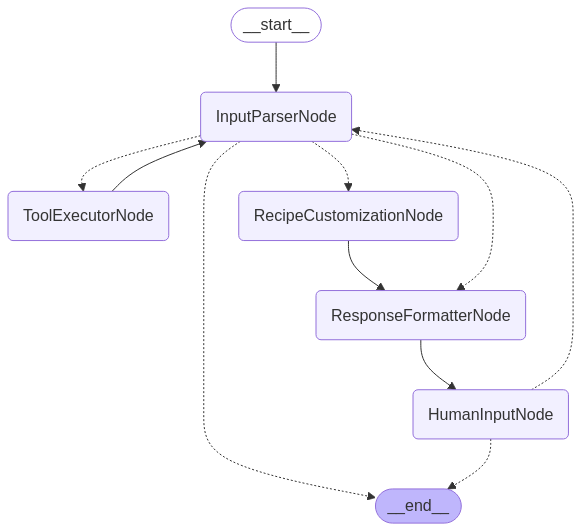

In [76]:
# Step 6: Graph Assembly and Compilation

import os
import re
import sqlite3
import json
import requests
import chromadb
import pandas as pd
import numpy as np
from typing import Annotated, List, Dict, Optional, Any, Sequence, Tuple, Literal
from typing_extensions import TypedDict

from langchain_core.messages import BaseMessage, AIMessage, HumanMessage, ToolMessage, SystemMessage
from langchain_core.tools import tool
from langchain_google_genai import ChatGoogleGenerativeAI
# Assuming google_search tool needs to be defined or imported
# from langchain_community.tools import GoogleSearchRun # Example
# from langchain_google_community import GoogleSearchAPIWrapper # Example
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display # For graph visualization

# --- Assume KitchenState is defined as in Step 1 ---
class KitchenState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]
    user_input: Optional[str]
    intent: Optional[str]
    search_params: Optional[Dict[str, Any]]
    selected_recipe_id: Optional[str]
    customization_request: Optional[str]
    nutrition_query: Optional[str]
    grounding_query: Optional[str]
    search_results: Optional[str] # Store raw tool output string
    current_recipe_details: Optional[Dict[str, Any]] # Store parsed JSON from tool output
    recipe_reviews: Optional[Dict[str, Any]] # Store parsed JSON from tool output
    nutritional_info: Optional[Dict[str, Any]] # Store aggregated/formatted nutrition
    ingredient_nutrition_list: Optional[List[Dict[str, Any]]] # Store list of nutrition dicts from tool calls
    grounding_results: Optional[str] # Store raw tool output string
    user_ingredients: List[str]
    dietary_preferences: List[str]
    needs_clarification: bool
    finished: bool
    last_assistant_response: Optional[str]
# --- End State Definition ---

# --- Assume Tools are defined as in Step 3 ---
# (Include tool definitions: gemini_recipe_similarity_search, gemini_interaction_similarity_search,
# get_recipe_by_id, get_ratings_and_reviews_by_recipe_id, fetch_nutrition_from_openfoodfacts,
# google_search, and placeholder tools like customize_recipe, calculate_recipe_nutrition etc.)
# --- Placeholder for tool definitions if running standalone ---
@tool
def gemini_recipe_similarity_search(query_text: str, n_results: int, cuisine: Optional[str] = None, dietary_tag: Optional[str] = None, max_minutes: Optional[int] = None) -> str:
    """Searches for similar recipes."""
    print(f"DEBUG TOOL CALL: gemini_recipe_similarity_search(query_text='{query_text}', n_results={n_results}, cuisine='{cuisine}', dietary_tag='{dietary_tag}', max_minutes={max_minutes})")
    # Simulate finding recipes
    if "pizza" in query_text:
         return json.dumps([{"recipe_id": "123", "name": "Margherita Pizza", "minutes": 20}, {"recipe_id": "456", "name": "Pepperoni Pizza", "minutes": 25}])
    return json.dumps([{"recipe_id": "789", "name": f"Found Recipe for {query_text}", "minutes": 30}])

@tool
def get_recipe_by_id(recipe_id: str) -> str:
    """Gets recipe details by ID."""
    print(f"DEBUG TOOL CALL: get_recipe_by_id(recipe_id='{recipe_id}')")
    if recipe_id == "71373":
         return json.dumps({"id": "71373", "name": "Country White Bread", "ingredients": ["flour", "water", "yeast", "salt", "sugar"], "steps": ["mix", "knead", "rise", "bake"], "normalized_ingredients": ["flour", "water", "yeast", "salt", "sugar"]})
    return json.dumps({"id": recipe_id, "name": f"Details for Recipe {recipe_id}", "ingredients": ["sample ingredient"], "steps": ["sample step"], "normalized_ingredients": ["sample ingredient"]})

@tool
def get_ratings_and_reviews_by_recipe_id(recipe_id: str, limit: int) -> str:
    """Gets ratings and reviews by recipe ID."""
    print(f"DEBUG TOOL CALL: get_ratings_and_reviews_by_recipe_id(recipe_id='{recipe_id}', limit={limit})")
    return json.dumps({"overall_rating": 4.5, "recent_reviews": [{"rating": 5, "review": "Loved it!"}] * min(limit, 1)})

@tool
def fetch_nutrition_from_openfoodfacts(ingredient_name: str) -> str:
    """Fetches nutrition for an ingredient."""
    print(f"DEBUG TOOL CALL: fetch_nutrition_from_openfoodfacts(ingredient_name='{ingredient_name}')")
    # Simulate API call
    if ingredient_name == "flour":
        return json.dumps({"calories_100g": 364, "carbohydrates_100g": 76, "proteins_100g": 10})
    return json.dumps({"status": "unavailable", "reason": f"Simulated: No data for {ingredient_name}"})

@tool
def google_search(query: str) -> str:
    """Performs Google search."""
    print(f"DEBUG TOOL CALL: google_search(query='{query}')")
    return f"Simulated web search results for: '{query}' show that a good substitute might be X."

@tool
def customize_recipe(recipe_id: str, request: str) -> str:
    """(Placeholder) Customizes recipe."""
    print(f"DEBUG TOOL CALL: customize_recipe(recipe_id='{recipe_id}', request='{request}')")
    return "Customization logic handled by RecipeCustomizationNode."

# --- End Placeholder Tools ---

# --- List of Stateless Tools for ToolNode ---
stateless_tools = [
    gemini_recipe_similarity_search,
    # gemini_interaction_similarity_search, # Assuming this is less common, add if needed
    get_recipe_by_id,
    get_ratings_and_reviews_by_recipe_id,
    fetch_nutrition_from_openfoodfacts,
    google_search,
]

# --- Tool Executor Node ---
tool_executor_node = ToolNode(stateless_tools)

# --- LLM Initialization (Binding tools the parser might call) ---
# Assuming GOOGLE_API_KEY is set
llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash-latest", convert_system_message_to_human=True)
# Bind only the tools the LLM should *decide* to call. Execution is separate.
# The placeholder tools help the LLM understand capabilities.
all_tools_for_llm = stateless_tools + [customize_recipe] # Add placeholders if needed for intent recognition
llm_with_all_tools = llm.bind_tools(all_tools_for_llm)

# --- Assume Nodes are defined as in Step 2 & 4 ---
# (Include input_parser_node, human_input_node, response_formatter_node,
# recipe_customization_node (placeholder), etc.)
# --- Placeholder Node Definitions ---
KITCHEN_ASSISTANT_SYSINT = ("system", "You are a kitchen assistant...") # Simplified

def input_parser_node(state: KitchenState) -> Dict[str, Any]:
    print("---PARSING USER INPUT (LLM)---")
    messages = state['messages']
    context_messages = [SystemMessage(content=KITCHEN_ASSISTANT_SYSINT[1])] + list(messages)
    ai_response: AIMessage = llm_with_all_tools.invoke(context_messages)
    state['messages'] = [ai_response]
    intent = "general_chat"
    last_assistant_response = None
    finished = state.get('finished', False)
    tool_calls = ai_response.tool_calls
    print(f"LLM Raw Response: {ai_response}") # Debugging

    if tool_calls:
        intent = "tool_call"
        print(f"Intent: {intent}, Tool Calls: {tool_calls}")
    elif ai_response.content:
        last_assistant_response = ai_response.content
        if "goodbye" in ai_response.content.lower():
             intent = "exit"
             finished = True
        print(f"Intent: {intent}, Response: {last_assistant_response[:100]}...")
    else:
        intent = "error"
        last_assistant_response = "Sorry, I couldn't process that."
        state['messages'] = [AIMessage(content=last_assistant_response)]
        print(f"Intent: {intent}")

    # Only return fields that need updating
    updates = {
        "intent": intent,
        "finished": finished,
        "last_assistant_response": last_assistant_response,
        # Clear results from previous turns if necessary (or handle context better)
        "search_results": None,
        "recipe_reviews": None,
        "nutritional_info": None,
        "ingredient_nutrition_list": None,
        "grounding_results": None,
    }
    # Keep selected_recipe_id and current_recipe_details if they exist for context
    if "selected_recipe_id" in state: updates["selected_recipe_id"] = state["selected_recipe_id"]
    if "current_recipe_details" in state: updates["current_recipe_details"] = state["current_recipe_details"]

    return {k: v for k, v in updates.items() if v is not None or k in ['last_assistant_response']} # Ensure last_assistant_response is always returned even if None


def human_input_node(state: KitchenState) -> Dict[str, Any]:
    print("---WAITING FOR USER INPUT---")
    last_response = state.get("last_assistant_response")
    if last_response:
        print(f"Assistant: {last_response}")
    else:
         print("Assistant: (Thinking/Performing action...)")
    user_input = input("You: ")
    finished = False
    if user_input.lower() in {"q", "quit", "exit", "goodbye"}:
        finished = True
    return {"user_input": user_input, "messages": [HumanMessage(content=user_input)], "finished": finished}

def response_formatter_node(state: KitchenState) -> Dict[str, Any]:
    print("---FORMATTING RESPONSE---")
    last_message = state['messages'][-1]
    formatted_response = "Okay, what next?" # Default

    if isinstance(last_message, AIMessage) and last_message.content:
        formatted_response = last_message.content
    elif isinstance(last_message, ToolMessage):
        # Simple formatting of tool results (can be enhanced with LLM)
        tool_outputs = []
        # Iterate backwards through messages to find all recent ToolMessages
        for msg in reversed(state['messages']):
            if isinstance(msg, ToolMessage):
                tool_outputs.append(f"Result for {msg.name}: {msg.content[:200]}...") # Truncate long results
            elif isinstance(msg, AIMessage): # Stop when we hit the AI message that made the call
                break
        if tool_outputs:
             formatted_response = "Here's the information I found:\n" + "\n".join(reversed(tool_outputs))
        else:
             formatted_response = "I've completed the action." # Fallback if no content in ToolMessage

    elif state.get("intent") == "exit": # Handle exit intent if parser didn't provide content
        formatted_response = "Okay, goodbye!"

    # Update state
    updates = {
        "last_assistant_response": formatted_response,
        "intent": None,
        "needs_clarification": False,
        # Add the formatted response as an AIMessage if it wasn't the last one
        "messages": [AIMessage(content=formatted_response)] if not (isinstance(last_message, AIMessage) and last_message.content) else []
    }
    # Clear specific data fields after formatting
    # Keep current_recipe_details if needed for follow-up (like customization)
    # updates["current_recipe_details"] = None
    updates["search_results"] = None
    updates["recipe_reviews"] = None
    updates["nutritional_info"] = None
    updates["ingredient_nutrition_list"] = None
    updates["grounding_results"] = None

    return {k: v for k, v in updates.items() if v is not None}


def recipe_customization_node(state: KitchenState) -> Dict[str, Any]:
    """Placeholder for recipe customization logic."""
    print("---ACTION: RECIPE CUSTOMIZATION (Placeholder Executing)---")
    recipe_name = state.get("current_recipe_details", {}).get("name", "the recipe")
    request = state.get("customization_request", "your request")
    # Simulate customization
    response_content = f"Okay, I've prepared a customized version of '{recipe_name}' based on '{request}'. [Details would go here]."
    return {"messages": [AIMessage(content=response_content)], "last_assistant_response": response_content, "customization_request": None}

# --- Assume Conditional Edge Functions are defined as in Step 5 ---
def route_after_parsing(state: KitchenState) -> Literal["ToolExecutorNode", "RecipeCustomizationNode", "ResponseFormatterNode", "__end__"]:
    print("---ROUTING (After Parsing)---")
    intent = state.get("intent")
    last_message = state['messages'][-1] if state['messages'] else None
    if isinstance(last_message, AIMessage) and last_message.tool_calls:
        print("Routing to: ToolExecutorNode")
        return "ToolExecutorNode"
    elif intent == "customize":
        print("Routing to: RecipeCustomizationNode")
        return "RecipeCustomizationNode"
    elif intent == "exit":
        print("Routing to: END")
        return END
    else:
        print("Routing to: ResponseFormatterNode")
        return "ResponseFormatterNode"

def route_after_human(state: KitchenState) -> Literal["InputParserNode", "__end__"]:
    print("---ROUTING (After Human)---")
    if state.get("finished", False):
        print("Routing to: END")
        return END
    else:
        print("Routing to: InputParserNode")
        return "InputParserNode"
# --- End Conditional Edge Functions ---


# --- Graph Assembly ---
graph_builder = StateGraph(KitchenState)

# Add Nodes
graph_builder.add_node("InputParserNode", input_parser_node)
graph_builder.add_node("HumanInputNode", human_input_node)
graph_builder.add_node("ToolExecutorNode", tool_executor_node)
graph_builder.add_node("RecipeCustomizationNode", recipe_customization_node) # Placeholder
graph_builder.add_node("ResponseFormatterNode", response_formatter_node)
# Note: Specific action nodes like RecipeSearchNode are replaced by the parser + tool executor combo

# Define Entry Point
graph_builder.add_edge(START, "InputParserNode")

# Define Edges
graph_builder.add_conditional_edges(
    "InputParserNode",
    route_after_parsing,
    {
        "ToolExecutorNode": "ToolExecutorNode",
        "RecipeCustomizationNode": "RecipeCustomizationNode",
        "ResponseFormatterNode": "ResponseFormatterNode",
        END: END
    }
)
graph_builder.add_conditional_edges(
    "HumanInputNode",
    route_after_human,
    {
        "InputParserNode": "InputParserNode",
        END: END
    }
)

# After tools run, go back to the parser to process results
graph_builder.add_edge("ToolExecutorNode", "InputParserNode")

# After customization (placeholder), format the response
graph_builder.add_edge("RecipeCustomizationNode", "ResponseFormatterNode")

# After formatting a response, show it to the human
graph_builder.add_edge("ResponseFormatterNode", "HumanInputNode")


# Compile the graph
kitchen_assistant_graph = graph_builder.compile()

print("\nGraph Compiled Successfully!")

# Visualize the graph (optional)
try:
    display(Image(kitchen_assistant_graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not visualize graph: {e}")

In [77]:
# Step 7: User Interface Integration (Conceptual using ipywidgets)

import os
import re
import sqlite3
import json
import requests
import chromadb
import pandas as pd
import numpy as np
from typing import Annotated, List, Dict, Optional, Any, Sequence, Tuple, Literal
from typing_extensions import TypedDict
import ipywidgets as widgets
from IPython.display import display, clear_output, Markdown, Image

from langchain_core.messages import BaseMessage, AIMessage, HumanMessage, ToolMessage, SystemMessage
from langchain_core.tools import tool
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode

# --- Assume KitchenState is defined as in Step 1 ---
class KitchenState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]
    user_input: Optional[str]
    intent: Optional[str]
    search_params: Optional[Dict[str, Any]]
    selected_recipe_id: Optional[str]
    customization_request: Optional[str]
    nutrition_query: Optional[str]
    grounding_query: Optional[str]
    search_results: Optional[str]
    current_recipe_details: Optional[Dict[str, Any]]
    recipe_reviews: Optional[Dict[str, Any]]
    nutritional_info: Optional[Dict[str, Any]]
    ingredient_nutrition_list: Optional[List[Dict[str, Any]]]
    grounding_results: Optional[str]
    user_ingredients: List[str]
    dietary_preferences: List[str]
    needs_clarification: bool
    finished: bool
    last_assistant_response: Optional[str]
    # Add a field to hold audio path if needed for voice input node
    audio_file_path: Optional[str]
# --- End State Definition ---

# --- Database/Vector Store Paths ---
VECTOR_DB_PATH = "final/vector_db"
DB_PATH = "final/kitchen_db.sqlite"
# --- End Paths ---

# --- API Key Setup ---
# Ensure GOOGLE_API_KEY is set in your environment
# --- End API Key Setup ---

# --- Assume Tools are defined as in Step 3 (Placeholders sufficient for graph structure) ---
@tool
def gemini_recipe_similarity_search(query_text: str, n_results: int, cuisine: Optional[str] = None, dietary_tag: Optional[str] = None, max_minutes: Optional[int] = None) -> str:
    """Searches for similar recipes."""
    print(f"DEBUG TOOL CALL: gemini_recipe_similarity_search(...)")
    return json.dumps([{"recipe_id": "789", "name": f"Found Recipe for {query_text}", "minutes": 30}])
@tool
def get_recipe_by_id(recipe_id: str) -> str:
    """Gets recipe details by ID."""
    print(f"DEBUG TOOL CALL: get_recipe_by_id(recipe_id='{recipe_id}')")
    if recipe_id == "71373":
         return json.dumps({"id": "71373", "name": "Country White Bread", "ingredients": ["flour", "water", "yeast", "salt", "sugar"], "steps": ["mix", "knead", "rise", "bake"], "normalized_ingredients": ["flour", "water", "yeast", "salt", "sugar"]})
    return json.dumps({"id": recipe_id, "name": f"Details for Recipe {recipe_id}", "ingredients": ["sample ingredient"], "steps": ["sample step"], "normalized_ingredients": ["sample ingredient"]})
@tool
def get_ratings_and_reviews_by_recipe_id(recipe_id: str, limit: int) -> str:
    """Gets ratings and reviews by recipe ID."""
    print(f"DEBUG TOOL CALL: get_ratings_and_reviews_by_recipe_id(recipe_id='{recipe_id}', limit={limit})")
    return json.dumps({"overall_rating": 4.5, "recent_reviews": [{"rating": 5, "review": "Loved it!"}] * min(limit, 1)})
@tool
def fetch_nutrition_from_openfoodfacts(ingredient_name: str) -> str:
    """Fetches nutrition for an ingredient."""
    print(f"DEBUG TOOL CALL: fetch_nutrition_from_openfoodfacts(ingredient_name='{ingredient_name}')")
    if ingredient_name == "flour":
        return json.dumps({"calories_100g": 364, "carbohydrates_100g": 76, "proteins_100g": 10})
    return json.dumps({"status": "unavailable", "reason": f"Simulated: No data for {ingredient_name}"})
@tool
def google_search(query: str) -> str:
    """Performs Google search."""
    print(f"DEBUG TOOL CALL: google_search(query='{query}')")
    return f"Simulated web search results for: '{query}' show that a good substitute might be X."
@tool
def customize_recipe(recipe_id: str, request: str) -> str:
    """(Placeholder) Customizes recipe."""
    print(f"DEBUG TOOL CALL: customize_recipe(recipe_id='{recipe_id}', request='{request}')")
    return "Customization logic handled by RecipeCustomizationNode."

stateless_tools = [
    gemini_recipe_similarity_search, get_recipe_by_id,
    get_ratings_and_reviews_by_recipe_id, fetch_nutrition_from_openfoodfacts, google_search
]
all_tools_for_llm = stateless_tools + [customize_recipe]
tool_executor_node = ToolNode(stateless_tools)
# --- End Tools ---

# --- LLM and System Prompt ---
llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash-latest", convert_system_message_to_human=True)
llm_with_all_tools = llm.bind_tools(all_tools_for_llm)
KITCHEN_ASSISTANT_SYSINT = ("system", "You are a kitchen assistant...") # Simplified
# --- End LLM ---

# --- Assume Node Functions are defined (InputParser, ResponseFormatter, Customization) ---
# Include definitions from Step 2 and 4 here, slightly modified
def input_parser_node(state: KitchenState) -> Dict[str, Any]:
    print("---PARSING USER INPUT (LLM)---")
    messages = state['messages']
    context_messages = [SystemMessage(content=KITCHEN_ASSISTANT_SYSINT[1])] + list(messages)
    ai_response: AIMessage = llm_with_all_tools.invoke(context_messages)
    state['messages'] = [ai_response]
    intent = "general_chat"
    last_assistant_response = None
    finished = state.get('finished', False)
    tool_calls = ai_response.tool_calls
    print(f"LLM Raw Response: {ai_response}")

    if tool_calls:
        intent = "tool_call"
        print(f"Intent: {intent}, Tool Calls: {tool_calls}")
    elif ai_response.content:
        last_assistant_response = ai_response.content
        if "goodbye" in ai_response.content.lower() or state.get("user_input", "").lower() in {"q", "quit", "exit", "goodbye"}:
             intent = "exit"
             finished = True
        print(f"Intent: {intent}, Response: {last_assistant_response[:100]}...")
    else:
        intent = "error"
        last_assistant_response = "Sorry, I couldn't process that."
        state['messages'] = [AIMessage(content=last_assistant_response)]
        print(f"Intent: {intent}")

    updates = {
        "intent": intent,
        "finished": finished,
        "last_assistant_response": last_assistant_response,
        "search_results": None, "recipe_reviews": None, "nutritional_info": None,
        "ingredient_nutrition_list": None, "grounding_results": None,
    }
    if "selected_recipe_id" in state: updates["selected_recipe_id"] = state["selected_recipe_id"]
    if "current_recipe_details" in state: updates["current_recipe_details"] = state["current_recipe_details"]

    return {k: v for k, v in updates.items() if v is not None or k in ['last_assistant_response']}

def response_formatter_node(state: KitchenState) -> Dict[str, Any]:
    print("---FORMATTING RESPONSE---")
    last_message = state['messages'][-1]
    formatted_response = "Okay, what next?"

    if isinstance(last_message, AIMessage) and last_message.content:
        formatted_response = last_message.content
    elif isinstance(last_message, ToolMessage):
        tool_outputs = []
        for msg in reversed(state['messages']):
            if isinstance(msg, ToolMessage):
                 # Attempt to parse JSON content from tools that return it
                 try:
                     content_data = json.loads(msg.content)
                     # Basic formatting for different tool outputs
                     if msg.name == 'get_recipe_by_id':
                         tool_outputs.append(f"Recipe Details: {content_data.get('name', 'N/A')} (ID: {content_data.get('id', 'N/A')})")
                     elif msg.name == 'get_ratings_and_reviews_by_recipe_id':
                         tool_outputs.append(f"Reviews: Overall {content_data.get('overall_rating', 'N/A')}, {len(content_data.get('recent_reviews',[]))} recent.")
                     elif msg.name == 'fetch_nutrition_from_openfoodfacts':
                         tool_outputs.append(f"Nutrition ({content_data.get('food_normalized', '?')}): {content_data.get('calories_100g', 'N/A')} kcal")
                     else:
                          tool_outputs.append(f"Result for {msg.name}: {msg.content[:150]}...")
                 except json.JSONDecodeError:
                     # Fallback for tools returning plain strings or errors
                     tool_outputs.append(f"Result for {msg.name}: {msg.content[:150]}...")
            elif isinstance(msg, AIMessage):
                break
        if tool_outputs:
             formatted_response = "Here's the information I found:\n" + "\n".join(reversed(tool_outputs))
        else:
             formatted_response = "I've completed the action."
    elif state.get("intent") == "exit":
        formatted_response = "Okay, goodbye!"

    updates = {
        "last_assistant_response": formatted_response,
        "intent": None, "needs_clarification": False,
        "messages": [AIMessage(content=formatted_response)] if not (isinstance(last_message, AIMessage) and last_message.content) else [],
        "search_results": None, "recipe_reviews": None, "nutritional_info": None,
        "ingredient_nutrition_list": None, "grounding_results": None,
    }
    # Keep recipe details if needed for next step (like customization)
    if "current_recipe_details" in state: updates["current_recipe_details"] = state["current_recipe_details"]
    if "selected_recipe_id" in state: updates["selected_recipe_id"] = state["selected_recipe_id"]

    return {k: v for k, v in updates.items() if v is not None or k in ['last_assistant_response']}

def recipe_customization_node(state: KitchenState) -> Dict[str, Any]:
    print("---ACTION: RECIPE CUSTOMIZATION (Placeholder Executing)---")
    recipe_name = state.get("current_recipe_details", {}).get("name", "the recipe")
    request = state.get("customization_request", "your request")
    response_content = f"Okay, I've prepared a customized version of '{recipe_name}' based on '{request}'. [Details would go here - Placeholder]."
    return {"messages": [AIMessage(content=response_content)], "last_assistant_response": response_content, "customization_request": None}

# Placeholder for transcribe_audio
def transcribe_audio(file_path: str, language: str = "en", **kwargs) -> str:
    print(f"DEBUG: Simulating transcription for {file_path}")
    if "pizza" in file_path: return "find pizza recipes"
    if "bread" in file_path: return "tell me about recipe 71373"
    return f"Transcribed text for {os.path.basename(file_path)}"
# --- End Node Functions ---

# --- Assume Edge Functions are defined as in Step 5 ---
def route_after_parsing(state: KitchenState) -> Literal["ToolExecutorNode", "RecipeCustomizationNode", "ResponseFormatterNode", "__end__"]:
    print("---ROUTING (After Parsing)---")
    intent = state.get("intent")
    last_message = state['messages'][-1] if state['messages'] else None
    if isinstance(last_message, AIMessage) and last_message.tool_calls:
        print("Routing to: ToolExecutorNode")
        return "ToolExecutorNode"
    elif intent == "customize":
        print("Routing to: RecipeCustomizationNode")
        return "RecipeCustomizationNode"
    elif intent == "exit":
        print("Routing to: END")
        return END
    else:
        print("Routing to: ResponseFormatterNode")
        return "ResponseFormatterNode"

def route_after_human_or_audio(state: KitchenState) -> Literal["InputParserNode", "__end__"]:
    """ Routes after human text input OR simulated audio input. """
    print("---ROUTING (After Human/Audio Input)---")
    if state.get("finished", False):
        print("Routing to: END")
        return END
    else:
        print("Routing to: InputParserNode")
        return "InputParserNode"
# --- End Edge Functions ---

# --- Assume Graph is compiled as in Step 6 ---
graph_builder = StateGraph(KitchenState)
graph_builder.add_node("InputParserNode", input_parser_node)
# We remove HumanInputNode from the graph, handling I/O outside
graph_builder.add_node("ToolExecutorNode", tool_executor_node)
graph_builder.add_node("RecipeCustomizationNode", recipe_customization_node)
graph_builder.add_node("ResponseFormatterNode", response_formatter_node)
graph_builder.add_edge(START, "InputParserNode") # Start with parsing (or initial message)
graph_builder.add_conditional_edges(
    "InputParserNode",
    route_after_parsing,
    {"ToolExecutorNode": "ToolExecutorNode", "RecipeCustomizationNode": "RecipeCustomizationNode", "ResponseFormatterNode": "ResponseFormatterNode", END: END}
)
graph_builder.add_edge("ToolExecutorNode", "InputParserNode") # Tools results back to parser
graph_builder.add_edge("RecipeCustomizationNode", "ResponseFormatterNode") # Customization result to formatter
# Response Formatter now leads implicitly back to the UI loop waiting for input
# We don't add an edge *from* ResponseFormatterNode within the graph itself for this UI model.
# The human input step is handled *outside* the graph.stream() loop.

kitchen_assistant_graph = graph_builder.compile()
print("\nGraph Compiled Successfully!")
# --- End Graph Compilation ---


# --- UI Simulation using ipywidgets ---

# Conversation state (global for this simple example)
conversation_state: KitchenState = {
    "messages": [], "user_input": None, "intent": None, "search_params": None,
    "selected_recipe_id": None, "customization_request": None, "nutrition_query": None,
    "grounding_query": None, "search_results": None, "current_recipe_details": None,
    "recipe_reviews": None, "nutritional_info": None, "ingredient_nutrition_list": None,
    "grounding_results": None, "user_ingredients": [], "dietary_preferences": [],
    "needs_clarification": False, "finished": False, "last_assistant_response": None,
    "audio_file_path": None
}

# Widgets
text_input = widgets.Textarea(description="You:", layout={'width': '90%'})
text_submit_button = widgets.Button(description="Send Text")
voice_options = [("Select Voice...", None)] + [
    (f"{voice['description']} ({os.path.basename(voice['file_path'])})", voice['file_path'])
    # Add more voice files from your 'voices' dict or file system if needed
    for voice in [{"file_path": "/kaggle/input/voice-tests/test.ogg", "description": "Pizza search"}, # Example paths
                  {"file_path": "bread_details.wav", "description": "Bread details request"}] # Add more dummy paths
]
voice_dropdown = widgets.Dropdown(options=voice_options, description="Voice:")
voice_submit_button = widgets.Button(description="Process Voice")
output_area = widgets.Output(layout={'border': '1px solid black', 'height': '400px', 'overflow_y': 'scroll', 'width': '90%'})
debug_output = widgets.Output(layout={'border': '1px solid blue', 'height': '100px', 'overflow_y': 'scroll', 'width': '90%'}) # For DEBUG prints

# Display initial welcome message
with output_area:
    print("Assistant: Welcome to the Interactive Kitchen Assistant! How can I help you today?")

# --- Interaction Logic ---
def run_graph_and_display(initial_state_update: Dict):
    global conversation_state # Use the global state

    # Update state with the new input
    conversation_state.update(initial_state_update)
    # Add the human message to the history
    if "messages" in initial_state_update:
         conversation_state["messages"] = list(conversation_state.get("messages", [])) + initial_state_update["messages"]

    with output_area:
        if "user_input" in initial_state_update and initial_state_update["user_input"]:
             print(f"You: {initial_state_update['user_input']}") # Display user input

    # Stream graph execution
    final_state = None
    assistant_response_to_display = "Thinking..."
    try:
        # Use stream to run the graph until it naturally stops (at END or needs input)
        # The graph structure now assumes input parsing is the first step after human input.
        # We start the stream with the updated state.
        for step_state in kitchen_assistant_graph.stream(conversation_state, {"recursion_limit": 15}):
            # `step_state` contains the state *after* each node runs
            node_name = list(step_state.keys())[0] # Get the name of the node that just ran
            current_state_snapshot = step_state[node_name]
            final_state = current_state_snapshot # Keep track of the latest state

            # Update global state progressively (optional, but useful for complex flows)
            conversation_state.update(current_state_snapshot)

            # Display debug info (optional)
            with debug_output:
                 print(f"Node '{node_name}' executed. Current Intent: {conversation_state.get('intent')}")
                 # print(f"State after {node_name}: {current_state_snapshot}") # Very verbose

            # Check if the graph finished
            if conversation_state.get("finished", False):
                 assistant_response_to_display = conversation_state.get("last_assistant_response", "Goodbye!")
                 break

            # If the formatter ran, its output is ready to be shown before waiting for next input
            if node_name == "ResponseFormatterNode":
                 assistant_response_to_display = conversation_state.get("last_assistant_response", "What next?")
                 # The loop will naturally end here as there's no edge out of ResponseFormatterNode
                 # back into the graph without human input.
                 break # Exit the stream, wait for next user action

        # If the loop finished without the formatter running (e.g., direct END from parser)
        if final_state and final_state.get("finished"):
             assistant_response_to_display = final_state.get("last_assistant_response", "Goodbye!")

    except Exception as e:
        assistant_response_to_display = f"An error occurred: {e}"
        print(f"ERROR during graph execution: {e}") # Log error

    # Display the final response for this turn
    with output_area:
        clear_output(wait=True) # Clear previous assistant thinking message
        # Re-display history (optional, could append instead)
        for msg in conversation_state.get("messages", []):
             if isinstance(msg, HumanMessage):
                 print(f"You: {msg.content}")
             elif isinstance(msg, AIMessage) and msg.content: # Only display AI messages with text content
                 print(f"Assistant: {msg.content}")
             # Optionally display tool messages/calls for debugging
             # elif isinstance(msg, ToolMessage):
             #     print(f"Tool Result ({msg.name}): {msg.content[:100]}...")
             # elif isinstance(msg, AIMessage) and msg.tool_calls:
             #     print(f"Assistant: (Calling tools: {[tc['name'] for tc in msg.tool_calls]})")

        # Ensure the very last response is shown if it wasn't part of messages
        if assistant_response_to_display and (not conversation_state.get("messages") or conversation_state["messages"][-1].content != assistant_response_to_display):
             print(f"Assistant: {assistant_response_to_display}")


    # Update the global state with the final state of this run
    if final_state:
        conversation_state.update(final_state)
        # Crucially update the message history for the next turn
        conversation_state["messages"] = final_state.get("messages", [])


def on_text_submit(b):
    with output_area: # Capture output within the designated area
        clear_output(wait=True) # Clear previous outputs before showing new interaction
        user_text = text_input.value
        if not user_text:
            print("Assistant: Please enter your request.")
            return
        print(f"You: {user_text}") # Show user input immediately
        print("Assistant: Thinking...") # Indicate processing

    # Prepare state update for the graph
    initial_update = {
        "user_input": user_text,
        "messages": [HumanMessage(content=user_text)]
    }
    # Clear the input field
    text_input.value = ""
    # Run the graph
    run_graph_and_display(initial_update)

def on_voice_submit(b):
     with output_area:
        clear_output(wait=True)
        selected_file = voice_dropdown.value
        if not selected_file:
            print("Assistant: Please select a voice file.")
            return
        print(f"Processing voice file: {os.path.basename(selected_file)}...")
        print("Assistant: Thinking...")

     # Simulate transcription
     # In a real app, you might pass the actual audio data or use the AudioInputNode
     transcribed_text = transcribe_audio(file_path=selected_file) # Using placeholder

     if "Error:" in transcribed_text:
          with output_area:
               clear_output(wait=True)
               print(f"Assistant: Transcription failed - {transcribed_text}")
          return

     with output_area:
          print(f"You (Voice): {transcribed_text}") # Show transcribed text

     # Prepare state update
     initial_update = {
         "user_input": transcribed_text,
         "messages": [HumanMessage(content=transcribed_text)],
         "audio_file_path": selected_file # Pass path if needed by a node
     }
     # Reset dropdown
     voice_dropdown.value = None
     # Run the graph
     run_graph_and_display(initial_update)

# Assign callbacks
text_submit_button.on_click(on_text_submit)
voice_submit_button.on_click(on_voice_submit)

# Display Widgets
print("--- Kitchen Assistant Interface ---")
display(widgets.VBox([
    widgets.HTML("<b>Enter your request via text or select a voice file:</b>"),
    text_input,
    text_submit_button,
    widgets.HTML("<hr>"),
    voice_dropdown,
    voice_submit_button,
    widgets.HTML("<hr><b>Conversation:</b>"),
    output_area,
    widgets.HTML("<hr><b>Debug Log:</b>"),
    debug_output
]))


Graph Compiled Successfully!
--- Kitchen Assistant Interface ---


In [78]:
# Step 8: Testing and Refinement Setup

import os
import re
import sqlite3
import json
import requests
import chromadb
import pandas as pd
import numpy as np
from typing import Annotated, List, Dict, Optional, Any, Sequence, Tuple, Literal
from typing_extensions import TypedDict
from IPython.display import display, Markdown, Image # For potential visualization

from langchain_core.messages import BaseMessage, AIMessage, HumanMessage, ToolMessage, SystemMessage
from langchain_core.tools import tool
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode

# --- Assume KitchenState is defined as in Step 1 ---
class KitchenState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]
    user_input: Optional[str]
    intent: Optional[str]
    search_params: Optional[Dict[str, Any]]
    selected_recipe_id: Optional[str]
    customization_request: Optional[str]
    nutrition_query: Optional[str]
    grounding_query: Optional[str]
    search_results: Optional[str]
    current_recipe_details: Optional[Dict[str, Any]]
    recipe_reviews: Optional[Dict[str, Any]]
    nutritional_info: Optional[Dict[str, Any]]
    ingredient_nutrition_list: Optional[List[Dict[str, Any]]]
    grounding_results: Optional[str]
    user_ingredients: List[str]
    dietary_preferences: List[str]
    needs_clarification: bool
    finished: bool
    last_assistant_response: Optional[str]
    audio_file_path: Optional[str]
# --- End State Definition ---

# --- Database/Vector Store Paths ---
VECTOR_DB_PATH = "final/vector_db"
DB_PATH = "final/kitchen_db.sqlite"
# --- End Paths ---

# --- API Key Setup ---
# Ensure GOOGLE_API_KEY is set in your environment
# --- End API Key Setup ---

# --- Tool Definitions (Placeholders sufficient for testing flow) ---
@tool
def gemini_recipe_similarity_search(query_text: str, n_results: int, cuisine: Optional[str] = None, dietary_tag: Optional[str] = None, max_minutes: Optional[int] = None) -> str:
    """Searches for similar recipes."""
    print(f"DEBUG TOOL CALL: gemini_recipe_similarity_search(query_text='{query_text}', n_results={n_results}, cuisine='{cuisine}', dietary_tag='{dietary_tag}', max_minutes={max_minutes})")
    return json.dumps([{"recipe_id": "789", "name": f"Found Recipe for {query_text}", "minutes": 30}])

@tool
def get_recipe_by_id(recipe_id: str) -> str:
    """Gets recipe details by ID."""
    print(f"DEBUG TOOL CALL: get_recipe_by_id(recipe_id='{recipe_id}')")
    if recipe_id == "71373":
         return json.dumps({"id": "71373", "name": "Country White Bread", "ingredients": ["flour", "water", "yeast", "salt", "sugar"], "steps": ["mix", "knead", "rise", "bake"], "normalized_ingredients": ["flour", "water", "yeast", "salt", "sugar"]})
    return json.dumps({"id": recipe_id, "name": f"Details for Recipe {recipe_id}", "ingredients": ["sample ingredient"], "steps": ["sample step"], "normalized_ingredients": ["sample ingredient"]})

@tool
def get_ratings_and_reviews_by_recipe_id(recipe_id: str, limit: int) -> str:
    """Gets ratings and reviews by recipe ID."""
    print(f"DEBUG TOOL CALL: get_ratings_and_reviews_by_recipe_id(recipe_id='{recipe_id}', limit={limit})")
    if not isinstance(limit, int) or limit <= 0: return "Error: Limit must be positive integer."
    return json.dumps({"overall_rating": 4.5, "recent_reviews": [{"rating": 5, "review": "Loved it!"}] * min(limit, 1)})

@tool
def fetch_nutrition_from_openfoodfacts(ingredient_name: str) -> str:
    """Fetches nutrition for an ingredient."""
    print(f"DEBUG TOOL CALL: fetch_nutrition_from_openfoodfacts(ingredient_name='{ingredient_name}')")
    if ingredient_name == "flour":
        return json.dumps({"calories_100g": 364, "carbohydrates_100g": 76, "proteins_100g": 10})
    return json.dumps({"status": "unavailable", "reason": f"Simulated: No data for {ingredient_name}"})

@tool
def google_search(query: str) -> str:
    """Performs Google search."""
    print(f"DEBUG TOOL CALL: google_search(query='{query}')")
    return f"Simulated web search results for: '{query}' show that a good substitute might be X."

@tool
def customize_recipe(recipe_id: str, request: str) -> str:
    """(Placeholder) Customizes recipe."""
    print(f"DEBUG TOOL CALL: customize_recipe(recipe_id='{recipe_id}', request='{request}')")
    return "Customization logic handled by RecipeCustomizationNode."

stateless_tools = [
    gemini_recipe_similarity_search, get_recipe_by_id,
    get_ratings_and_reviews_by_recipe_id, fetch_nutrition_from_openfoodfacts, google_search
]
all_tools_for_llm = stateless_tools + [customize_recipe]
tool_executor_node = ToolNode(stateless_tools)
# --- End Tools ---

# --- LLM and System Prompt ---
# Assuming GOOGLE_API_KEY is set
llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash-latest", convert_system_message_to_human=True)
llm_with_all_tools = llm.bind_tools(all_tools_for_llm)
KITCHEN_ASSISTANT_SYSINT = ("system", """
You are a helpful, friendly, and knowledgeable Interactive Recipe & Kitchen Management Assistant.
Capabilities: Recipe Discovery (tool: gemini_recipe_similarity_search), Recipe Details (tool: get_recipe_by_id),
Ratings & Reviews (tool: get_ratings_and_reviews_by_recipe_id - MUST provide integer limit, default 3),
Ingredient Nutrition (tool: fetch_nutrition_from_openfoodfacts), Recipe Customization (intent: customize),
Grounding (tool: google_search).
Interaction Flow: Understand intent -> Ask for clarification if needed -> Call appropriate tool(s) -> Format response -> Wait for next input.
Rules: Stay on topic (recipes, cooking, food). Be polite. Explain if unable to fulfill. For reviews, ALWAYS use the limit argument.
""") # Condensed for brevity
# --- End LLM ---

# --- Node Functions (Placeholders/Simplified from previous steps) ---
def input_parser_node(state: KitchenState) -> Dict[str, Any]:
    print("---PARSING USER INPUT (LLM)---")
    messages = state['messages']
    context_messages = [SystemMessage(content=KITCHEN_ASSISTANT_SYSINT[1])] + list(messages)
    ai_response: AIMessage = llm_with_all_tools.invoke(context_messages)
    state['messages'] = [ai_response] # Store AI response
    intent = "general_chat"
    last_assistant_response = None
    finished = state.get('finished', False)
    tool_calls = ai_response.tool_calls
    print(f"LLM Raw Response: {ai_response}")

    if tool_calls:
        intent = "tool_call"
        print(f"Intent: {intent}, Tool Calls: {tool_calls}")
    elif ai_response.content:
        last_assistant_response = ai_response.content
        # Basic intent check based on content (can be improved)
        if "search for" in last_assistant_response.lower() or "find recipe" in last_assistant_response.lower(): intent = "search_recipe"
        elif "details for recipe" in last_assistant_response.lower(): intent = "get_details"
        elif "nutrition for" in last_assistant_response.lower(): intent = "nutrition"
        elif "reviews for recipe" in last_assistant_response.lower(): intent = "get_reviews"
        elif "customize" in last_assistant_response.lower() or "substitute" in last_assistant_response.lower(): intent = "customize"
        elif "search the web" in last_assistant_response.lower(): intent = "grounding_query"
        elif "goodbye" in last_assistant_response.lower() or state.get("user_input", "").lower() in {"q", "quit", "exit", "goodbye"}:
             intent = "exit"
             finished = True
        print(f"Intent: {intent}, Response: {last_assistant_response[:100]}...")
    else:
        intent = "error"
        last_assistant_response = "Sorry, I couldn't process that."
        state['messages'] = [AIMessage(content=last_assistant_response)]
        print(f"Intent: {intent}")

    updates = {"intent": intent, "finished": finished, "last_assistant_response": last_assistant_response}
    # Clear results from previous turns
    for key in ["search_results", "recipe_reviews", "nutritional_info", "ingredient_nutrition_list", "grounding_results"]:
        updates[key] = None
    # Keep context if needed
    if "selected_recipe_id" in state: updates["selected_recipe_id"] = state["selected_recipe_id"]
    if "current_recipe_details" in state: updates["current_recipe_details"] = state["current_recipe_details"]

    return {k: v for k, v in updates.items() if v is not None or k in ['last_assistant_response']}

def response_formatter_node(state: KitchenState) -> Dict[str, Any]:
    print("---FORMATTING RESPONSE---")
    last_message = state['messages'][-1]
    formatted_response = "Okay, what next?"
    if isinstance(last_message, AIMessage) and last_message.content:
        formatted_response = last_message.content
    elif isinstance(last_message, ToolMessage):
         formatted_response = f"Okay, I have the information for {last_message.name}."
    elif state.get("intent") == "exit":
        formatted_response = "Okay, goodbye!"

    updates = {
        "last_assistant_response": formatted_response,
        "intent": None, "needs_clarification": False,
        "messages": [AIMessage(content=formatted_response)] if not (isinstance(last_message, AIMessage) and last_message.content) else []
    }
    # Clear data fields after formatting (except maybe recipe details for context)
    for key in ["search_results", "recipe_reviews", "nutritional_info", "ingredient_nutrition_list", "grounding_results"]:
         updates[key] = None
    # Keep context
    if "current_recipe_details" in state: updates["current_recipe_details"] = state["current_recipe_details"]
    if "selected_recipe_id" in state: updates["selected_recipe_id"] = state["selected_recipe_id"]

    return {k: v for k, v in updates.items() if v is not None or k in ['last_assistant_response']}

def recipe_customization_node(state: KitchenState) -> Dict[str, Any]:
    print("---ACTION: RECIPE CUSTOMIZATION (Placeholder Executing)---")
    recipe_name = state.get("current_recipe_details", {}).get("name", "the recipe")
    request = state.get("customization_request", "your request")
    response_content = f"Okay, I've prepared a customized version of '{recipe_name}' based on '{request}'. [Details would go here - Placeholder]."
    return {"messages": [AIMessage(content=response_content)], "last_assistant_response": response_content, "customization_request": None}
# --- End Node Functions ---

# --- Assume Edge Functions are defined as in Step 5 ---
def route_after_parsing(state: KitchenState) -> Literal["ToolExecutorNode", "RecipeCustomizationNode", "ResponseFormatterNode", "__end__"]:
    print("---ROUTING (After Parsing)---")
    intent = state.get("intent")
    last_message = state['messages'][-1] if state['messages'] else None
    if isinstance(last_message, AIMessage) and last_message.tool_calls:
        # Check if the tool call is for customization (handled by custom node)
        if any(tc['name'] == 'customize_recipe' for tc in last_message.tool_calls):
             print("Routing to: RecipeCustomizationNode")
             return "RecipeCustomizationNode"
        else:
             print("Routing to: ToolExecutorNode")
             return "ToolExecutorNode"
    elif intent == "customize": # If intent was set directly without tool call (less likely now)
        print("Routing to: RecipeCustomizationNode")
        return "RecipeCustomizationNode"
    elif intent == "exit":
        print("Routing to: END")
        return END
    else: # Includes general_chat, clarification_needed, error
        print("Routing to: ResponseFormatterNode")
        return "ResponseFormatterNode"

# This router is now simplified as Human Input is outside the main test loop
def route_after_tool_or_customization(state: KitchenState) -> Literal["InputParserNode", "ResponseFormatterNode"]:
     """ Routes back to parser after tool execution, or to formatter after customization"""
     print("---ROUTING (After Tool/Customization)---")
     last_message = state['messages'][-1] if state['messages'] else None
     if isinstance(last_message, ToolMessage):
          print("Routing to: InputParserNode")
          return "InputParserNode" # Let parser process tool results
     else: # Assume it came from customization or another non-tool action node
          print("Routing to: ResponseFormatterNode")
          return "ResponseFormatterNode"

# --- Graph Assembly ---
graph_builder = StateGraph(KitchenState)

graph_builder.add_node("InputParserNode", input_parser_node)
graph_builder.add_node("ToolExecutorNode", tool_executor_node)
graph_builder.add_node("RecipeCustomizationNode", recipe_customization_node) # Placeholder
graph_builder.add_node("ResponseFormatterNode", response_formatter_node)

graph_builder.add_edge(START, "InputParserNode")
graph_builder.add_conditional_edges(
    "InputParserNode",
    route_after_parsing,
    {"ToolExecutorNode": "ToolExecutorNode", "RecipeCustomizationNode": "RecipeCustomizationNode", "ResponseFormatterNode": "ResponseFormatterNode", END: END}
)
# Edges after actions
graph_builder.add_edge("ToolExecutorNode", "InputParserNode") # Process tool results
graph_builder.add_edge("RecipeCustomizationNode", "ResponseFormatterNode") # Format customization

# The graph now stops after ResponseFormatterNode, waiting for the next input in the test loop
graph_builder.add_edge("ResponseFormatterNode", END) # End the graph run for testing

kitchen_assistant_graph = graph_builder.compile()
print("\nGraph Compiled Successfully for Testing!")

# --- Testing Framework ---

def test_scenario(scenario_name: str, initial_messages: List[Tuple[str, str]], expected_intent: Optional[str] = None, expected_tool_calls: Optional[List[str]] = None):
    """Runs a scenario through the graph and prints the final state."""
    print(f"\n===== RUNNING SCENARIO: {scenario_name} =====")
    print(f"Initial Messages: {initial_messages}")

    # Convert initial messages to BaseMessage objects
    messages_for_state = []
    for type, content in initial_messages:
        if type == "human":
            messages_for_state.append(HumanMessage(content=content))
        elif type == "ai":
            messages_for_state.append(AIMessage(content=content))
        # Add other types if needed

    initial_state: KitchenState = {
        "messages": messages_for_state,
        "user_input": initial_messages[-1][1] if initial_messages and initial_messages[-1][0] == 'human' else None,
        "intent": None, "search_params": None, "selected_recipe_id": None,
        "customization_request": None, "nutrition_query": None, "grounding_query": None,
        "search_results": None, "current_recipe_details": None, "recipe_reviews": None,
        "nutritional_info": None, "ingredient_nutrition_list": None, "grounding_results": None,
        "user_ingredients": [], "dietary_preferences": [],
        "needs_clarification": False, "finished": False, "last_assistant_response": None,
        "audio_file_path": None
    }

    # Invoke the graph
    final_state = None
    try:
        # Use invoke for testing to get the final state after the sequence runs
        final_state = kitchen_assistant_graph.invoke(initial_state, {"recursion_limit": 15})

        print("\n----- FINAL STATE -----")
        # Print key parts of the final state for validation
        print(f"Intent determined by last parser run: {final_state.get('intent')}")
        print(f"Finished flag: {final_state.get('finished')}")
        print("Conversation History:")
        for msg in final_state.get('messages', []):
             print(f"- {type(msg).__name__}: {str(msg.content)[:150]}...") # Truncate long content
             if hasattr(msg, 'tool_calls') and msg.tool_calls:
                 print(f"  Tool Calls: {[tc['name'] for tc in msg.tool_calls]}")
        print(f"Last Assistant Response: {final_state.get('last_assistant_response')}")
        print("-----------------------")

        # Basic Validation (can be expanded)
        if expected_intent and final_state.get('intent') != expected_intent:
             print(f"VALIDATION WARNING: Expected intent '{expected_intent}', but got '{final_state.get('intent')}'")
        if expected_tool_calls:
             last_ai_msg = next((m for m in reversed(final_state.get('messages', [])) if isinstance(m, AIMessage)), None)
             actual_calls = [tc['name'] for tc in last_ai_msg.tool_calls] if last_ai_msg and last_ai_msg.tool_calls else []
             if set(actual_calls) != set(expected_tool_calls):
                  print(f"VALIDATION WARNING: Expected tool calls {expected_tool_calls}, but got {actual_calls}")

    except Exception as e:
        print(f"\n----- ERROR DURING SCENARIO EXECUTION -----")
        print(f"Error: {e}")
        print("------------------------------------------")

    print(f"===== SCENARIO COMPLETE: {scenario_name} =====")
    return final_state

# --- Define Test Scenarios ---
test_scenarios = [
    {
        "name": "Simple Recipe Search",
        "initial_messages": [("human", "Find recipes with chicken and broccoli")],
        "expected_intent": "tool_call", # Expecting the parser to trigger a tool call
        "expected_tool_calls": ["gemini_recipe_similarity_search"]
    },
    {
        "name": "Filtered Recipe Search",
        "initial_messages": [("human", "Show me vegan pasta recipes under 45 minutes")],
         "expected_intent": "tool_call",
         "expected_tool_calls": ["gemini_recipe_similarity_search"] # Expect parser to extract filters
    },
    {
        "name": "Recipe Details Request",
        "initial_messages": [("human", "Tell me about recipe 71373")],
        "expected_intent": "tool_call",
        "expected_tool_calls": ["get_recipe_by_id", "get_ratings_and_reviews_by_recipe_id"]
    },
    {
        "name": "Ingredient Nutrition Query",
        "initial_messages": [("human", "What's the nutrition for flour?")],
        "expected_intent": "tool_call",
        "expected_tool_calls": ["fetch_nutrition_from_openfoodfacts"]
    },
    # { # This scenario requires context (recipe ID) to be set first
    #     "name": "Recipe Nutrition Query",
    #     "initial_messages": [("human", "How many calories in recipe 71373?")],
    #     "expected_intent": "tool_call", # Should ideally call get_recipe_by_id first if details not present
    #     "expected_tool_calls": ["get_recipe_by_id"] # Or directly call fetch_nutrition if details known
    # },
    {
        "name": "Recipe Customization Request (Placeholder)",
        "initial_messages": [
            # Need context: Assume recipe 71373 details were just shown
            ("ai", "Here are the details for Country White Bread..."),
            ("human", "Can you make this gluten-free?")
            ],
        "expected_intent": "customize", # Parser should identify customize intent
        "expected_tool_calls": None # Should route to RecipeCustomizationNode, not ToolExecutor
    },
    {
        "name": "Grounding Query",
        "initial_messages": [("human", "What is a good substitute for buttermilk in baking?")],
        "expected_intent": "tool_call",
        "expected_tool_calls": ["google_search"]
    },
    {
        "name": "Voice Input Simulation (Pizza Search)",
        "initial_messages": [("human", transcribe_audio(file_path="dummy_pizza.ogg"))], # Use transcribed text
        "expected_intent": "tool_call",
        "expected_tool_calls": ["gemini_recipe_similarity_search"]
    },
    {
        "name": "Exit Conversation",
        "initial_messages": [("human", "quit")],
        "expected_intent": "exit",
        "expected_tool_calls": None
    },
    # Add more scenarios: multi-turn, clarification needed, error handling etc.
]

# --- Run Tests ---
print("\n\n--- STARTING TEST SCENARIOS ---")
for scenario in test_scenarios:
    # Reset state for each scenario if needed, or pass context
    test_scenario(
        scenario["name"],
        scenario["initial_messages"],
        scenario.get("expected_intent"),
        scenario.get("expected_tool_calls")
    )
print("--- TESTING COMPLETE ---")

# --- Refinement Notes (Markdown) ---
"""
**Refinement Guide based on Testing:**

*   **Incorrect Intent/Routing:** If the graph goes to the wrong node (e.g., `ResponseFormatterNode` instead of `ToolExecutorNode`), adjust:
    *   **System Prompt (`KITCHEN_ASSISTANT_SYSINT`):** Make instructions clearer about when to use specific tools or ask for clarification. Improve descriptions of tool purposes.
    *   **Tool Descriptions (`@tool` docstrings):** Ensure docstrings accurately reflect what the tool does and what arguments it needs. This heavily influences the LLM's decision to call it.
    *   **`input_parser_node` Logic:** If using simplified keyword matching, make it more robust. If using LLM, check if the prompt needs adjustment.
    *   **`route_after_parsing` Function:** Modify the conditions if the intent classification needs tweaking.
*   **Incorrect Tool Called:**
    *   Review **Tool Descriptions** and **System Prompt** for clarity.
    *   Ensure tool names are distinct and descriptive.
*   **Incorrect Tool Arguments:**
    *   Check **Tool Descriptions** specify argument types and purpose clearly.
    *   Refine the **System Prompt** on how to extract parameters.
    *   Improve parameter extraction logic within `input_parser_node` if not relying solely on LLM function calling.
*   **Poorly Formatted Output:**
    *   Adjust the logic within `response_formatter_node`.
    *   Consider using the LLM within the formatter for more natural summarization of tool results by passing the `ToolMessage` content back to the LLM.
*   **Errors during Tool Execution:**
    *   Improve error handling *within* the tool functions themselves (e.g., `try...except` blocks in DB/API calls).
    *   Ensure the `ToolExecutorNode` handles exceptions gracefully and returns informative `ToolMessage` content indicating the error.
    *   Modify `input_parser_node` to recognize error messages from tools and potentially ask the user to rephrase or try again.
*   **Missing Information/Clarification Loops:**
    *   Enhance the **System Prompt** to guide the LLM on *when* and *how* to ask clarifying questions.
    *   Improve the `input_parser_node`'s ability to detect missing parameters and set the `needs_clarification` flag or generate a specific clarification question.
"""
display(Markdown("--- Refinement Notes ---"))
display(Markdown(instruction)) # Display the refinement notes


Graph Compiled Successfully for Testing!
DEBUG: Simulating transcription for dummy_pizza.ogg


--- STARTING TEST SCENARIOS ---

===== RUNNING SCENARIO: Simple Recipe Search =====
Initial Messages: [('human', 'Find recipes with chicken and broccoli')]
---PARSING USER INPUT (LLM)---
LLM Raw Response: content='Certainly! I can help you find recipes with chicken and broccoli.' additional_kwargs={'function_call': {'name': 'gemini_recipe_similarity_search', 'arguments': '{"n_results": 5.0, "query_text": "chicken and broccoli"}'}} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-1.5-flash-latest', 'safety_ratings': []} id='run-a9e14d1e-a98c-407d-95b2-d888882a34aa-0' tool_calls=[{'name': 'gemini_recipe_similarity_search', 'args': {'n_results': 5.0, 'query_text': 'chicken and broccoli'}, 'id': 'b8a17fd9-a45d-41a2-bd04-cbb6cfce2aca', 'type': 'tool_call'}] usage_metadata={'input_tokens': 307, 'output_tokens': 30, 'tot

--- Refinement Notes ---

You are a helpful chatbot that can interact with an SQL database for a Kitchen Assistant.
You can retrieve information about recipes and user interactions (ratings and reviews).
Use the available tools to understand the database schema and execute SQL queries to answer user questions.
**Note:** Ingredient nutrition information is fetched live from the Open Food Facts API when you request recipe details using `get_recipe_by_id`.

Here are the available tools:

- list_tables(): Lists all tables in the database.
- describe_table(table_name: str): Describes the schema (columns and their types) of a specified table.
- execute_query(sql: str): Executes an SQL query and returns the results. Use this for complex data retrieval. Be careful with the SQL syntax.
- get_recipe_by_id(recipe_id: str): Retrieves all details for a specific recipe given its ID. This includes fetching live nutrition data for each normalized ingredient from Open Food Facts.
- get_ratings_and_reviews_by_recipe_id(recipe_id: str, limit: int): Retrieves the overall rating and the 'limit' most recent reviews for a given recipe ID. You MUST provide a value for 'limit'. If the user doesn't specify, use 3.

When a user asks a question:

1. Understand the user's intent and identify which tool(s) can best answer the question.
2. If the question requires specific information about a recipe (like ingredients, steps, nutrition), use `get_recipe_by_id`. This will automatically include nutrition details fetched from Open Food Facts.
3. If the question asks for ratings or reviews for a recipe, use `get_ratings_and_reviews_by_recipe_id`. **Always specify a value for the 'limit' parameter. If the user doesn't say how many reviews, use 3.**
4. For more complex queries involving filtering, joining tables, or specific data selection, construct and use the `execute_query` tool. First, use `list_tables` and `describe_table` to understand the database structure if needed.
5. Present the information clearly and concisely to the user, ideally in a readable format like Markdown.

For example:

- To get details about recipe ID 71373 (including ingredient nutrition), use `get_recipe_by_id(recipe_id='71373')`.
- To get the overall rating and 3 recent reviews for recipe ID 71373, use `get_ratings_and_reviews_by_recipe_id(recipe_id='71373', limit=3)`.
- For a complex query like "Find recipes with 'chicken' and a cooking time less than 30 minutes", you might need to use `execute_query` after understanding the 'recipes' table schema.

Be mindful of potential SQL injection if using `execute_query` with user-provided input, although in this setup, the queries are constructed by you based on the user's intent.
